## Imports

In [1]:

from sklearn.metrics import  confusion_matrix
import spacy
import nltk
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import shap
import re
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils.class_weight import compute_sample_weight
import numpy as np
from sklearn.metrics import classification_report
from gensim.models import KeyedVectors

from sklearn.model_selection import train_test_split

import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE, SelectPercentile
from sklearn.svm import SVR
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
random_seed = 42
from xgboost import XGBClassifier
tqdm.pandas()
import scipy.stats as st


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## data

### read

In [2]:
df_features = pd.read_csv('../data/processed/processed_dataset.csv')
df_features

,corpus_name,id,parent,child,label,dep,parent_text,parent_lemma,parent_pos,parent_tag,...,child_lemma,child_pos,child_tag,child_shape,child_is_alpha,child_is_stop,child_morph,child_ner,child_ner_start_end,parent_ner_start_end
0,sci,1,ter,person,:ARG0,nsubj,tem,ter,VERB,VERB,...,Meyer,PROPN,PROPN,Xxxxx,True,False,Gender=Masc|Number=Sing,PER,"[0, 1]",NaN
1,sci,4,fazer,isso,:ARG1,nao_tem_dep,feito,fazer,VERB,VERB,...,isso,PRON,PRON,Xxxx,True,True,Gender=Masc|Number=Sing|PronType=Dem,NaN,NaN,NaN
2,sci,4,fazer,universidade,:ARG3,obl,feito,fazer,VERB,VERB,...,universidade,NOUN,NOUN,xxxx,True,False,Gender=Fem|Number=Sing,NaN,NaN,NaN
3,sci,12,acontecer,isso,:ARG1,nsubj,acontece,acontecer,VERB,VERB,...,isso,PRON,PRON,xxxx,True,True,Gender=Masc|Number=Sing|PronType=Dem,NaN,NaN,NaN
4,sci,16,entender,otimista,:ARG0,nsubj,entendem,entender,VERB,VERB,...,otimista,NOUN,NOUN,xxxx,True,False,Gender=Masc|Number=Plur,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13241,PropBankBr_v1.1_Dep,propbank_3347,ser,Abram_Szajman,ARG1,nao_tem_dep,é,ser,AUX,AUX,...,Abram_Szajman,PROPN,PROPN,Xxxxx_Xxxxx,False,False,Gender=Masc|Number=Sing,LOC,"[0, 1]",NaN
13242,PropBankBr_v1.1_Dep,propbank_3347,ser,presidente,ARG2,ROOT,é,ser,AUX,AUX,...,presidente,NOUN,NOUN,xxxx,True,False,Gender=Masc|Number=Sing,NaN,NaN,NaN
13243,PropBankBr_v1.1_Dep,propbank_3348,surpreender,que,ARG0,nsubj,surpreendeu,surpreender,VERB,VERB,...,que,PRON,PRON,xxx,True,True,Gender=Masc|Number=Sing|PronType=Rel,NaN,NaN,NaN
13244,PropBankBr_v1.1_Dep,propbank_3348,surpreender,galera,ARG1,obj,surpreendeu,surpreender,VERB,VERB,...,galera,NOUN,NOUN,xxxx,True,False,Gender=Fem|Number=Sing,NaN,NaN,NaN


### drop useless columns

In [3]:
# dropa colunas inuteis
df_features = df_features.drop(['parent_shape',
       'parent_is_alpha', 'parent_is_stop', 'parent_morph', 'child_shape',
       'child_is_alpha', 'child_is_stop', 'child_morph', 
       'child_ner_start_end', 'parent_ner_start_end'],axis = 1)

df_features.columns

Index(['corpus_name', 'id', 'parent', 'child', 'label', 'dep', 'parent_text',
       'parent_lemma', 'parent_pos', 'parent_tag', 'parent_ner', 'child_text',
       'child_lemma', 'child_pos', 'child_tag', 'child_ner'],
      dtype='object')

### Fill nan values

In [4]:
df_features.isna().sum()

corpus_name         0
id                  0
parent              0
child               0
label               0
dep                 0
parent_text         0
parent_lemma        0
parent_pos          0
parent_tag          0
parent_ner      13148
child_text          0
child_lemma         0
child_pos           0
child_tag           0
child_ner       11989
dtype: int64

In [5]:
df_features.groupby('corpus_name').apply(lambda x: x.isna().sum())

/tmp/ipykernel_3031018/2542205653.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_features.groupby('corpus_name').apply(lambda x: x.isna().sum())


,corpus_name,id,parent,child,label,dep,parent_text,parent_lemma,parent_pos,parent_tag,parent_ner,child_text,child_lemma,child_pos,child_tag,child_ner
corpus_name,,,,,,,,,,,,,,,,
PropBankBr_v1.1_Dep,0,0,0,0,0,0,0,0,0,0,10113,0,0,0,0,8982
lp,0,0,0,0,0,0,0,0,0,0,1587,0,0,0,0,1572
news,0,0,0,0,0,0,0,0,0,0,983,0,0,0,0,981
opisums,0,0,0,0,0,0,0,0,0,0,373,0,0,0,0,366
sci,0,0,0,0,0,0,0,0,0,0,92,0,0,0,0,88


In [6]:
### all nan to nsa (nao se aplica)
df_features.fillna('nsa', inplace = True)

### transform and create label

In [7]:
df_features.label.value_counts()

label
ARG1         5440
ARG0         3057
:ARG1        1517
ARG2         1413
:ARG0        1033
:ARG2         296
ARG3          151
ARG4          114
:ARG1-of       95
:ARG0-of       63
:ARG3          37
:ARG4          23
:ARG2-of        5
:ARG01-of       1
ARG5            1
Name: count, dtype: int64

In [8]:
# ################################
# # Completo 
# ################################

df_features['label'] = df_features.label.apply(
    lambda x: 
        0 if "arg0" in x.casefold() else
        1 if "arg1" in x.casefold() else
        2 if "arg2" in x.casefold() else
        # 3 if "arg3" in x.casefold() else
        # 4 if "arg4" in x.casefold() else
     #   5 if "arg5" in x.casefold() else
        "erro"
        
)

df_features['label'].value_counts()

df_features = df_features[
    (df_features.label != 'erro')]
df_features.label.value_counts()

label
1    7052
0    4154
2    1714
Name: count, dtype: int64

In [9]:
df_features.groupby(['corpus_name', 'label']).size()

corpus_name          label
PropBankBr_v1.1_Dep  0        3057
                     1        5440
                     2        1413
lp                   0         642
                     1         807
                     2         111
news                 0         299
                     1         560
                     2         131
opisums              0         132
                     1         196
                     2          44
sci                  0          24
                     1          49
                     2          15
dtype: int64

In [10]:
df_features.label = df_features.label.astype('int')

In [11]:
df_features['stratify-column'] = df_features.apply(lambda x: str(x.corpus_name) + "_" + str(x.label), axis = 1)
df_features['stratify-column']

0                        sci_0
1                        sci_1
3                        sci_1
4                        sci_0
5                        sci_1
                 ...          
13241    PropBankBr_v1.1_Dep_1
13242    PropBankBr_v1.1_Dep_2
13243    PropBankBr_v1.1_Dep_0
13244    PropBankBr_v1.1_Dep_1
13245    PropBankBr_v1.1_Dep_1
Name: stratify-column, Length: 12920, dtype: object

### features and label

In [12]:
# separa propbank que só vai no treino
propbank_index = df_features[df_features.corpus_name == "PropBankBr_v1.1_Dep"].index.tolist()

In [13]:
X = df_features.drop(['corpus_name', 'id', 'stratify-column', "label"], axis = 1)
y = df_features['label']

In [14]:
display(X.head())
display(y.head())

,parent,child,dep,parent_text,parent_lemma,parent_pos,parent_tag,parent_ner,child_text,child_lemma,child_pos,child_tag,child_ner
0,ter,person,nsubj,tem,ter,VERB,VERB,nsa,Meyer,Meyer,PROPN,PROPN,PER
1,fazer,isso,nao_tem_dep,feito,fazer,VERB,VERB,nsa,Isso,isso,PRON,PRON,nsa
3,acontecer,isso,nsubj,acontece,acontecer,VERB,VERB,nsa,isso,isso,PRON,PRON,nsa
4,entender,otimista,nsubj,entendem,entender,VERB,VERB,nsa,otimistas,otimista,NOUN,NOUN,nsa
5,querer,cientista,obj,quer,querer,VERB,VERB,nsa,cientistas,cientista,NOUN,NOUN,nsa


0    0
1    1
3    1
4    0
5    1
Name: label, dtype: int64

### col vectorization

In [15]:
# # Obter embeddings para as palavras em cada coluna
def get_embedding(word):
    
    # da pau quando nao tem a palavra
    try:
        return model[word]
    except Exception as e:
        return [-1000 for n in range(len_emb)] 

In [16]:
# carrega o modelo
len_emb= 300
## glove
#model = KeyedVectors.load_word2vec_format(f'../embeddings/glove_s{len_emb}.txt')
## cbow
model = KeyedVectors.load_word2vec_format(f'../embeddings/cbow_s{len_emb}.txt')

In [17]:
#######################################################
# Antigo: lemma
#######################################################
embeddings_parent = X['parent_lemma'].progress_apply(get_embedding).tolist()
X[[f"emb_{n}_parent" for n in range(1, len_emb + 1)]] = pd.DataFrame(embeddings_parent, index=X.index)
embeddings_child = X['child_lemma'].progress_apply(get_embedding).tolist()
X[[f"emb_{n}_child" for n in range(1, len_emb + 1)]] = pd.DataFrame(embeddings_child, index=X.index)

X.drop(['parent', 'parent_lemma', 'child', 'child_lemma'], axis=1, inplace = True)

cat_cols = [col for col in X.columns if "emb" not in col]
X_enc = pd.get_dummies(X[cat_cols])
X_enc

X_enc[[f"emb_{n}_lemma_child" for n in range(1, len_emb + 1)]] = pd.DataFrame(embeddings_child, index=X_enc.index)
X_enc[[f"emb_{n}_lemma_parent" for n in range(1, len_emb + 1)]] = pd.DataFrame(embeddings_parent, index=X_enc.index)

  0%|          | 0/12920 [00:00<?, ?it/s]

100%|██████████| 12920/12920 [00:00<00:00, 681974.90it/s]
/tmp/ipykernel_3031018/3433010117.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[[f"emb_{n}_parent" for n in range(1, len_emb + 1)]] = pd.DataFrame(embeddings_parent, index=X.index)
/tmp/ipykernel_3031018/3433010117.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[[f"emb_{n}_parent" for n in range(1, len_emb + 1)]] = pd.DataFrame(embeddings_parent, index=X.index)
/tmp/ipykernel_3031018/3433010117.py:5: PerformanceWarning: DataFrame is highly fragmented.  This 

In [18]:
print(len(X_enc[X_enc[f"emb_1_lemma_parent"] == -1000]))
print(len(X_enc[X_enc[f"emb_1_lemma_child"] == -1000]))

459
1443


### Train test split

In [19]:
###############################################
# train test split com o propbank só no treino
###############################################

# Separar os índices obrigatórios para treino
X_train_obrigatorio = X_enc.loc[propbank_index]
y_train_obrigatorio = y.loc[propbank_index]

# Índices restantes
X_restante = X_enc.drop(propbank_index)
y_restante = y.drop(propbank_index)

# Dividir o restante em treino e teste
X_train_restante, X_test, y_train_restante, y_test = train_test_split(X_restante, y_restante, test_size=0.2, random_state=42, stratify=df_features.drop(propbank_index)['label'])


# Combinar os dados de treino obrigatório com os dados de treino restante
X_train = pd.concat([X_train_restante, X_train_obrigatorio])
y_train = pd.concat([y_train_restante, y_train_obrigatorio])

In [20]:
# remover features que nao variam no treino
features_std_0 = X_train.columns[X_train.std() == 0].tolist()
X_train.drop(features_std_0,axis = 1, inplace=True)
X_test.drop(features_std_0,axis = 1, inplace=True)

## Classification

### Hyperparameter tunning

In [21]:
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

In [22]:
#selector = RFE(RandomForestClassifier(random_state=random_seed), step=100, verbose = 2)
selector = SelectPercentile()
sampler = RandomOverSampler(sampling_strategy='minority',random_state=random_seed)
scaler = StandardScaler()

estimator = XGBClassifier(
    device = 'cuda',
 #tree_method = 'hist',
#    sample_weights = sample_weights
    )

pipeline_steps = [
    ('scaling', scaler),
    ('selecting', selector),
    ('sampling', sampler),
    ('estimator',estimator)
    ] 



pipeline = Pipeline(steps = pipeline_steps)


# Preconfigure estimator and parameters
params = {  
            "estimator__n_estimators": st.randint(3, 40),
            "estimator__max_depth": st.randint(3, 40),
            "estimator__learning_rate": st.uniform(0.05, 0.4),
            "estimator__colsample_bytree": st.beta(10, 1),
            "estimator__subsample": st.beta(10, 1),
            "estimator__gamma": st.uniform(0, 10),
            'estimator__objective': ['multi:softmax'],
            'estimator__eval_metric':['aucpr'],
            
            #'estimator__scale_pos_weight': st.randint(0, 2),
            "estimator__min_child_weight": st.expon(0, 50),
            "selecting__percentile": [10,25,40,50,80],
            "estimator__num_class": [5]
            
            
        }

# Random Search Training with 5 folds Cross Validation
rf_random = RandomizedSearchCV(
    pipeline, 
    params, 
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=random_seed), 
    verbose=4,
    n_iter=20, 
    random_state=42, 
    scoring='f1_macro') 
                              
rf_random.fit(X_train, y_train)  
best_params = rf_random.best_params_
best_score = rf_random.best_score_

print('best_params', best_params)
print('best_score', best_score)

model = rf_random.best_estimator_

Fitting 10 folds for each of 20 candidates, totalling 200 fits


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  45   50   62   68   69   81   93  105  111  142  198  210  220  257
  319  354  360  454  541  660  686  723  724  742  784  837  839  852
  934  939  980 1225 1273 1334 1354 1361 1375 1442 1443 1448 1455 1458
 1558 1567 1581 1597 1712 1754 1767 1865 1896 1930 1971 1991 2001 2029
 2045 2067 2068 2069 2071 2089 2099 2119 2122 2166 2168 2170 2182 2188
 2289 2310 2321 2341 2363 2392 2465 2506 2565 2638 2653 2664 2667 2668
 2669 2727 2759 2772 2827 2837 2844 2845 2874 2876 2891 2929 2933 2987
 3019 3052 3054 3080 3107 3115 3123 3131 3139 3141 3183 3254 3256 3258
 3356 3360 3407 3455 3457 3496 3499 3510 3594 3670 3723 3737 3748 3756
 3760 3779 3784 3816 3846 3854 3859 3863 3864 3865 3871 3876 3907 3910
 3958 3973 3995 4013 4019 4034 4095 4098 4116 4127 4135 4141 4151 4208
 4210 4230 4241 4255 4267 4275 4301 4339 4370 4371 4377 4378 4387 4395
 4401 

[CV 1/10] END estimator__colsample_bytree=0.9252155845351104, estimator__eval_metric=aucpr, estimator__gamma=1.5601864044243652, estimator__learning_rate=0.11239780813448107, estimator__max_depth=13, estimator__min_child_weight=30.73980825409684, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8977839979065437, selecting__percentile=80;, score=0.826 total time=  37.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  72  100  116  125  130  157  160  165  167  176  191  229  251  253
  263  275  302  313  329  340  431  484  490  524  614  633  663  680
  756  815  860  880  896  919  921  924 1041 1042 1052 1053 1058 1109
 1113 1153 1178 1250 1396 1430 1447 1478 1531 1577 1614 1619 1629 1665
 1669 1715 1795 1821 1845 1881 1904 2057 2085 2102 2165 2195 2230 2237
 2298 2318 2336 2373 2381 2411 2414 2416 2418 2428 2454 2458 2520 2533
 2546 2583 2616 2625 2629 2690 2696 2814 2843 2847 2857 2867 2879 2953
 2956 2977 3011 3017 3039 3135 3158 3192 3197 3217 3253 3260 3288 3296
 3322 3386 3468 3471 3539 3628 3664 3671 3674 3675 3676 3687 3697 3703
 3722 3750 3764 3777 3787 3802 3819 3823 3834 3887 3891 3895 3897 3899
 3904 3932 3934 3945 3946 3960 3996 4000 4021 4059 4061 4082 4110 4122
 4124 4140 4194 4198 4213 4219 4223 4233 4238 4246 4247 4250 4251 4252
 4261 

[CV 2/10] END estimator__colsample_bytree=0.9252155845351104, estimator__eval_metric=aucpr, estimator__gamma=1.5601864044243652, estimator__learning_rate=0.11239780813448107, estimator__max_depth=13, estimator__min_child_weight=30.73980825409684, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8977839979065437, selecting__percentile=80;, score=0.827 total time=  30.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   59   74   78   86   99  127  133  150  156  169  184  218  231
  288  292  301  314  317  348  357  470  494  526  528  567  584  590
  591  621  634  649  657  690  695  728  738  777  788  803  823  861
  963  978 1008 1037 1070 1076 1102 1130 1180 1185 1198 1303 1307 1311
 1369 1433 1440 1469 1475 1522 1544 1586 1612 1655 1664 1679 1722 1741
 1843 1851 1856 1892 1918 1943 1988 2005 2010 2016 2056 2080 2097 2107
 2161 2205 2229 2251 2309 2323 2368 2380 2396 2399 2462 2466 2477 2496
 2504 2525 2553 2592 2594 2626 2635 2670 2689 2692 2720 2796 2802 2818
 2851 2887 2919 2981 3012 3023 3056 3090 3156 3159 3211 3224 3287 3293
 3315 3342 3428 3453 3513 3522 3606 3693 3700 3716 3728 3753 3759 3765
 3776 3800 3824 3827 3831 3836 3870 3901 3902 3909 3911 3939 3963 3968
 3969 4023 4047 4058 4062 4092 4109 4118 4150 4159 4166 4171 4184 4186
 4190 

[CV 3/10] END estimator__colsample_bytree=0.9252155845351104, estimator__eval_metric=aucpr, estimator__gamma=1.5601864044243652, estimator__learning_rate=0.11239780813448107, estimator__max_depth=13, estimator__min_child_weight=30.73980825409684, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8977839979065437, selecting__percentile=80;, score=0.824 total time=  29.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   43   56   63   90  102  136  137  164  166  179  182  189  190
  200  207  241  245  278  299  320  343  358  384  391  402  442  453
  492  517  531  538  578  613  664  668  786  789  827  831  843  853
  863  912  916  926  932  990  999 1031 1056 1083 1093 1163 1165 1186
 1187 1249 1305 1319 1353 1358 1362 1419 1450 1465 1484 1498 1501 1527
 1570 1588 1596 1660 1667 1676 1698 1710 1719 1735 1805 1846 1848 1857
 1876 1886 1975 1986 2086 2118 2171 2176 2223 2228 2238 2242 2277 2317
 2395 2445 2461 2563 2580 2657 2735 2739 2775 2782 2786 2821 2840 2911
 2915 2923 2988 3000 3059 3078 3085 3097 3104 3113 3185 3188 3268 3298
 3311 3318 3319 3351 3389 3414 3419 3448 3454 3475 3530 3541 3584 3601
 3689 3690 3712 3719 3739 3747 3751 3752 3754 3781 3783 3788 3803 3817
 3830 3835 3841 3845 3869 3875 3883 3905 3949 3957 3964 3980 3985 4031
 4049 

[CV 4/10] END estimator__colsample_bytree=0.9252155845351104, estimator__eval_metric=aucpr, estimator__gamma=1.5601864044243652, estimator__learning_rate=0.11239780813448107, estimator__max_depth=13, estimator__min_child_weight=30.73980825409684, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8977839979065437, selecting__percentile=80;, score=0.824 total time=  32.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  42   44   52   92   94  113  114  122  138  141  168  180  208  212
  232  259  286  318  325  345  445  450  459  473  483  551  555  587
  588  596  618  683  702  712  731  754  785  791  793  812  834  879
  907  922  943  947  979  982  989 1000 1003 1036 1067 1095 1103 1181
 1212 1409 1412 1441 1444 1446 1523 1593 1613 1618 1635 1709 1744 1757
 1778 1785 1826 1828 1836 1837 1902 1952 1976 1992 1999 2012 2043 2047
 2058 2074 2076 2083 2084 2093 2094 2116 2160 2220 2239 2265 2272 2306
 2350 2358 2378 2383 2452 2544 2605 2637 2682 2731 2738 2740 2776 2788
 2789 2866 2892 2899 2945 2992 3002 3005 3033 3034 3048 3065 3134 3160
 3161 3212 3220 3225 3239 3248 3262 3292 3330 3332 3380 3442 3506 3538
 3540 3555 3567 3603 3609 3610 3615 3672 3688 3694 3709 3715 3740 3744
 3780 3782 3790 3814 3825 3842 3843 3848 3852 3861 3880 3885 3893 3919
 3925 

[CV 5/10] END estimator__colsample_bytree=0.9252155845351104, estimator__eval_metric=aucpr, estimator__gamma=1.5601864044243652, estimator__learning_rate=0.11239780813448107, estimator__max_depth=13, estimator__min_child_weight=30.73980825409684, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8977839979065437, selecting__percentile=80;, score=0.836 total time=  30.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   58   66   75   82   95  112  121  151  178  188  195  201  206
  227  247  248  252  370  372  437  456  496  566  606  644  659  665
  714  718  748  813  821  836  849  857  867  898  977 1048 1061 1138
 1169 1201 1230 1243 1282 1304 1340 1352 1394 1459 1514 1538 1648 1683
 1713 1718 1763 1787 1790 1829 1855 1861 1895 1919 1927 1968 1970 1990
 2053 2163 2183 2208 2244 2258 2287 2315 2328 2353 2379 2397 2400 2404
 2437 2442 2448 2505 2550 2554 2567 2599 2643 2652 2698 2703 2708 2713
 2722 2773 2799 2850 2886 2946 2968 3021 3024 3025 3106 3144 3157 3265
 3267 3281 3300 3412 3424 3578 3618 3625 3678 3685 3729 3741 3763 3769
 3798 3804 3805 3811 3837 3840 3844 3850 3851 3873 3874 3889 3920 3927
 3930 3941 3951 3955 3988 4001 4011 4012 4033 4036 4045 4046 4063 4084
 4089 4090 4100 4105 4106 4108 4114 4121 4138 4144 4148 4158 4188 4214
 4235 

[CV 6/10] END estimator__colsample_bytree=0.9252155845351104, estimator__eval_metric=aucpr, estimator__gamma=1.5601864044243652, estimator__learning_rate=0.11239780813448107, estimator__max_depth=13, estimator__min_child_weight=30.73980825409684, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8977839979065437, selecting__percentile=80;, score=0.823 total time=  29.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   57   76   77  129  135  145  171  197  214  222  225  240  308
  347  375  417  479  556  561  581  611  682  684  692  711  721  780
  806  846  927  970 1014 1025 1089 1092 1149 1174 1216 1272 1372 1388
 1403 1449 1457 1487 1494 1568 1595 1646 1675 1678 1731 1748 1813 1815
 1853 1880 1901 1916 1921 1945 1972 1973 1979 2019 2028 2077 2104 2105
 2137 2149 2200 2243 2256 2278 2291 2319 2337 2343 2389 2402 2441 2479
 2492 2521 2587 2624 2650 2704 2736 2744 2768 2810 2849 2875 2904 2912
 2917 2950 2976 3022 3046 3055 3074 3077 3186 3207 3264 3291 3431 3458
 3498 3500 3505 3520 3525 3673 3698 3708 3724 3732 3771 3789 3794 3796
 3799 3808 3809 3818 3820 3838 3856 3857 3860 3867 3868 3877 3881 3898
 3913 3924 3929 3938 3962 3976 3979 4002 4010 4039 4051 4057 4073 4087
 4096 4104 4107 4119 4120 4156 4163 4170 4174 4175 4199 4201 4212 4227
 4231 

[CV 7/10] END estimator__colsample_bytree=0.9252155845351104, estimator__eval_metric=aucpr, estimator__gamma=1.5601864044243652, estimator__learning_rate=0.11239780813448107, estimator__max_depth=13, estimator__min_child_weight=30.73980825409684, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8977839979065437, selecting__percentile=80;, score=0.828 total time=  30.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   85  109  115  124  128  193  211  237  271  272  316  323  337
  338  368  373  378  396  440  441  475  536  557  563  565  570  658
  707  719  722  741  783  790  838  841  855  859  869  871  909  981
  994 1029 1091 1223 1246 1253 1257 1258 1264 1292 1302 1377 1392 1400
 1401 1453 1480 1499 1519 1589 1609 1625 1641 1643 1697 1700 1732 1765
 1777 1850 1867 1893 1900 1996 2002 2044 2060 2101 2141 2246 2247 2250
 2284 2329 2334 2335 2388 2427 2447 2470 2490 2513 2522 2552 2671 2724
 2767 2791 2792 2801 2811 2824 2852 2864 2994 2998 3018 3038 3040 3099
 3129 3130 3198 3205 3214 3216 3236 3313 3326 3358 3359 3445 3451 3526
 3546 3566 3586 3593 3665 3683 3695 3711 3713 3725 3726 3730 3735 3762
 3767 3786 3806 3833 3839 3847 3853 3888 3915 3923 3942 3943 3966 3982
 3986 3994 4003 4015 4026 4028 4075 4117 4137 4143 4154 4160 4167 4177
 4182 

[CV 8/10] END estimator__colsample_bytree=0.9252155845351104, estimator__eval_metric=aucpr, estimator__gamma=1.5601864044243652, estimator__learning_rate=0.11239780813448107, estimator__max_depth=13, estimator__min_child_weight=30.73980825409684, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8977839979065437, selecting__percentile=80;, score=0.816 total time=  31.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   87   89   98  117  126  153  158  181  205  209  219  221
  236  238  244  265  305  312  356  393  438  487  489  493  525  595
  620  623  630  677  685  805  807  808  825  864  881  915  942  949
  961 1012 1013 1022 1028 1047 1071 1125 1236 1268 1314 1349 1351 1363
 1364 1381 1383 1424 1435 1436 1472 1517 1518 1533 1560 1594 1639 1666
 1689 1711 1745 1753 1768 1827 1833 1858 1885 1931 1940 1974 2008 2009
 2048 2054 2110 2115 2180 2210 2213 2292 2296 2299 2325 2369 2385 2386
 2390 2430 2435 2446 2451 2468 2498 2510 2532 2582 2672 2712 2748 2784
 2785 2794 2831 2846 2865 2916 2918 2922 3031 3060 3093 3095 3119 3121
 3147 3151 3206 3269 3307 3323 3324 3329 3337 3376 3388 3397 3461 3470
 3480 3488 3515 3563 3592 3597 3635 3650 3668 3677 3686 3696 3718 3721
 3733 3734 3736 3770 3791 3795 3797 3801 3807 3822 3826 3829 3878 3882
 3892 

[CV 9/10] END estimator__colsample_bytree=0.9252155845351104, estimator__eval_metric=aucpr, estimator__gamma=1.5601864044243652, estimator__learning_rate=0.11239780813448107, estimator__max_depth=13, estimator__min_child_weight=30.73980825409684, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8977839979065437, selecting__percentile=80;, score=0.810 total time=  30.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  67   79   84   96  131  202  213  217  224  228  233  235  239  254
  255  266  267  287  296  297  303  304  355  363  367  398  511  522
  533  554  647  689  709  850  870  885  987  992 1017 1059 1081 1132
 1155 1159 1177 1197 1209 1215 1219 1224 1274 1309 1398 1451 1460 1486
 1496 1502 1506 1513 1585 1606 1608 1668 1738 1758 1770 1775 1824 1995
 2022 2087 2095 2126 2131 2187 2206 2263 2300 2316 2338 2345 2352 2362
 2407 2449 2489 2531 2556 2576 2577 2610 2615 2642 2649 2676 2694 2725
 2822 2869 2894 2908 2931 2935 2949 2964 3032 3041 3068 3075 3086 3091
 3096 3127 3166 3172 3187 3309 3507 3519 3607 3679 3705 3714 3749 3755
 3757 3758 3766 3812 3849 3866 3903 3914 3922 3936 3937 3944 3953 3956
 3959 3971 3972 3978 3999 4005 4024 4025 4038 4055 4068 4085 4111 4112
 4128 4129 4161 4162 4172 4189 4196 4197 4202 4205 4229 4244 4262 4263
 4288 

[CV 10/10] END estimator__colsample_bytree=0.9252155845351104, estimator__eval_metric=aucpr, estimator__gamma=1.5601864044243652, estimator__learning_rate=0.11239780813448107, estimator__max_depth=13, estimator__min_child_weight=30.73980825409684, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8977839979065437, selecting__percentile=80;, score=0.804 total time=  30.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  45   50   62   68   69   81   93  105  111  142  198  210  220  257
  319  354  360  454  541  660  686  723  724  742  784  837  839  852
  934  939  980 1225 1273 1334 1354 1361 1375 1442 1443 1448 1455 1458
 1558 1567 1581 1597 1712 1754 1767 1865 1896 1930 1971 1991 2001 2029
 2045 2067 2068 2069 2071 2089 2099 2119 2122 2166 2168 2170 2182 2188
 2289 2310 2321 2341 2363 2392 2465 2506 2565 2638 2653 2664 2667 2668
 2669 2727 2759 2772 2827 2837 2844 2845 2874 2876 2891 2929 2933 2987
 3019 3052 3054 3080 3107 3115 3123 3131 3139 3141 3183 3254 3256 3258
 3356 3360 3407 3455 3457 3496 3499 3510 3594 3670 3723 3737 3748 3756
 3760 3779 3784 3816 3846 3854 3859 3863 3864 3865 3871 3876 3907 3910
 3958 3973 3995 4013 4019 4034 4095 4098 4116 4127 4135 4141 4151 4208
 4210 4230 4241 4255 4267 4275 4301 4339 4370 4371 4377 4378 4387 4395
 4401 

[CV 1/10] END estimator__colsample_bytree=0.9564706069253083, estimator__eval_metric=aucpr, estimator__gamma=5.247564316322379, estimator__learning_rate=0.22277800745684634, estimator__max_depth=29, estimator__min_child_weight=47.318543694989934, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9684146437277473, selecting__percentile=40;, score=0.820 total time=  17.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  72  100  116  125  130  157  160  165  167  176  191  229  251  253
  263  275  302  313  329  340  431  484  490  524  614  633  663  680
  756  815  860  880  896  919  921  924 1041 1042 1052 1053 1058 1109
 1113 1153 1178 1250 1396 1430 1447 1478 1531 1577 1614 1619 1629 1665
 1669 1715 1795 1821 1845 1881 1904 2057 2085 2102 2165 2195 2230 2237
 2298 2318 2336 2373 2381 2411 2414 2416 2418 2428 2454 2458 2520 2533
 2546 2583 2616 2625 2629 2690 2696 2814 2843 2847 2857 2867 2879 2953
 2956 2977 3011 3017 3039 3135 3158 3192 3197 3217 3253 3260 3288 3296
 3322 3386 3468 3471 3539 3628 3664 3671 3674 3675 3676 3687 3697 3703
 3722 3750 3764 3777 3787 3802 3819 3823 3834 3887 3891 3895 3897 3899
 3904 3932 3934 3945 3946 3960 3996 4000 4021 4059 4061 4082 4110 4122
 4124 4140 4194 4198 4213 4219 4223 4233 4238 4246 4247 4250 4251 4252
 4261 

[CV 2/10] END estimator__colsample_bytree=0.9564706069253083, estimator__eval_metric=aucpr, estimator__gamma=5.247564316322379, estimator__learning_rate=0.22277800745684634, estimator__max_depth=29, estimator__min_child_weight=47.318543694989934, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9684146437277473, selecting__percentile=40;, score=0.814 total time=  21.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   59   74   78   86   99  127  133  150  156  169  184  218  231
  288  292  301  314  317  348  357  470  494  526  528  567  584  590
  591  621  634  649  657  690  695  728  738  777  788  803  823  861
  963  978 1008 1037 1070 1076 1102 1130 1180 1185 1198 1303 1307 1311
 1369 1433 1440 1469 1475 1522 1544 1586 1612 1655 1664 1679 1722 1741
 1843 1851 1856 1892 1918 1943 1988 2005 2010 2016 2056 2080 2097 2107
 2161 2205 2229 2251 2309 2323 2368 2380 2396 2399 2462 2466 2477 2496
 2504 2525 2553 2592 2594 2626 2635 2670 2689 2692 2720 2796 2802 2818
 2851 2887 2919 2981 3012 3023 3056 3090 3156 3159 3211 3224 3287 3293
 3315 3342 3428 3453 3513 3522 3606 3693 3700 3716 3728 3753 3759 3765
 3776 3800 3824 3827 3831 3836 3870 3901 3902 3909 3911 3939 3963 3968
 3969 4023 4047 4058 4062 4092 4109 4118 4150 4159 4166 4171 4184 4186
 4190 

[CV 3/10] END estimator__colsample_bytree=0.9564706069253083, estimator__eval_metric=aucpr, estimator__gamma=5.247564316322379, estimator__learning_rate=0.22277800745684634, estimator__max_depth=29, estimator__min_child_weight=47.318543694989934, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9684146437277473, selecting__percentile=40;, score=0.816 total time=  22.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   43   56   63   90  102  136  137  164  166  179  182  189  190
  200  207  241  245  278  299  320  343  358  384  391  402  442  453
  492  517  531  538  578  613  664  668  786  789  827  831  843  853
  863  912  916  926  932  990  999 1031 1056 1083 1093 1163 1165 1186
 1187 1249 1305 1319 1353 1358 1362 1419 1450 1465 1484 1498 1501 1527
 1570 1588 1596 1660 1667 1676 1698 1710 1719 1735 1805 1846 1848 1857
 1876 1886 1975 1986 2086 2118 2171 2176 2223 2228 2238 2242 2277 2317
 2395 2445 2461 2563 2580 2657 2735 2739 2775 2782 2786 2821 2840 2911
 2915 2923 2988 3000 3059 3078 3085 3097 3104 3113 3185 3188 3268 3298
 3311 3318 3319 3351 3389 3414 3419 3448 3454 3475 3530 3541 3584 3601
 3689 3690 3712 3719 3739 3747 3751 3752 3754 3781 3783 3788 3803 3817
 3830 3835 3841 3845 3869 3875 3883 3905 3949 3957 3964 3980 3985 4031
 4049 

[CV 4/10] END estimator__colsample_bytree=0.9564706069253083, estimator__eval_metric=aucpr, estimator__gamma=5.247564316322379, estimator__learning_rate=0.22277800745684634, estimator__max_depth=29, estimator__min_child_weight=47.318543694989934, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9684146437277473, selecting__percentile=40;, score=0.813 total time=  20.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  42   44   52   92   94  113  114  122  138  141  168  180  208  212
  232  259  286  318  325  345  445  450  459  473  483  551  555  587
  588  596  618  683  702  712  731  754  785  791  793  812  834  879
  907  922  943  947  979  982  989 1000 1003 1036 1067 1095 1103 1181
 1212 1409 1412 1441 1444 1446 1523 1593 1613 1618 1635 1709 1744 1757
 1778 1785 1826 1828 1836 1837 1902 1952 1976 1992 1999 2012 2043 2047
 2058 2074 2076 2083 2084 2093 2094 2116 2160 2220 2239 2265 2272 2306
 2350 2358 2378 2383 2452 2544 2605 2637 2682 2731 2738 2740 2776 2788
 2789 2866 2892 2899 2945 2992 3002 3005 3033 3034 3048 3065 3134 3160
 3161 3212 3220 3225 3239 3248 3262 3292 3330 3332 3380 3442 3506 3538
 3540 3555 3567 3603 3609 3610 3615 3672 3688 3694 3709 3715 3740 3744
 3780 3782 3790 3814 3825 3842 3843 3848 3852 3861 3880 3885 3893 3919
 3925 

[CV 5/10] END estimator__colsample_bytree=0.9564706069253083, estimator__eval_metric=aucpr, estimator__gamma=5.247564316322379, estimator__learning_rate=0.22277800745684634, estimator__max_depth=29, estimator__min_child_weight=47.318543694989934, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9684146437277473, selecting__percentile=40;, score=0.838 total time=  20.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   58   66   75   82   95  112  121  151  178  188  195  201  206
  227  247  248  252  370  372  437  456  496  566  606  644  659  665
  714  718  748  813  821  836  849  857  867  898  977 1048 1061 1138
 1169 1201 1230 1243 1282 1304 1340 1352 1394 1459 1514 1538 1648 1683
 1713 1718 1763 1787 1790 1829 1855 1861 1895 1919 1927 1968 1970 1990
 2053 2163 2183 2208 2244 2258 2287 2315 2328 2353 2379 2397 2400 2404
 2437 2442 2448 2505 2550 2554 2567 2599 2643 2652 2698 2703 2708 2713
 2722 2773 2799 2850 2886 2946 2968 3021 3024 3025 3106 3144 3157 3265
 3267 3281 3300 3412 3424 3578 3618 3625 3678 3685 3729 3741 3763 3769
 3798 3804 3805 3811 3837 3840 3844 3850 3851 3873 3874 3889 3920 3927
 3930 3941 3951 3955 3988 4001 4011 4012 4033 4036 4045 4046 4063 4084
 4089 4090 4100 4105 4106 4108 4114 4121 4138 4144 4148 4158 4188 4214
 4235 

[CV 6/10] END estimator__colsample_bytree=0.9564706069253083, estimator__eval_metric=aucpr, estimator__gamma=5.247564316322379, estimator__learning_rate=0.22277800745684634, estimator__max_depth=29, estimator__min_child_weight=47.318543694989934, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9684146437277473, selecting__percentile=40;, score=0.818 total time=  27.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   57   76   77  129  135  145  171  197  214  222  225  240  308
  347  375  417  479  556  561  581  611  682  684  692  711  721  780
  806  846  927  970 1014 1025 1089 1092 1149 1174 1216 1272 1372 1388
 1403 1449 1457 1487 1494 1568 1595 1646 1675 1678 1731 1748 1813 1815
 1853 1880 1901 1916 1921 1945 1972 1973 1979 2019 2028 2077 2104 2105
 2137 2149 2200 2243 2256 2278 2291 2319 2337 2343 2389 2402 2441 2479
 2492 2521 2587 2624 2650 2704 2736 2744 2768 2810 2849 2875 2904 2912
 2917 2950 2976 3022 3046 3055 3074 3077 3186 3207 3264 3291 3431 3458
 3498 3500 3505 3520 3525 3673 3698 3708 3724 3732 3771 3789 3794 3796
 3799 3808 3809 3818 3820 3838 3856 3857 3860 3867 3868 3877 3881 3898
 3913 3924 3929 3938 3962 3976 3979 4002 4010 4039 4051 4057 4073 4087
 4096 4104 4107 4119 4120 4156 4163 4170 4174 4175 4199 4201 4212 4227
 4231 

[CV 7/10] END estimator__colsample_bytree=0.9564706069253083, estimator__eval_metric=aucpr, estimator__gamma=5.247564316322379, estimator__learning_rate=0.22277800745684634, estimator__max_depth=29, estimator__min_child_weight=47.318543694989934, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9684146437277473, selecting__percentile=40;, score=0.818 total time=  32.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   85  109  115  124  128  193  211  237  271  272  316  323  337
  338  368  373  378  396  440  441  475  536  557  563  565  570  658
  707  719  722  741  783  790  838  841  855  859  869  871  909  981
  994 1029 1091 1223 1246 1253 1257 1258 1264 1292 1302 1377 1392 1400
 1401 1453 1480 1499 1519 1589 1609 1625 1641 1643 1697 1700 1732 1765
 1777 1850 1867 1893 1900 1996 2002 2044 2060 2101 2141 2246 2247 2250
 2284 2329 2334 2335 2388 2427 2447 2470 2490 2513 2522 2552 2671 2724
 2767 2791 2792 2801 2811 2824 2852 2864 2994 2998 3018 3038 3040 3099
 3129 3130 3198 3205 3214 3216 3236 3313 3326 3358 3359 3445 3451 3526
 3546 3566 3586 3593 3665 3683 3695 3711 3713 3725 3726 3730 3735 3762
 3767 3786 3806 3833 3839 3847 3853 3888 3915 3923 3942 3943 3966 3982
 3986 3994 4003 4015 4026 4028 4075 4117 4137 4143 4154 4160 4167 4177
 4182 

[CV 8/10] END estimator__colsample_bytree=0.9564706069253083, estimator__eval_metric=aucpr, estimator__gamma=5.247564316322379, estimator__learning_rate=0.22277800745684634, estimator__max_depth=29, estimator__min_child_weight=47.318543694989934, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9684146437277473, selecting__percentile=40;, score=0.789 total time=  21.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   87   89   98  117  126  153  158  181  205  209  219  221
  236  238  244  265  305  312  356  393  438  487  489  493  525  595
  620  623  630  677  685  805  807  808  825  864  881  915  942  949
  961 1012 1013 1022 1028 1047 1071 1125 1236 1268 1314 1349 1351 1363
 1364 1381 1383 1424 1435 1436 1472 1517 1518 1533 1560 1594 1639 1666
 1689 1711 1745 1753 1768 1827 1833 1858 1885 1931 1940 1974 2008 2009
 2048 2054 2110 2115 2180 2210 2213 2292 2296 2299 2325 2369 2385 2386
 2390 2430 2435 2446 2451 2468 2498 2510 2532 2582 2672 2712 2748 2784
 2785 2794 2831 2846 2865 2916 2918 2922 3031 3060 3093 3095 3119 3121
 3147 3151 3206 3269 3307 3323 3324 3329 3337 3376 3388 3397 3461 3470
 3480 3488 3515 3563 3592 3597 3635 3650 3668 3677 3686 3696 3718 3721
 3733 3734 3736 3770 3791 3795 3797 3801 3807 3822 3826 3829 3878 3882
 3892 

[CV 9/10] END estimator__colsample_bytree=0.9564706069253083, estimator__eval_metric=aucpr, estimator__gamma=5.247564316322379, estimator__learning_rate=0.22277800745684634, estimator__max_depth=29, estimator__min_child_weight=47.318543694989934, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9684146437277473, selecting__percentile=40;, score=0.800 total time=  22.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  67   79   84   96  131  202  213  217  224  228  233  235  239  254
  255  266  267  287  296  297  303  304  355  363  367  398  511  522
  533  554  647  689  709  850  870  885  987  992 1017 1059 1081 1132
 1155 1159 1177 1197 1209 1215 1219 1224 1274 1309 1398 1451 1460 1486
 1496 1502 1506 1513 1585 1606 1608 1668 1738 1758 1770 1775 1824 1995
 2022 2087 2095 2126 2131 2187 2206 2263 2300 2316 2338 2345 2352 2362
 2407 2449 2489 2531 2556 2576 2577 2610 2615 2642 2649 2676 2694 2725
 2822 2869 2894 2908 2931 2935 2949 2964 3032 3041 3068 3075 3086 3091
 3096 3127 3166 3172 3187 3309 3507 3519 3607 3679 3705 3714 3749 3755
 3757 3758 3766 3812 3849 3866 3903 3914 3922 3936 3937 3944 3953 3956
 3959 3971 3972 3978 3999 4005 4024 4025 4038 4055 4068 4085 4111 4112
 4128 4129 4161 4162 4172 4189 4196 4197 4202 4205 4229 4244 4262 4263
 4288 

[CV 10/10] END estimator__colsample_bytree=0.9564706069253083, estimator__eval_metric=aucpr, estimator__gamma=5.247564316322379, estimator__learning_rate=0.22277800745684634, estimator__max_depth=29, estimator__min_child_weight=47.318543694989934, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9684146437277473, selecting__percentile=40;, score=0.790 total time=  22.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  45   50   62   68   69   81   93  105  111  142  198  210  220  257
  319  354  360  454  541  660  686  723  724  742  784  837  839  852
  934  939  980 1225 1273 1334 1354 1361 1375 1442 1443 1448 1455 1458
 1558 1567 1581 1597 1712 1754 1767 1865 1896 1930 1971 1991 2001 2029
 2045 2067 2068 2069 2071 2089 2099 2119 2122 2166 2168 2170 2182 2188
 2289 2310 2321 2341 2363 2392 2465 2506 2565 2638 2653 2664 2667 2668
 2669 2727 2759 2772 2827 2837 2844 2845 2874 2876 2891 2929 2933 2987
 3019 3052 3054 3080 3107 3115 3123 3131 3139 3141 3183 3254 3256 3258
 3356 3360 3407 3455 3457 3496 3499 3510 3594 3670 3723 3737 3748 3756
 3760 3779 3784 3816 3846 3854 3859 3863 3864 3865 3871 3876 3907 3910
 3958 3973 3995 4013 4019 4034 4095 4098 4116 4127 4135 4141 4151 4208
 4210 4230 4241 4255 4267 4275 4301 4339 4370 4371 4377 4378 4387 4395
 4401 

[CV 1/10] END estimator__colsample_bytree=0.8373057481974049, estimator__eval_metric=aucpr, estimator__gamma=6.803075385877797, estimator__learning_rate=0.2301997007878172, estimator__max_depth=20, estimator__min_child_weight=148.68438967534655, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9633878958845166, selecting__percentile=80;, score=0.795 total time=  25.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  72  100  116  125  130  157  160  165  167  176  191  229  251  253
  263  275  302  313  329  340  431  484  490  524  614  633  663  680
  756  815  860  880  896  919  921  924 1041 1042 1052 1053 1058 1109
 1113 1153 1178 1250 1396 1430 1447 1478 1531 1577 1614 1619 1629 1665
 1669 1715 1795 1821 1845 1881 1904 2057 2085 2102 2165 2195 2230 2237
 2298 2318 2336 2373 2381 2411 2414 2416 2418 2428 2454 2458 2520 2533
 2546 2583 2616 2625 2629 2690 2696 2814 2843 2847 2857 2867 2879 2953
 2956 2977 3011 3017 3039 3135 3158 3192 3197 3217 3253 3260 3288 3296
 3322 3386 3468 3471 3539 3628 3664 3671 3674 3675 3676 3687 3697 3703
 3722 3750 3764 3777 3787 3802 3819 3823 3834 3887 3891 3895 3897 3899
 3904 3932 3934 3945 3946 3960 3996 4000 4021 4059 4061 4082 4110 4122
 4124 4140 4194 4198 4213 4219 4223 4233 4238 4246 4247 4250 4251 4252
 4261 

[CV 2/10] END estimator__colsample_bytree=0.8373057481974049, estimator__eval_metric=aucpr, estimator__gamma=6.803075385877797, estimator__learning_rate=0.2301997007878172, estimator__max_depth=20, estimator__min_child_weight=148.68438967534655, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9633878958845166, selecting__percentile=80;, score=0.784 total time=  36.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   59   74   78   86   99  127  133  150  156  169  184  218  231
  288  292  301  314  317  348  357  470  494  526  528  567  584  590
  591  621  634  649  657  690  695  728  738  777  788  803  823  861
  963  978 1008 1037 1070 1076 1102 1130 1180 1185 1198 1303 1307 1311
 1369 1433 1440 1469 1475 1522 1544 1586 1612 1655 1664 1679 1722 1741
 1843 1851 1856 1892 1918 1943 1988 2005 2010 2016 2056 2080 2097 2107
 2161 2205 2229 2251 2309 2323 2368 2380 2396 2399 2462 2466 2477 2496
 2504 2525 2553 2592 2594 2626 2635 2670 2689 2692 2720 2796 2802 2818
 2851 2887 2919 2981 3012 3023 3056 3090 3156 3159 3211 3224 3287 3293
 3315 3342 3428 3453 3513 3522 3606 3693 3700 3716 3728 3753 3759 3765
 3776 3800 3824 3827 3831 3836 3870 3901 3902 3909 3911 3939 3963 3968
 3969 4023 4047 4058 4062 4092 4109 4118 4150 4159 4166 4171 4184 4186
 4190 

[CV 3/10] END estimator__colsample_bytree=0.8373057481974049, estimator__eval_metric=aucpr, estimator__gamma=6.803075385877797, estimator__learning_rate=0.2301997007878172, estimator__max_depth=20, estimator__min_child_weight=148.68438967534655, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9633878958845166, selecting__percentile=80;, score=0.772 total time=  30.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   43   56   63   90  102  136  137  164  166  179  182  189  190
  200  207  241  245  278  299  320  343  358  384  391  402  442  453
  492  517  531  538  578  613  664  668  786  789  827  831  843  853
  863  912  916  926  932  990  999 1031 1056 1083 1093 1163 1165 1186
 1187 1249 1305 1319 1353 1358 1362 1419 1450 1465 1484 1498 1501 1527
 1570 1588 1596 1660 1667 1676 1698 1710 1719 1735 1805 1846 1848 1857
 1876 1886 1975 1986 2086 2118 2171 2176 2223 2228 2238 2242 2277 2317
 2395 2445 2461 2563 2580 2657 2735 2739 2775 2782 2786 2821 2840 2911
 2915 2923 2988 3000 3059 3078 3085 3097 3104 3113 3185 3188 3268 3298
 3311 3318 3319 3351 3389 3414 3419 3448 3454 3475 3530 3541 3584 3601
 3689 3690 3712 3719 3739 3747 3751 3752 3754 3781 3783 3788 3803 3817
 3830 3835 3841 3845 3869 3875 3883 3905 3949 3957 3964 3980 3985 4031
 4049 

[CV 4/10] END estimator__colsample_bytree=0.8373057481974049, estimator__eval_metric=aucpr, estimator__gamma=6.803075385877797, estimator__learning_rate=0.2301997007878172, estimator__max_depth=20, estimator__min_child_weight=148.68438967534655, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9633878958845166, selecting__percentile=80;, score=0.791 total time=  27.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  42   44   52   92   94  113  114  122  138  141  168  180  208  212
  232  259  286  318  325  345  445  450  459  473  483  551  555  587
  588  596  618  683  702  712  731  754  785  791  793  812  834  879
  907  922  943  947  979  982  989 1000 1003 1036 1067 1095 1103 1181
 1212 1409 1412 1441 1444 1446 1523 1593 1613 1618 1635 1709 1744 1757
 1778 1785 1826 1828 1836 1837 1902 1952 1976 1992 1999 2012 2043 2047
 2058 2074 2076 2083 2084 2093 2094 2116 2160 2220 2239 2265 2272 2306
 2350 2358 2378 2383 2452 2544 2605 2637 2682 2731 2738 2740 2776 2788
 2789 2866 2892 2899 2945 2992 3002 3005 3033 3034 3048 3065 3134 3160
 3161 3212 3220 3225 3239 3248 3262 3292 3330 3332 3380 3442 3506 3538
 3540 3555 3567 3603 3609 3610 3615 3672 3688 3694 3709 3715 3740 3744
 3780 3782 3790 3814 3825 3842 3843 3848 3852 3861 3880 3885 3893 3919
 3925 

[CV 5/10] END estimator__colsample_bytree=0.8373057481974049, estimator__eval_metric=aucpr, estimator__gamma=6.803075385877797, estimator__learning_rate=0.2301997007878172, estimator__max_depth=20, estimator__min_child_weight=148.68438967534655, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9633878958845166, selecting__percentile=80;, score=0.791 total time=  43.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   58   66   75   82   95  112  121  151  178  188  195  201  206
  227  247  248  252  370  372  437  456  496  566  606  644  659  665
  714  718  748  813  821  836  849  857  867  898  977 1048 1061 1138
 1169 1201 1230 1243 1282 1304 1340 1352 1394 1459 1514 1538 1648 1683
 1713 1718 1763 1787 1790 1829 1855 1861 1895 1919 1927 1968 1970 1990
 2053 2163 2183 2208 2244 2258 2287 2315 2328 2353 2379 2397 2400 2404
 2437 2442 2448 2505 2550 2554 2567 2599 2643 2652 2698 2703 2708 2713
 2722 2773 2799 2850 2886 2946 2968 3021 3024 3025 3106 3144 3157 3265
 3267 3281 3300 3412 3424 3578 3618 3625 3678 3685 3729 3741 3763 3769
 3798 3804 3805 3811 3837 3840 3844 3850 3851 3873 3874 3889 3920 3927
 3930 3941 3951 3955 3988 4001 4011 4012 4033 4036 4045 4046 4063 4084
 4089 4090 4100 4105 4106 4108 4114 4121 4138 4144 4148 4158 4188 4214
 4235 

[CV 6/10] END estimator__colsample_bytree=0.8373057481974049, estimator__eval_metric=aucpr, estimator__gamma=6.803075385877797, estimator__learning_rate=0.2301997007878172, estimator__max_depth=20, estimator__min_child_weight=148.68438967534655, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9633878958845166, selecting__percentile=80;, score=0.785 total time=  32.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   57   76   77  129  135  145  171  197  214  222  225  240  308
  347  375  417  479  556  561  581  611  682  684  692  711  721  780
  806  846  927  970 1014 1025 1089 1092 1149 1174 1216 1272 1372 1388
 1403 1449 1457 1487 1494 1568 1595 1646 1675 1678 1731 1748 1813 1815
 1853 1880 1901 1916 1921 1945 1972 1973 1979 2019 2028 2077 2104 2105
 2137 2149 2200 2243 2256 2278 2291 2319 2337 2343 2389 2402 2441 2479
 2492 2521 2587 2624 2650 2704 2736 2744 2768 2810 2849 2875 2904 2912
 2917 2950 2976 3022 3046 3055 3074 3077 3186 3207 3264 3291 3431 3458
 3498 3500 3505 3520 3525 3673 3698 3708 3724 3732 3771 3789 3794 3796
 3799 3808 3809 3818 3820 3838 3856 3857 3860 3867 3868 3877 3881 3898
 3913 3924 3929 3938 3962 3976 3979 4002 4010 4039 4051 4057 4073 4087
 4096 4104 4107 4119 4120 4156 4163 4170 4174 4175 4199 4201 4212 4227
 4231 

[CV 7/10] END estimator__colsample_bytree=0.8373057481974049, estimator__eval_metric=aucpr, estimator__gamma=6.803075385877797, estimator__learning_rate=0.2301997007878172, estimator__max_depth=20, estimator__min_child_weight=148.68438967534655, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9633878958845166, selecting__percentile=80;, score=0.790 total time=  27.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   85  109  115  124  128  193  211  237  271  272  316  323  337
  338  368  373  378  396  440  441  475  536  557  563  565  570  658
  707  719  722  741  783  790  838  841  855  859  869  871  909  981
  994 1029 1091 1223 1246 1253 1257 1258 1264 1292 1302 1377 1392 1400
 1401 1453 1480 1499 1519 1589 1609 1625 1641 1643 1697 1700 1732 1765
 1777 1850 1867 1893 1900 1996 2002 2044 2060 2101 2141 2246 2247 2250
 2284 2329 2334 2335 2388 2427 2447 2470 2490 2513 2522 2552 2671 2724
 2767 2791 2792 2801 2811 2824 2852 2864 2994 2998 3018 3038 3040 3099
 3129 3130 3198 3205 3214 3216 3236 3313 3326 3358 3359 3445 3451 3526
 3546 3566 3586 3593 3665 3683 3695 3711 3713 3725 3726 3730 3735 3762
 3767 3786 3806 3833 3839 3847 3853 3888 3915 3923 3942 3943 3966 3982
 3986 3994 4003 4015 4026 4028 4075 4117 4137 4143 4154 4160 4167 4177
 4182 

[CV 8/10] END estimator__colsample_bytree=0.8373057481974049, estimator__eval_metric=aucpr, estimator__gamma=6.803075385877797, estimator__learning_rate=0.2301997007878172, estimator__max_depth=20, estimator__min_child_weight=148.68438967534655, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9633878958845166, selecting__percentile=80;, score=0.771 total time=  27.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   87   89   98  117  126  153  158  181  205  209  219  221
  236  238  244  265  305  312  356  393  438  487  489  493  525  595
  620  623  630  677  685  805  807  808  825  864  881  915  942  949
  961 1012 1013 1022 1028 1047 1071 1125 1236 1268 1314 1349 1351 1363
 1364 1381 1383 1424 1435 1436 1472 1517 1518 1533 1560 1594 1639 1666
 1689 1711 1745 1753 1768 1827 1833 1858 1885 1931 1940 1974 2008 2009
 2048 2054 2110 2115 2180 2210 2213 2292 2296 2299 2325 2369 2385 2386
 2390 2430 2435 2446 2451 2468 2498 2510 2532 2582 2672 2712 2748 2784
 2785 2794 2831 2846 2865 2916 2918 2922 3031 3060 3093 3095 3119 3121
 3147 3151 3206 3269 3307 3323 3324 3329 3337 3376 3388 3397 3461 3470
 3480 3488 3515 3563 3592 3597 3635 3650 3668 3677 3686 3696 3718 3721
 3733 3734 3736 3770 3791 3795 3797 3801 3807 3822 3826 3829 3878 3882
 3892 

[CV 9/10] END estimator__colsample_bytree=0.8373057481974049, estimator__eval_metric=aucpr, estimator__gamma=6.803075385877797, estimator__learning_rate=0.2301997007878172, estimator__max_depth=20, estimator__min_child_weight=148.68438967534655, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9633878958845166, selecting__percentile=80;, score=0.773 total time=  25.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  67   79   84   96  131  202  213  217  224  228  233  235  239  254
  255  266  267  287  296  297  303  304  355  363  367  398  511  522
  533  554  647  689  709  850  870  885  987  992 1017 1059 1081 1132
 1155 1159 1177 1197 1209 1215 1219 1224 1274 1309 1398 1451 1460 1486
 1496 1502 1506 1513 1585 1606 1608 1668 1738 1758 1770 1775 1824 1995
 2022 2087 2095 2126 2131 2187 2206 2263 2300 2316 2338 2345 2352 2362
 2407 2449 2489 2531 2556 2576 2577 2610 2615 2642 2649 2676 2694 2725
 2822 2869 2894 2908 2931 2935 2949 2964 3032 3041 3068 3075 3086 3091
 3096 3127 3166 3172 3187 3309 3507 3519 3607 3679 3705 3714 3749 3755
 3757 3758 3766 3812 3849 3866 3903 3914 3922 3936 3937 3944 3953 3956
 3959 3971 3972 3978 3999 4005 4024 4025 4038 4055 4068 4085 4111 4112
 4128 4129 4161 4162 4172 4189 4196 4197 4202 4205 4229 4244 4262 4263
 4288 

[CV 10/10] END estimator__colsample_bytree=0.8373057481974049, estimator__eval_metric=aucpr, estimator__gamma=6.803075385877797, estimator__learning_rate=0.2301997007878172, estimator__max_depth=20, estimator__min_child_weight=148.68438967534655, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9633878958845166, selecting__percentile=80;, score=0.768 total time=  22.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  45   50   62   68   69   81   93  105  111  142  198  210  220  257
  319  354  360  454  541  660  686  723  724  742  784  837  839  852
  934  939  980 1225 1273 1334 1354 1361 1375 1442 1443 1448 1455 1458
 1558 1567 1581 1597 1712 1754 1767 1865 1896 1930 1971 1991 2001 2029
 2045 2067 2068 2069 2071 2089 2099 2119 2122 2166 2168 2170 2182 2188
 2289 2310 2321 2341 2363 2392 2465 2506 2565 2638 2653 2664 2667 2668
 2669 2727 2759 2772 2827 2837 2844 2845 2874 2876 2891 2929 2933 2987
 3019 3052 3054 3080 3107 3115 3123 3131 3139 3141 3183 3254 3256 3258
 3356 3360 3407 3455 3457 3496 3499 3510 3594 3670 3723 3737 3748 3756
 3760 3779 3784 3816 3846 3854 3859 3863 3864 3865 3871 3876 3907 3910
 3958 3973 3995 4013 4019 4034 4095 4098 4116 4127 4135 4141 4151 4208
 4210 4230 4241 4255 4267 4275 4301 4339 4370 4371 4377 4378 4387 4395
 4401 

[CV 1/10] END estimator__colsample_bytree=0.8887171914136054, estimator__eval_metric=aucpr, estimator__gamma=8.331949117361644, estimator__learning_rate=0.11934586140310884, estimator__max_depth=19, estimator__min_child_weight=14.972888842034305, estimator__n_estimators=6, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9102228078532095, selecting__percentile=25;, score=0.808 total time=  13.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  72  100  116  125  130  157  160  165  167  176  191  229  251  253
  263  275  302  313  329  340  431  484  490  524  614  633  663  680
  756  815  860  880  896  919  921  924 1041 1042 1052 1053 1058 1109
 1113 1153 1178 1250 1396 1430 1447 1478 1531 1577 1614 1619 1629 1665
 1669 1715 1795 1821 1845 1881 1904 2057 2085 2102 2165 2195 2230 2237
 2298 2318 2336 2373 2381 2411 2414 2416 2418 2428 2454 2458 2520 2533
 2546 2583 2616 2625 2629 2690 2696 2814 2843 2847 2857 2867 2879 2953
 2956 2977 3011 3017 3039 3135 3158 3192 3197 3217 3253 3260 3288 3296
 3322 3386 3468 3471 3539 3628 3664 3671 3674 3675 3676 3687 3697 3703
 3722 3750 3764 3777 3787 3802 3819 3823 3834 3887 3891 3895 3897 3899
 3904 3932 3934 3945 3946 3960 3996 4000 4021 4059 4061 4082 4110 4122
 4124 4140 4194 4198 4213 4219 4223 4233 4238 4246 4247 4250 4251 4252
 4261 

[CV 2/10] END estimator__colsample_bytree=0.8887171914136054, estimator__eval_metric=aucpr, estimator__gamma=8.331949117361644, estimator__learning_rate=0.11934586140310884, estimator__max_depth=19, estimator__min_child_weight=14.972888842034305, estimator__n_estimators=6, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9102228078532095, selecting__percentile=25;, score=0.812 total time=  16.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   59   74   78   86   99  127  133  150  156  169  184  218  231
  288  292  301  314  317  348  357  470  494  526  528  567  584  590
  591  621  634  649  657  690  695  728  738  777  788  803  823  861
  963  978 1008 1037 1070 1076 1102 1130 1180 1185 1198 1303 1307 1311
 1369 1433 1440 1469 1475 1522 1544 1586 1612 1655 1664 1679 1722 1741
 1843 1851 1856 1892 1918 1943 1988 2005 2010 2016 2056 2080 2097 2107
 2161 2205 2229 2251 2309 2323 2368 2380 2396 2399 2462 2466 2477 2496
 2504 2525 2553 2592 2594 2626 2635 2670 2689 2692 2720 2796 2802 2818
 2851 2887 2919 2981 3012 3023 3056 3090 3156 3159 3211 3224 3287 3293
 3315 3342 3428 3453 3513 3522 3606 3693 3700 3716 3728 3753 3759 3765
 3776 3800 3824 3827 3831 3836 3870 3901 3902 3909 3911 3939 3963 3968
 3969 4023 4047 4058 4062 4092 4109 4118 4150 4159 4166 4171 4184 4186
 4190 

[CV 3/10] END estimator__colsample_bytree=0.8887171914136054, estimator__eval_metric=aucpr, estimator__gamma=8.331949117361644, estimator__learning_rate=0.11934586140310884, estimator__max_depth=19, estimator__min_child_weight=14.972888842034305, estimator__n_estimators=6, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9102228078532095, selecting__percentile=25;, score=0.781 total time=  14.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   43   56   63   90  102  136  137  164  166  179  182  189  190
  200  207  241  245  278  299  320  343  358  384  391  402  442  453
  492  517  531  538  578  613  664  668  786  789  827  831  843  853
  863  912  916  926  932  990  999 1031 1056 1083 1093 1163 1165 1186
 1187 1249 1305 1319 1353 1358 1362 1419 1450 1465 1484 1498 1501 1527
 1570 1588 1596 1660 1667 1676 1698 1710 1719 1735 1805 1846 1848 1857
 1876 1886 1975 1986 2086 2118 2171 2176 2223 2228 2238 2242 2277 2317
 2395 2445 2461 2563 2580 2657 2735 2739 2775 2782 2786 2821 2840 2911
 2915 2923 2988 3000 3059 3078 3085 3097 3104 3113 3185 3188 3268 3298
 3311 3318 3319 3351 3389 3414 3419 3448 3454 3475 3530 3541 3584 3601
 3689 3690 3712 3719 3739 3747 3751 3752 3754 3781 3783 3788 3803 3817
 3830 3835 3841 3845 3869 3875 3883 3905 3949 3957 3964 3980 3985 4031
 4049 

[CV 4/10] END estimator__colsample_bytree=0.8887171914136054, estimator__eval_metric=aucpr, estimator__gamma=8.331949117361644, estimator__learning_rate=0.11934586140310884, estimator__max_depth=19, estimator__min_child_weight=14.972888842034305, estimator__n_estimators=6, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9102228078532095, selecting__percentile=25;, score=0.802 total time=  14.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  42   44   52   92   94  113  114  122  138  141  168  180  208  212
  232  259  286  318  325  345  445  450  459  473  483  551  555  587
  588  596  618  683  702  712  731  754  785  791  793  812  834  879
  907  922  943  947  979  982  989 1000 1003 1036 1067 1095 1103 1181
 1212 1409 1412 1441 1444 1446 1523 1593 1613 1618 1635 1709 1744 1757
 1778 1785 1826 1828 1836 1837 1902 1952 1976 1992 1999 2012 2043 2047
 2058 2074 2076 2083 2084 2093 2094 2116 2160 2220 2239 2265 2272 2306
 2350 2358 2378 2383 2452 2544 2605 2637 2682 2731 2738 2740 2776 2788
 2789 2866 2892 2899 2945 2992 3002 3005 3033 3034 3048 3065 3134 3160
 3161 3212 3220 3225 3239 3248 3262 3292 3330 3332 3380 3442 3506 3538
 3540 3555 3567 3603 3609 3610 3615 3672 3688 3694 3709 3715 3740 3744
 3780 3782 3790 3814 3825 3842 3843 3848 3852 3861 3880 3885 3893 3919
 3925 

[CV 5/10] END estimator__colsample_bytree=0.8887171914136054, estimator__eval_metric=aucpr, estimator__gamma=8.331949117361644, estimator__learning_rate=0.11934586140310884, estimator__max_depth=19, estimator__min_child_weight=14.972888842034305, estimator__n_estimators=6, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9102228078532095, selecting__percentile=25;, score=0.821 total time=  14.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   58   66   75   82   95  112  121  151  178  188  195  201  206
  227  247  248  252  370  372  437  456  496  566  606  644  659  665
  714  718  748  813  821  836  849  857  867  898  977 1048 1061 1138
 1169 1201 1230 1243 1282 1304 1340 1352 1394 1459 1514 1538 1648 1683
 1713 1718 1763 1787 1790 1829 1855 1861 1895 1919 1927 1968 1970 1990
 2053 2163 2183 2208 2244 2258 2287 2315 2328 2353 2379 2397 2400 2404
 2437 2442 2448 2505 2550 2554 2567 2599 2643 2652 2698 2703 2708 2713
 2722 2773 2799 2850 2886 2946 2968 3021 3024 3025 3106 3144 3157 3265
 3267 3281 3300 3412 3424 3578 3618 3625 3678 3685 3729 3741 3763 3769
 3798 3804 3805 3811 3837 3840 3844 3850 3851 3873 3874 3889 3920 3927
 3930 3941 3951 3955 3988 4001 4011 4012 4033 4036 4045 4046 4063 4084
 4089 4090 4100 4105 4106 4108 4114 4121 4138 4144 4148 4158 4188 4214
 4235 

[CV 6/10] END estimator__colsample_bytree=0.8887171914136054, estimator__eval_metric=aucpr, estimator__gamma=8.331949117361644, estimator__learning_rate=0.11934586140310884, estimator__max_depth=19, estimator__min_child_weight=14.972888842034305, estimator__n_estimators=6, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9102228078532095, selecting__percentile=25;, score=0.805 total time=  13.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   57   76   77  129  135  145  171  197  214  222  225  240  308
  347  375  417  479  556  561  581  611  682  684  692  711  721  780
  806  846  927  970 1014 1025 1089 1092 1149 1174 1216 1272 1372 1388
 1403 1449 1457 1487 1494 1568 1595 1646 1675 1678 1731 1748 1813 1815
 1853 1880 1901 1916 1921 1945 1972 1973 1979 2019 2028 2077 2104 2105
 2137 2149 2200 2243 2256 2278 2291 2319 2337 2343 2389 2402 2441 2479
 2492 2521 2587 2624 2650 2704 2736 2744 2768 2810 2849 2875 2904 2912
 2917 2950 2976 3022 3046 3055 3074 3077 3186 3207 3264 3291 3431 3458
 3498 3500 3505 3520 3525 3673 3698 3708 3724 3732 3771 3789 3794 3796
 3799 3808 3809 3818 3820 3838 3856 3857 3860 3867 3868 3877 3881 3898
 3913 3924 3929 3938 3962 3976 3979 4002 4010 4039 4051 4057 4073 4087
 4096 4104 4107 4119 4120 4156 4163 4170 4174 4175 4199 4201 4212 4227
 4231 

[CV 7/10] END estimator__colsample_bytree=0.8887171914136054, estimator__eval_metric=aucpr, estimator__gamma=8.331949117361644, estimator__learning_rate=0.11934586140310884, estimator__max_depth=19, estimator__min_child_weight=14.972888842034305, estimator__n_estimators=6, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9102228078532095, selecting__percentile=25;, score=0.802 total time=  12.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   85  109  115  124  128  193  211  237  271  272  316  323  337
  338  368  373  378  396  440  441  475  536  557  563  565  570  658
  707  719  722  741  783  790  838  841  855  859  869  871  909  981
  994 1029 1091 1223 1246 1253 1257 1258 1264 1292 1302 1377 1392 1400
 1401 1453 1480 1499 1519 1589 1609 1625 1641 1643 1697 1700 1732 1765
 1777 1850 1867 1893 1900 1996 2002 2044 2060 2101 2141 2246 2247 2250
 2284 2329 2334 2335 2388 2427 2447 2470 2490 2513 2522 2552 2671 2724
 2767 2791 2792 2801 2811 2824 2852 2864 2994 2998 3018 3038 3040 3099
 3129 3130 3198 3205 3214 3216 3236 3313 3326 3358 3359 3445 3451 3526
 3546 3566 3586 3593 3665 3683 3695 3711 3713 3725 3726 3730 3735 3762
 3767 3786 3806 3833 3839 3847 3853 3888 3915 3923 3942 3943 3966 3982
 3986 3994 4003 4015 4026 4028 4075 4117 4137 4143 4154 4160 4167 4177
 4182 

[CV 8/10] END estimator__colsample_bytree=0.8887171914136054, estimator__eval_metric=aucpr, estimator__gamma=8.331949117361644, estimator__learning_rate=0.11934586140310884, estimator__max_depth=19, estimator__min_child_weight=14.972888842034305, estimator__n_estimators=6, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9102228078532095, selecting__percentile=25;, score=0.794 total time=  13.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   87   89   98  117  126  153  158  181  205  209  219  221
  236  238  244  265  305  312  356  393  438  487  489  493  525  595
  620  623  630  677  685  805  807  808  825  864  881  915  942  949
  961 1012 1013 1022 1028 1047 1071 1125 1236 1268 1314 1349 1351 1363
 1364 1381 1383 1424 1435 1436 1472 1517 1518 1533 1560 1594 1639 1666
 1689 1711 1745 1753 1768 1827 1833 1858 1885 1931 1940 1974 2008 2009
 2048 2054 2110 2115 2180 2210 2213 2292 2296 2299 2325 2369 2385 2386
 2390 2430 2435 2446 2451 2468 2498 2510 2532 2582 2672 2712 2748 2784
 2785 2794 2831 2846 2865 2916 2918 2922 3031 3060 3093 3095 3119 3121
 3147 3151 3206 3269 3307 3323 3324 3329 3337 3376 3388 3397 3461 3470
 3480 3488 3515 3563 3592 3597 3635 3650 3668 3677 3686 3696 3718 3721
 3733 3734 3736 3770 3791 3795 3797 3801 3807 3822 3826 3829 3878 3882
 3892 

[CV 9/10] END estimator__colsample_bytree=0.8887171914136054, estimator__eval_metric=aucpr, estimator__gamma=8.331949117361644, estimator__learning_rate=0.11934586140310884, estimator__max_depth=19, estimator__min_child_weight=14.972888842034305, estimator__n_estimators=6, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9102228078532095, selecting__percentile=25;, score=0.785 total time=  12.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  67   79   84   96  131  202  213  217  224  228  233  235  239  254
  255  266  267  287  296  297  303  304  355  363  367  398  511  522
  533  554  647  689  709  850  870  885  987  992 1017 1059 1081 1132
 1155 1159 1177 1197 1209 1215 1219 1224 1274 1309 1398 1451 1460 1486
 1496 1502 1506 1513 1585 1606 1608 1668 1738 1758 1770 1775 1824 1995
 2022 2087 2095 2126 2131 2187 2206 2263 2300 2316 2338 2345 2352 2362
 2407 2449 2489 2531 2556 2576 2577 2610 2615 2642 2649 2676 2694 2725
 2822 2869 2894 2908 2931 2935 2949 2964 3032 3041 3068 3075 3086 3091
 3096 3127 3166 3172 3187 3309 3507 3519 3607 3679 3705 3714 3749 3755
 3757 3758 3766 3812 3849 3866 3903 3914 3922 3936 3937 3944 3953 3956
 3959 3971 3972 3978 3999 4005 4024 4025 4038 4055 4068 4085 4111 4112
 4128 4129 4161 4162 4172 4189 4196 4197 4202 4205 4229 4244 4262 4263
 4288 

[CV 10/10] END estimator__colsample_bytree=0.8887171914136054, estimator__eval_metric=aucpr, estimator__gamma=8.331949117361644, estimator__learning_rate=0.11934586140310884, estimator__max_depth=19, estimator__min_child_weight=14.972888842034305, estimator__n_estimators=6, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9102228078532095, selecting__percentile=25;, score=0.794 total time=  13.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  45   50   62   68   69   81   93  105  111  142  198  210  220  257
  319  354  360  454  541  660  686  723  724  742  784  837  839  852
  934  939  980 1225 1273 1334 1354 1361 1375 1442 1443 1448 1455 1458
 1558 1567 1581 1597 1712 1754 1767 1865 1896 1930 1971 1991 2001 2029
 2045 2067 2068 2069 2071 2089 2099 2119 2122 2166 2168 2170 2182 2188
 2289 2310 2321 2341 2363 2392 2465 2506 2565 2638 2653 2664 2667 2668
 2669 2727 2759 2772 2827 2837 2844 2845 2874 2876 2891 2929 2933 2987
 3019 3052 3054 3080 3107 3115 3123 3131 3139 3141 3183 3254 3256 3258
 3356 3360 3407 3455 3457 3496 3499 3510 3594 3670 3723 3737 3748 3756
 3760 3779 3784 3816 3846 3854 3859 3863 3864 3865 3871 3876 3907 3910
 3958 3973 3995 4013 4019 4034 4095 4098 4116 4127 4135 4141 4151 4208
 4210 4230 4241 4255 4267 4275 4301 4339 4370 4371 4377 4378 4387 4395
 4401 

[CV 1/10] END estimator__colsample_bytree=0.9328708406636964, estimator__eval_metric=aucpr, estimator__gamma=3.9515023600181443, estimator__learning_rate=0.4206635463175177, estimator__max_depth=33, estimator__min_child_weight=127.47176896347025, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9306661589622489, selecting__percentile=80;, score=0.796 total time=  21.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  72  100  116  125  130  157  160  165  167  176  191  229  251  253
  263  275  302  313  329  340  431  484  490  524  614  633  663  680
  756  815  860  880  896  919  921  924 1041 1042 1052 1053 1058 1109
 1113 1153 1178 1250 1396 1430 1447 1478 1531 1577 1614 1619 1629 1665
 1669 1715 1795 1821 1845 1881 1904 2057 2085 2102 2165 2195 2230 2237
 2298 2318 2336 2373 2381 2411 2414 2416 2418 2428 2454 2458 2520 2533
 2546 2583 2616 2625 2629 2690 2696 2814 2843 2847 2857 2867 2879 2953
 2956 2977 3011 3017 3039 3135 3158 3192 3197 3217 3253 3260 3288 3296
 3322 3386 3468 3471 3539 3628 3664 3671 3674 3675 3676 3687 3697 3703
 3722 3750 3764 3777 3787 3802 3819 3823 3834 3887 3891 3895 3897 3899
 3904 3932 3934 3945 3946 3960 3996 4000 4021 4059 4061 4082 4110 4122
 4124 4140 4194 4198 4213 4219 4223 4233 4238 4246 4247 4250 4251 4252
 4261 

[CV 2/10] END estimator__colsample_bytree=0.9328708406636964, estimator__eval_metric=aucpr, estimator__gamma=3.9515023600181443, estimator__learning_rate=0.4206635463175177, estimator__max_depth=33, estimator__min_child_weight=127.47176896347025, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9306661589622489, selecting__percentile=80;, score=0.791 total time=  19.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   59   74   78   86   99  127  133  150  156  169  184  218  231
  288  292  301  314  317  348  357  470  494  526  528  567  584  590
  591  621  634  649  657  690  695  728  738  777  788  803  823  861
  963  978 1008 1037 1070 1076 1102 1130 1180 1185 1198 1303 1307 1311
 1369 1433 1440 1469 1475 1522 1544 1586 1612 1655 1664 1679 1722 1741
 1843 1851 1856 1892 1918 1943 1988 2005 2010 2016 2056 2080 2097 2107
 2161 2205 2229 2251 2309 2323 2368 2380 2396 2399 2462 2466 2477 2496
 2504 2525 2553 2592 2594 2626 2635 2670 2689 2692 2720 2796 2802 2818
 2851 2887 2919 2981 3012 3023 3056 3090 3156 3159 3211 3224 3287 3293
 3315 3342 3428 3453 3513 3522 3606 3693 3700 3716 3728 3753 3759 3765
 3776 3800 3824 3827 3831 3836 3870 3901 3902 3909 3911 3939 3963 3968
 3969 4023 4047 4058 4062 4092 4109 4118 4150 4159 4166 4171 4184 4186
 4190 

[CV 3/10] END estimator__colsample_bytree=0.9328708406636964, estimator__eval_metric=aucpr, estimator__gamma=3.9515023600181443, estimator__learning_rate=0.4206635463175177, estimator__max_depth=33, estimator__min_child_weight=127.47176896347025, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9306661589622489, selecting__percentile=80;, score=0.789 total time=  19.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   43   56   63   90  102  136  137  164  166  179  182  189  190
  200  207  241  245  278  299  320  343  358  384  391  402  442  453
  492  517  531  538  578  613  664  668  786  789  827  831  843  853
  863  912  916  926  932  990  999 1031 1056 1083 1093 1163 1165 1186
 1187 1249 1305 1319 1353 1358 1362 1419 1450 1465 1484 1498 1501 1527
 1570 1588 1596 1660 1667 1676 1698 1710 1719 1735 1805 1846 1848 1857
 1876 1886 1975 1986 2086 2118 2171 2176 2223 2228 2238 2242 2277 2317
 2395 2445 2461 2563 2580 2657 2735 2739 2775 2782 2786 2821 2840 2911
 2915 2923 2988 3000 3059 3078 3085 3097 3104 3113 3185 3188 3268 3298
 3311 3318 3319 3351 3389 3414 3419 3448 3454 3475 3530 3541 3584 3601
 3689 3690 3712 3719 3739 3747 3751 3752 3754 3781 3783 3788 3803 3817
 3830 3835 3841 3845 3869 3875 3883 3905 3949 3957 3964 3980 3985 4031
 4049 

[CV 4/10] END estimator__colsample_bytree=0.9328708406636964, estimator__eval_metric=aucpr, estimator__gamma=3.9515023600181443, estimator__learning_rate=0.4206635463175177, estimator__max_depth=33, estimator__min_child_weight=127.47176896347025, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9306661589622489, selecting__percentile=80;, score=0.796 total time=  20.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  42   44   52   92   94  113  114  122  138  141  168  180  208  212
  232  259  286  318  325  345  445  450  459  473  483  551  555  587
  588  596  618  683  702  712  731  754  785  791  793  812  834  879
  907  922  943  947  979  982  989 1000 1003 1036 1067 1095 1103 1181
 1212 1409 1412 1441 1444 1446 1523 1593 1613 1618 1635 1709 1744 1757
 1778 1785 1826 1828 1836 1837 1902 1952 1976 1992 1999 2012 2043 2047
 2058 2074 2076 2083 2084 2093 2094 2116 2160 2220 2239 2265 2272 2306
 2350 2358 2378 2383 2452 2544 2605 2637 2682 2731 2738 2740 2776 2788
 2789 2866 2892 2899 2945 2992 3002 3005 3033 3034 3048 3065 3134 3160
 3161 3212 3220 3225 3239 3248 3262 3292 3330 3332 3380 3442 3506 3538
 3540 3555 3567 3603 3609 3610 3615 3672 3688 3694 3709 3715 3740 3744
 3780 3782 3790 3814 3825 3842 3843 3848 3852 3861 3880 3885 3893 3919
 3925 

[CV 5/10] END estimator__colsample_bytree=0.9328708406636964, estimator__eval_metric=aucpr, estimator__gamma=3.9515023600181443, estimator__learning_rate=0.4206635463175177, estimator__max_depth=33, estimator__min_child_weight=127.47176896347025, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9306661589622489, selecting__percentile=80;, score=0.812 total time=  23.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   58   66   75   82   95  112  121  151  178  188  195  201  206
  227  247  248  252  370  372  437  456  496  566  606  644  659  665
  714  718  748  813  821  836  849  857  867  898  977 1048 1061 1138
 1169 1201 1230 1243 1282 1304 1340 1352 1394 1459 1514 1538 1648 1683
 1713 1718 1763 1787 1790 1829 1855 1861 1895 1919 1927 1968 1970 1990
 2053 2163 2183 2208 2244 2258 2287 2315 2328 2353 2379 2397 2400 2404
 2437 2442 2448 2505 2550 2554 2567 2599 2643 2652 2698 2703 2708 2713
 2722 2773 2799 2850 2886 2946 2968 3021 3024 3025 3106 3144 3157 3265
 3267 3281 3300 3412 3424 3578 3618 3625 3678 3685 3729 3741 3763 3769
 3798 3804 3805 3811 3837 3840 3844 3850 3851 3873 3874 3889 3920 3927
 3930 3941 3951 3955 3988 4001 4011 4012 4033 4036 4045 4046 4063 4084
 4089 4090 4100 4105 4106 4108 4114 4121 4138 4144 4148 4158 4188 4214
 4235 

[CV 6/10] END estimator__colsample_bytree=0.9328708406636964, estimator__eval_metric=aucpr, estimator__gamma=3.9515023600181443, estimator__learning_rate=0.4206635463175177, estimator__max_depth=33, estimator__min_child_weight=127.47176896347025, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9306661589622489, selecting__percentile=80;, score=0.782 total time=  22.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   57   76   77  129  135  145  171  197  214  222  225  240  308
  347  375  417  479  556  561  581  611  682  684  692  711  721  780
  806  846  927  970 1014 1025 1089 1092 1149 1174 1216 1272 1372 1388
 1403 1449 1457 1487 1494 1568 1595 1646 1675 1678 1731 1748 1813 1815
 1853 1880 1901 1916 1921 1945 1972 1973 1979 2019 2028 2077 2104 2105
 2137 2149 2200 2243 2256 2278 2291 2319 2337 2343 2389 2402 2441 2479
 2492 2521 2587 2624 2650 2704 2736 2744 2768 2810 2849 2875 2904 2912
 2917 2950 2976 3022 3046 3055 3074 3077 3186 3207 3264 3291 3431 3458
 3498 3500 3505 3520 3525 3673 3698 3708 3724 3732 3771 3789 3794 3796
 3799 3808 3809 3818 3820 3838 3856 3857 3860 3867 3868 3877 3881 3898
 3913 3924 3929 3938 3962 3976 3979 4002 4010 4039 4051 4057 4073 4087
 4096 4104 4107 4119 4120 4156 4163 4170 4174 4175 4199 4201 4212 4227
 4231 

[CV 7/10] END estimator__colsample_bytree=0.9328708406636964, estimator__eval_metric=aucpr, estimator__gamma=3.9515023600181443, estimator__learning_rate=0.4206635463175177, estimator__max_depth=33, estimator__min_child_weight=127.47176896347025, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9306661589622489, selecting__percentile=80;, score=0.788 total time=  21.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   85  109  115  124  128  193  211  237  271  272  316  323  337
  338  368  373  378  396  440  441  475  536  557  563  565  570  658
  707  719  722  741  783  790  838  841  855  859  869  871  909  981
  994 1029 1091 1223 1246 1253 1257 1258 1264 1292 1302 1377 1392 1400
 1401 1453 1480 1499 1519 1589 1609 1625 1641 1643 1697 1700 1732 1765
 1777 1850 1867 1893 1900 1996 2002 2044 2060 2101 2141 2246 2247 2250
 2284 2329 2334 2335 2388 2427 2447 2470 2490 2513 2522 2552 2671 2724
 2767 2791 2792 2801 2811 2824 2852 2864 2994 2998 3018 3038 3040 3099
 3129 3130 3198 3205 3214 3216 3236 3313 3326 3358 3359 3445 3451 3526
 3546 3566 3586 3593 3665 3683 3695 3711 3713 3725 3726 3730 3735 3762
 3767 3786 3806 3833 3839 3847 3853 3888 3915 3923 3942 3943 3966 3982
 3986 3994 4003 4015 4026 4028 4075 4117 4137 4143 4154 4160 4167 4177
 4182 

[CV 8/10] END estimator__colsample_bytree=0.9328708406636964, estimator__eval_metric=aucpr, estimator__gamma=3.9515023600181443, estimator__learning_rate=0.4206635463175177, estimator__max_depth=33, estimator__min_child_weight=127.47176896347025, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9306661589622489, selecting__percentile=80;, score=0.779 total time=  20.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   87   89   98  117  126  153  158  181  205  209  219  221
  236  238  244  265  305  312  356  393  438  487  489  493  525  595
  620  623  630  677  685  805  807  808  825  864  881  915  942  949
  961 1012 1013 1022 1028 1047 1071 1125 1236 1268 1314 1349 1351 1363
 1364 1381 1383 1424 1435 1436 1472 1517 1518 1533 1560 1594 1639 1666
 1689 1711 1745 1753 1768 1827 1833 1858 1885 1931 1940 1974 2008 2009
 2048 2054 2110 2115 2180 2210 2213 2292 2296 2299 2325 2369 2385 2386
 2390 2430 2435 2446 2451 2468 2498 2510 2532 2582 2672 2712 2748 2784
 2785 2794 2831 2846 2865 2916 2918 2922 3031 3060 3093 3095 3119 3121
 3147 3151 3206 3269 3307 3323 3324 3329 3337 3376 3388 3397 3461 3470
 3480 3488 3515 3563 3592 3597 3635 3650 3668 3677 3686 3696 3718 3721
 3733 3734 3736 3770 3791 3795 3797 3801 3807 3822 3826 3829 3878 3882
 3892 

[CV 9/10] END estimator__colsample_bytree=0.9328708406636964, estimator__eval_metric=aucpr, estimator__gamma=3.9515023600181443, estimator__learning_rate=0.4206635463175177, estimator__max_depth=33, estimator__min_child_weight=127.47176896347025, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9306661589622489, selecting__percentile=80;, score=0.773 total time=  22.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  67   79   84   96  131  202  213  217  224  228  233  235  239  254
  255  266  267  287  296  297  303  304  355  363  367  398  511  522
  533  554  647  689  709  850  870  885  987  992 1017 1059 1081 1132
 1155 1159 1177 1197 1209 1215 1219 1224 1274 1309 1398 1451 1460 1486
 1496 1502 1506 1513 1585 1606 1608 1668 1738 1758 1770 1775 1824 1995
 2022 2087 2095 2126 2131 2187 2206 2263 2300 2316 2338 2345 2352 2362
 2407 2449 2489 2531 2556 2576 2577 2610 2615 2642 2649 2676 2694 2725
 2822 2869 2894 2908 2931 2935 2949 2964 3032 3041 3068 3075 3086 3091
 3096 3127 3166 3172 3187 3309 3507 3519 3607 3679 3705 3714 3749 3755
 3757 3758 3766 3812 3849 3866 3903 3914 3922 3936 3937 3944 3953 3956
 3959 3971 3972 3978 3999 4005 4024 4025 4038 4055 4068 4085 4111 4112
 4128 4129 4161 4162 4172 4189 4196 4197 4202 4205 4229 4244 4262 4263
 4288 

[CV 10/10] END estimator__colsample_bytree=0.9328708406636964, estimator__eval_metric=aucpr, estimator__gamma=3.9515023600181443, estimator__learning_rate=0.4206635463175177, estimator__max_depth=33, estimator__min_child_weight=127.47176896347025, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9306661589622489, selecting__percentile=80;, score=0.765 total time=  19.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  45   50   62   68   69   81   93  105  111  142  198  210  220  257
  319  354  360  454  541  660  686  723  724  742  784  837  839  852
  934  939  980 1225 1273 1334 1354 1361 1375 1442 1443 1448 1455 1458
 1558 1567 1581 1597 1712 1754 1767 1865 1896 1930 1971 1991 2001 2029
 2045 2067 2068 2069 2071 2089 2099 2119 2122 2166 2168 2170 2182 2188
 2289 2310 2321 2341 2363 2392 2465 2506 2565 2638 2653 2664 2667 2668
 2669 2727 2759 2772 2827 2837 2844 2845 2874 2876 2891 2929 2933 2987
 3019 3052 3054 3080 3107 3115 3123 3131 3139 3141 3183 3254 3256 3258
 3356 3360 3407 3455 3457 3496 3499 3510 3594 3670 3723 3737 3748 3756
 3760 3779 3784 3816 3846 3854 3859 3863 3864 3865 3871 3876 3907 3910
 3958 3973 3995 4013 4019 4034 4095 4098 4116 4127 4135 4141 4151 4208
 4210 4230 4241 4255 4267 4275 4301 4339 4370 4371 4377 4378 4387 4395
 4401 

[CV 1/10] END estimator__colsample_bytree=0.9288476205494544, estimator__eval_metric=aucpr, estimator__gamma=2.8093450968738076, estimator__learning_rate=0.2670784332632994, estimator__max_depth=31, estimator__min_child_weight=81.02417978873656, estimator__n_estimators=3, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9324196351085577, selecting__percentile=10;, score=0.773 total time=  10.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  72  100  116  125  130  157  160  165  167  176  191  229  251  253
  263  275  302  313  329  340  431  484  490  524  614  633  663  680
  756  815  860  880  896  919  921  924 1041 1042 1052 1053 1058 1109
 1113 1153 1178 1250 1396 1430 1447 1478 1531 1577 1614 1619 1629 1665
 1669 1715 1795 1821 1845 1881 1904 2057 2085 2102 2165 2195 2230 2237
 2298 2318 2336 2373 2381 2411 2414 2416 2418 2428 2454 2458 2520 2533
 2546 2583 2616 2625 2629 2690 2696 2814 2843 2847 2857 2867 2879 2953
 2956 2977 3011 3017 3039 3135 3158 3192 3197 3217 3253 3260 3288 3296
 3322 3386 3468 3471 3539 3628 3664 3671 3674 3675 3676 3687 3697 3703
 3722 3750 3764 3777 3787 3802 3819 3823 3834 3887 3891 3895 3897 3899
 3904 3932 3934 3945 3946 3960 3996 4000 4021 4059 4061 4082 4110 4122
 4124 4140 4194 4198 4213 4219 4223 4233 4238 4246 4247 4250 4251 4252
 4261 

[CV 2/10] END estimator__colsample_bytree=0.9288476205494544, estimator__eval_metric=aucpr, estimator__gamma=2.8093450968738076, estimator__learning_rate=0.2670784332632994, estimator__max_depth=31, estimator__min_child_weight=81.02417978873656, estimator__n_estimators=3, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9324196351085577, selecting__percentile=10;, score=0.766 total time=   9.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   59   74   78   86   99  127  133  150  156  169  184  218  231
  288  292  301  314  317  348  357  470  494  526  528  567  584  590
  591  621  634  649  657  690  695  728  738  777  788  803  823  861
  963  978 1008 1037 1070 1076 1102 1130 1180 1185 1198 1303 1307 1311
 1369 1433 1440 1469 1475 1522 1544 1586 1612 1655 1664 1679 1722 1741
 1843 1851 1856 1892 1918 1943 1988 2005 2010 2016 2056 2080 2097 2107
 2161 2205 2229 2251 2309 2323 2368 2380 2396 2399 2462 2466 2477 2496
 2504 2525 2553 2592 2594 2626 2635 2670 2689 2692 2720 2796 2802 2818
 2851 2887 2919 2981 3012 3023 3056 3090 3156 3159 3211 3224 3287 3293
 3315 3342 3428 3453 3513 3522 3606 3693 3700 3716 3728 3753 3759 3765
 3776 3800 3824 3827 3831 3836 3870 3901 3902 3909 3911 3939 3963 3968
 3969 4023 4047 4058 4062 4092 4109 4118 4150 4159 4166 4171 4184 4186
 4190 

[CV 3/10] END estimator__colsample_bytree=0.9288476205494544, estimator__eval_metric=aucpr, estimator__gamma=2.8093450968738076, estimator__learning_rate=0.2670784332632994, estimator__max_depth=31, estimator__min_child_weight=81.02417978873656, estimator__n_estimators=3, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9324196351085577, selecting__percentile=10;, score=0.751 total time=  11.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   43   56   63   90  102  136  137  164  166  179  182  189  190
  200  207  241  245  278  299  320  343  358  384  391  402  442  453
  492  517  531  538  578  613  664  668  786  789  827  831  843  853
  863  912  916  926  932  990  999 1031 1056 1083 1093 1163 1165 1186
 1187 1249 1305 1319 1353 1358 1362 1419 1450 1465 1484 1498 1501 1527
 1570 1588 1596 1660 1667 1676 1698 1710 1719 1735 1805 1846 1848 1857
 1876 1886 1975 1986 2086 2118 2171 2176 2223 2228 2238 2242 2277 2317
 2395 2445 2461 2563 2580 2657 2735 2739 2775 2782 2786 2821 2840 2911
 2915 2923 2988 3000 3059 3078 3085 3097 3104 3113 3185 3188 3268 3298
 3311 3318 3319 3351 3389 3414 3419 3448 3454 3475 3530 3541 3584 3601
 3689 3690 3712 3719 3739 3747 3751 3752 3754 3781 3783 3788 3803 3817
 3830 3835 3841 3845 3869 3875 3883 3905 3949 3957 3964 3980 3985 4031
 4049 

[CV 4/10] END estimator__colsample_bytree=0.9288476205494544, estimator__eval_metric=aucpr, estimator__gamma=2.8093450968738076, estimator__learning_rate=0.2670784332632994, estimator__max_depth=31, estimator__min_child_weight=81.02417978873656, estimator__n_estimators=3, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9324196351085577, selecting__percentile=10;, score=0.771 total time=  10.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  42   44   52   92   94  113  114  122  138  141  168  180  208  212
  232  259  286  318  325  345  445  450  459  473  483  551  555  587
  588  596  618  683  702  712  731  754  785  791  793  812  834  879
  907  922  943  947  979  982  989 1000 1003 1036 1067 1095 1103 1181
 1212 1409 1412 1441 1444 1446 1523 1593 1613 1618 1635 1709 1744 1757
 1778 1785 1826 1828 1836 1837 1902 1952 1976 1992 1999 2012 2043 2047
 2058 2074 2076 2083 2084 2093 2094 2116 2160 2220 2239 2265 2272 2306
 2350 2358 2378 2383 2452 2544 2605 2637 2682 2731 2738 2740 2776 2788
 2789 2866 2892 2899 2945 2992 3002 3005 3033 3034 3048 3065 3134 3160
 3161 3212 3220 3225 3239 3248 3262 3292 3330 3332 3380 3442 3506 3538
 3540 3555 3567 3603 3609 3610 3615 3672 3688 3694 3709 3715 3740 3744
 3780 3782 3790 3814 3825 3842 3843 3848 3852 3861 3880 3885 3893 3919
 3925 

[CV 5/10] END estimator__colsample_bytree=0.9288476205494544, estimator__eval_metric=aucpr, estimator__gamma=2.8093450968738076, estimator__learning_rate=0.2670784332632994, estimator__max_depth=31, estimator__min_child_weight=81.02417978873656, estimator__n_estimators=3, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9324196351085577, selecting__percentile=10;, score=0.793 total time=  11.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   58   66   75   82   95  112  121  151  178  188  195  201  206
  227  247  248  252  370  372  437  456  496  566  606  644  659  665
  714  718  748  813  821  836  849  857  867  898  977 1048 1061 1138
 1169 1201 1230 1243 1282 1304 1340 1352 1394 1459 1514 1538 1648 1683
 1713 1718 1763 1787 1790 1829 1855 1861 1895 1919 1927 1968 1970 1990
 2053 2163 2183 2208 2244 2258 2287 2315 2328 2353 2379 2397 2400 2404
 2437 2442 2448 2505 2550 2554 2567 2599 2643 2652 2698 2703 2708 2713
 2722 2773 2799 2850 2886 2946 2968 3021 3024 3025 3106 3144 3157 3265
 3267 3281 3300 3412 3424 3578 3618 3625 3678 3685 3729 3741 3763 3769
 3798 3804 3805 3811 3837 3840 3844 3850 3851 3873 3874 3889 3920 3927
 3930 3941 3951 3955 3988 4001 4011 4012 4033 4036 4045 4046 4063 4084
 4089 4090 4100 4105 4106 4108 4114 4121 4138 4144 4148 4158 4188 4214
 4235 

[CV 6/10] END estimator__colsample_bytree=0.9288476205494544, estimator__eval_metric=aucpr, estimator__gamma=2.8093450968738076, estimator__learning_rate=0.2670784332632994, estimator__max_depth=31, estimator__min_child_weight=81.02417978873656, estimator__n_estimators=3, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9324196351085577, selecting__percentile=10;, score=0.785 total time=  12.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   57   76   77  129  135  145  171  197  214  222  225  240  308
  347  375  417  479  556  561  581  611  682  684  692  711  721  780
  806  846  927  970 1014 1025 1089 1092 1149 1174 1216 1272 1372 1388
 1403 1449 1457 1487 1494 1568 1595 1646 1675 1678 1731 1748 1813 1815
 1853 1880 1901 1916 1921 1945 1972 1973 1979 2019 2028 2077 2104 2105
 2137 2149 2200 2243 2256 2278 2291 2319 2337 2343 2389 2402 2441 2479
 2492 2521 2587 2624 2650 2704 2736 2744 2768 2810 2849 2875 2904 2912
 2917 2950 2976 3022 3046 3055 3074 3077 3186 3207 3264 3291 3431 3458
 3498 3500 3505 3520 3525 3673 3698 3708 3724 3732 3771 3789 3794 3796
 3799 3808 3809 3818 3820 3838 3856 3857 3860 3867 3868 3877 3881 3898
 3913 3924 3929 3938 3962 3976 3979 4002 4010 4039 4051 4057 4073 4087
 4096 4104 4107 4119 4120 4156 4163 4170 4174 4175 4199 4201 4212 4227
 4231 

[CV 7/10] END estimator__colsample_bytree=0.9288476205494544, estimator__eval_metric=aucpr, estimator__gamma=2.8093450968738076, estimator__learning_rate=0.2670784332632994, estimator__max_depth=31, estimator__min_child_weight=81.02417978873656, estimator__n_estimators=3, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9324196351085577, selecting__percentile=10;, score=0.780 total time=  13.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   85  109  115  124  128  193  211  237  271  272  316  323  337
  338  368  373  378  396  440  441  475  536  557  563  565  570  658
  707  719  722  741  783  790  838  841  855  859  869  871  909  981
  994 1029 1091 1223 1246 1253 1257 1258 1264 1292 1302 1377 1392 1400
 1401 1453 1480 1499 1519 1589 1609 1625 1641 1643 1697 1700 1732 1765
 1777 1850 1867 1893 1900 1996 2002 2044 2060 2101 2141 2246 2247 2250
 2284 2329 2334 2335 2388 2427 2447 2470 2490 2513 2522 2552 2671 2724
 2767 2791 2792 2801 2811 2824 2852 2864 2994 2998 3018 3038 3040 3099
 3129 3130 3198 3205 3214 3216 3236 3313 3326 3358 3359 3445 3451 3526
 3546 3566 3586 3593 3665 3683 3695 3711 3713 3725 3726 3730 3735 3762
 3767 3786 3806 3833 3839 3847 3853 3888 3915 3923 3942 3943 3966 3982
 3986 3994 4003 4015 4026 4028 4075 4117 4137 4143 4154 4160 4167 4177
 4182 

[CV 8/10] END estimator__colsample_bytree=0.9288476205494544, estimator__eval_metric=aucpr, estimator__gamma=2.8093450968738076, estimator__learning_rate=0.2670784332632994, estimator__max_depth=31, estimator__min_child_weight=81.02417978873656, estimator__n_estimators=3, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9324196351085577, selecting__percentile=10;, score=0.750 total time=  10.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   87   89   98  117  126  153  158  181  205  209  219  221
  236  238  244  265  305  312  356  393  438  487  489  493  525  595
  620  623  630  677  685  805  807  808  825  864  881  915  942  949
  961 1012 1013 1022 1028 1047 1071 1125 1236 1268 1314 1349 1351 1363
 1364 1381 1383 1424 1435 1436 1472 1517 1518 1533 1560 1594 1639 1666
 1689 1711 1745 1753 1768 1827 1833 1858 1885 1931 1940 1974 2008 2009
 2048 2054 2110 2115 2180 2210 2213 2292 2296 2299 2325 2369 2385 2386
 2390 2430 2435 2446 2451 2468 2498 2510 2532 2582 2672 2712 2748 2784
 2785 2794 2831 2846 2865 2916 2918 2922 3031 3060 3093 3095 3119 3121
 3147 3151 3206 3269 3307 3323 3324 3329 3337 3376 3388 3397 3461 3470
 3480 3488 3515 3563 3592 3597 3635 3650 3668 3677 3686 3696 3718 3721
 3733 3734 3736 3770 3791 3795 3797 3801 3807 3822 3826 3829 3878 3882
 3892 

[CV 9/10] END estimator__colsample_bytree=0.9288476205494544, estimator__eval_metric=aucpr, estimator__gamma=2.8093450968738076, estimator__learning_rate=0.2670784332632994, estimator__max_depth=31, estimator__min_child_weight=81.02417978873656, estimator__n_estimators=3, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9324196351085577, selecting__percentile=10;, score=0.752 total time=  10.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  67   79   84   96  131  202  213  217  224  228  233  235  239  254
  255  266  267  287  296  297  303  304  355  363  367  398  511  522
  533  554  647  689  709  850  870  885  987  992 1017 1059 1081 1132
 1155 1159 1177 1197 1209 1215 1219 1224 1274 1309 1398 1451 1460 1486
 1496 1502 1506 1513 1585 1606 1608 1668 1738 1758 1770 1775 1824 1995
 2022 2087 2095 2126 2131 2187 2206 2263 2300 2316 2338 2345 2352 2362
 2407 2449 2489 2531 2556 2576 2577 2610 2615 2642 2649 2676 2694 2725
 2822 2869 2894 2908 2931 2935 2949 2964 3032 3041 3068 3075 3086 3091
 3096 3127 3166 3172 3187 3309 3507 3519 3607 3679 3705 3714 3749 3755
 3757 3758 3766 3812 3849 3866 3903 3914 3922 3936 3937 3944 3953 3956
 3959 3971 3972 3978 3999 4005 4024 4025 4038 4055 4068 4085 4111 4112
 4128 4129 4161 4162 4172 4189 4196 4197 4202 4205 4229 4244 4262 4263
 4288 

[CV 10/10] END estimator__colsample_bytree=0.9288476205494544, estimator__eval_metric=aucpr, estimator__gamma=2.8093450968738076, estimator__learning_rate=0.2670784332632994, estimator__max_depth=31, estimator__min_child_weight=81.02417978873656, estimator__n_estimators=3, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9324196351085577, selecting__percentile=10;, score=0.765 total time=  10.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  45   50   62   68   69   81   93  105  111  142  198  210  220  257
  319  354  360  454  541  660  686  723  724  742  784  837  839  852
  934  939  980 1225 1273 1334 1354 1361 1375 1442 1443 1448 1455 1458
 1558 1567 1581 1597 1712 1754 1767 1865 1896 1930 1971 1991 2001 2029
 2045 2067 2068 2069 2071 2089 2099 2119 2122 2166 2168 2170 2182 2188
 2289 2310 2321 2341 2363 2392 2465 2506 2565 2638 2653 2664 2667 2668
 2669 2727 2759 2772 2827 2837 2844 2845 2874 2876 2891 2929 2933 2987
 3019 3052 3054 3080 3107 3115 3123 3131 3139 3141 3183 3254 3256 3258
 3356 3360 3407 3455 3457 3496 3499 3510 3594 3670 3723 3737 3748 3756
 3760 3779 3784 3816 3846 3854 3859 3863 3864 3865 3871 3876 3907 3910
 3958 3973 3995 4013 4019 4034 4095 4098 4116 4127 4135 4141 4151 4208
 4210 4230 4241 4255 4267 4275 4301 4339 4370 4371 4377 4378 4387 4395
 4401 

[CV 1/10] END estimator__colsample_bytree=0.887104500494925, estimator__eval_metric=aucpr, estimator__gamma=0.7404465173409036, estimator__learning_rate=0.19338629141770908, estimator__max_depth=30, estimator__min_child_weight=99.42647858291113, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9921649589831436, selecting__percentile=80;, score=0.793 total time=  20.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  72  100  116  125  130  157  160  165  167  176  191  229  251  253
  263  275  302  313  329  340  431  484  490  524  614  633  663  680
  756  815  860  880  896  919  921  924 1041 1042 1052 1053 1058 1109
 1113 1153 1178 1250 1396 1430 1447 1478 1531 1577 1614 1619 1629 1665
 1669 1715 1795 1821 1845 1881 1904 2057 2085 2102 2165 2195 2230 2237
 2298 2318 2336 2373 2381 2411 2414 2416 2418 2428 2454 2458 2520 2533
 2546 2583 2616 2625 2629 2690 2696 2814 2843 2847 2857 2867 2879 2953
 2956 2977 3011 3017 3039 3135 3158 3192 3197 3217 3253 3260 3288 3296
 3322 3386 3468 3471 3539 3628 3664 3671 3674 3675 3676 3687 3697 3703
 3722 3750 3764 3777 3787 3802 3819 3823 3834 3887 3891 3895 3897 3899
 3904 3932 3934 3945 3946 3960 3996 4000 4021 4059 4061 4082 4110 4122
 4124 4140 4194 4198 4213 4219 4223 4233 4238 4246 4247 4250 4251 4252
 4261 

[CV 2/10] END estimator__colsample_bytree=0.887104500494925, estimator__eval_metric=aucpr, estimator__gamma=0.7404465173409036, estimator__learning_rate=0.19338629141770908, estimator__max_depth=30, estimator__min_child_weight=99.42647858291113, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9921649589831436, selecting__percentile=80;, score=0.797 total time=  20.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   59   74   78   86   99  127  133  150  156  169  184  218  231
  288  292  301  314  317  348  357  470  494  526  528  567  584  590
  591  621  634  649  657  690  695  728  738  777  788  803  823  861
  963  978 1008 1037 1070 1076 1102 1130 1180 1185 1198 1303 1307 1311
 1369 1433 1440 1469 1475 1522 1544 1586 1612 1655 1664 1679 1722 1741
 1843 1851 1856 1892 1918 1943 1988 2005 2010 2016 2056 2080 2097 2107
 2161 2205 2229 2251 2309 2323 2368 2380 2396 2399 2462 2466 2477 2496
 2504 2525 2553 2592 2594 2626 2635 2670 2689 2692 2720 2796 2802 2818
 2851 2887 2919 2981 3012 3023 3056 3090 3156 3159 3211 3224 3287 3293
 3315 3342 3428 3453 3513 3522 3606 3693 3700 3716 3728 3753 3759 3765
 3776 3800 3824 3827 3831 3836 3870 3901 3902 3909 3911 3939 3963 3968
 3969 4023 4047 4058 4062 4092 4109 4118 4150 4159 4166 4171 4184 4186
 4190 

[CV 3/10] END estimator__colsample_bytree=0.887104500494925, estimator__eval_metric=aucpr, estimator__gamma=0.7404465173409036, estimator__learning_rate=0.19338629141770908, estimator__max_depth=30, estimator__min_child_weight=99.42647858291113, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9921649589831436, selecting__percentile=80;, score=0.781 total time=  21.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   43   56   63   90  102  136  137  164  166  179  182  189  190
  200  207  241  245  278  299  320  343  358  384  391  402  442  453
  492  517  531  538  578  613  664  668  786  789  827  831  843  853
  863  912  916  926  932  990  999 1031 1056 1083 1093 1163 1165 1186
 1187 1249 1305 1319 1353 1358 1362 1419 1450 1465 1484 1498 1501 1527
 1570 1588 1596 1660 1667 1676 1698 1710 1719 1735 1805 1846 1848 1857
 1876 1886 1975 1986 2086 2118 2171 2176 2223 2228 2238 2242 2277 2317
 2395 2445 2461 2563 2580 2657 2735 2739 2775 2782 2786 2821 2840 2911
 2915 2923 2988 3000 3059 3078 3085 3097 3104 3113 3185 3188 3268 3298
 3311 3318 3319 3351 3389 3414 3419 3448 3454 3475 3530 3541 3584 3601
 3689 3690 3712 3719 3739 3747 3751 3752 3754 3781 3783 3788 3803 3817
 3830 3835 3841 3845 3869 3875 3883 3905 3949 3957 3964 3980 3985 4031
 4049 

[CV 4/10] END estimator__colsample_bytree=0.887104500494925, estimator__eval_metric=aucpr, estimator__gamma=0.7404465173409036, estimator__learning_rate=0.19338629141770908, estimator__max_depth=30, estimator__min_child_weight=99.42647858291113, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9921649589831436, selecting__percentile=80;, score=0.791 total time=  23.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  42   44   52   92   94  113  114  122  138  141  168  180  208  212
  232  259  286  318  325  345  445  450  459  473  483  551  555  587
  588  596  618  683  702  712  731  754  785  791  793  812  834  879
  907  922  943  947  979  982  989 1000 1003 1036 1067 1095 1103 1181
 1212 1409 1412 1441 1444 1446 1523 1593 1613 1618 1635 1709 1744 1757
 1778 1785 1826 1828 1836 1837 1902 1952 1976 1992 1999 2012 2043 2047
 2058 2074 2076 2083 2084 2093 2094 2116 2160 2220 2239 2265 2272 2306
 2350 2358 2378 2383 2452 2544 2605 2637 2682 2731 2738 2740 2776 2788
 2789 2866 2892 2899 2945 2992 3002 3005 3033 3034 3048 3065 3134 3160
 3161 3212 3220 3225 3239 3248 3262 3292 3330 3332 3380 3442 3506 3538
 3540 3555 3567 3603 3609 3610 3615 3672 3688 3694 3709 3715 3740 3744
 3780 3782 3790 3814 3825 3842 3843 3848 3852 3861 3880 3885 3893 3919
 3925 

[CV 5/10] END estimator__colsample_bytree=0.887104500494925, estimator__eval_metric=aucpr, estimator__gamma=0.7404465173409036, estimator__learning_rate=0.19338629141770908, estimator__max_depth=30, estimator__min_child_weight=99.42647858291113, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9921649589831436, selecting__percentile=80;, score=0.792 total time=  24.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   58   66   75   82   95  112  121  151  178  188  195  201  206
  227  247  248  252  370  372  437  456  496  566  606  644  659  665
  714  718  748  813  821  836  849  857  867  898  977 1048 1061 1138
 1169 1201 1230 1243 1282 1304 1340 1352 1394 1459 1514 1538 1648 1683
 1713 1718 1763 1787 1790 1829 1855 1861 1895 1919 1927 1968 1970 1990
 2053 2163 2183 2208 2244 2258 2287 2315 2328 2353 2379 2397 2400 2404
 2437 2442 2448 2505 2550 2554 2567 2599 2643 2652 2698 2703 2708 2713
 2722 2773 2799 2850 2886 2946 2968 3021 3024 3025 3106 3144 3157 3265
 3267 3281 3300 3412 3424 3578 3618 3625 3678 3685 3729 3741 3763 3769
 3798 3804 3805 3811 3837 3840 3844 3850 3851 3873 3874 3889 3920 3927
 3930 3941 3951 3955 3988 4001 4011 4012 4033 4036 4045 4046 4063 4084
 4089 4090 4100 4105 4106 4108 4114 4121 4138 4144 4148 4158 4188 4214
 4235 

[CV 6/10] END estimator__colsample_bytree=0.887104500494925, estimator__eval_metric=aucpr, estimator__gamma=0.7404465173409036, estimator__learning_rate=0.19338629141770908, estimator__max_depth=30, estimator__min_child_weight=99.42647858291113, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9921649589831436, selecting__percentile=80;, score=0.779 total time=  22.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   57   76   77  129  135  145  171  197  214  222  225  240  308
  347  375  417  479  556  561  581  611  682  684  692  711  721  780
  806  846  927  970 1014 1025 1089 1092 1149 1174 1216 1272 1372 1388
 1403 1449 1457 1487 1494 1568 1595 1646 1675 1678 1731 1748 1813 1815
 1853 1880 1901 1916 1921 1945 1972 1973 1979 2019 2028 2077 2104 2105
 2137 2149 2200 2243 2256 2278 2291 2319 2337 2343 2389 2402 2441 2479
 2492 2521 2587 2624 2650 2704 2736 2744 2768 2810 2849 2875 2904 2912
 2917 2950 2976 3022 3046 3055 3074 3077 3186 3207 3264 3291 3431 3458
 3498 3500 3505 3520 3525 3673 3698 3708 3724 3732 3771 3789 3794 3796
 3799 3808 3809 3818 3820 3838 3856 3857 3860 3867 3868 3877 3881 3898
 3913 3924 3929 3938 3962 3976 3979 4002 4010 4039 4051 4057 4073 4087
 4096 4104 4107 4119 4120 4156 4163 4170 4174 4175 4199 4201 4212 4227
 4231 

[CV 7/10] END estimator__colsample_bytree=0.887104500494925, estimator__eval_metric=aucpr, estimator__gamma=0.7404465173409036, estimator__learning_rate=0.19338629141770908, estimator__max_depth=30, estimator__min_child_weight=99.42647858291113, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9921649589831436, selecting__percentile=80;, score=0.788 total time=  19.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   85  109  115  124  128  193  211  237  271  272  316  323  337
  338  368  373  378  396  440  441  475  536  557  563  565  570  658
  707  719  722  741  783  790  838  841  855  859  869  871  909  981
  994 1029 1091 1223 1246 1253 1257 1258 1264 1292 1302 1377 1392 1400
 1401 1453 1480 1499 1519 1589 1609 1625 1641 1643 1697 1700 1732 1765
 1777 1850 1867 1893 1900 1996 2002 2044 2060 2101 2141 2246 2247 2250
 2284 2329 2334 2335 2388 2427 2447 2470 2490 2513 2522 2552 2671 2724
 2767 2791 2792 2801 2811 2824 2852 2864 2994 2998 3018 3038 3040 3099
 3129 3130 3198 3205 3214 3216 3236 3313 3326 3358 3359 3445 3451 3526
 3546 3566 3586 3593 3665 3683 3695 3711 3713 3725 3726 3730 3735 3762
 3767 3786 3806 3833 3839 3847 3853 3888 3915 3923 3942 3943 3966 3982
 3986 3994 4003 4015 4026 4028 4075 4117 4137 4143 4154 4160 4167 4177
 4182 

[CV 8/10] END estimator__colsample_bytree=0.887104500494925, estimator__eval_metric=aucpr, estimator__gamma=0.7404465173409036, estimator__learning_rate=0.19338629141770908, estimator__max_depth=30, estimator__min_child_weight=99.42647858291113, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9921649589831436, selecting__percentile=80;, score=0.774 total time=  20.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   87   89   98  117  126  153  158  181  205  209  219  221
  236  238  244  265  305  312  356  393  438  487  489  493  525  595
  620  623  630  677  685  805  807  808  825  864  881  915  942  949
  961 1012 1013 1022 1028 1047 1071 1125 1236 1268 1314 1349 1351 1363
 1364 1381 1383 1424 1435 1436 1472 1517 1518 1533 1560 1594 1639 1666
 1689 1711 1745 1753 1768 1827 1833 1858 1885 1931 1940 1974 2008 2009
 2048 2054 2110 2115 2180 2210 2213 2292 2296 2299 2325 2369 2385 2386
 2390 2430 2435 2446 2451 2468 2498 2510 2532 2582 2672 2712 2748 2784
 2785 2794 2831 2846 2865 2916 2918 2922 3031 3060 3093 3095 3119 3121
 3147 3151 3206 3269 3307 3323 3324 3329 3337 3376 3388 3397 3461 3470
 3480 3488 3515 3563 3592 3597 3635 3650 3668 3677 3686 3696 3718 3721
 3733 3734 3736 3770 3791 3795 3797 3801 3807 3822 3826 3829 3878 3882
 3892 

[CV 9/10] END estimator__colsample_bytree=0.887104500494925, estimator__eval_metric=aucpr, estimator__gamma=0.7404465173409036, estimator__learning_rate=0.19338629141770908, estimator__max_depth=30, estimator__min_child_weight=99.42647858291113, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9921649589831436, selecting__percentile=80;, score=0.770 total time=  20.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  67   79   84   96  131  202  213  217  224  228  233  235  239  254
  255  266  267  287  296  297  303  304  355  363  367  398  511  522
  533  554  647  689  709  850  870  885  987  992 1017 1059 1081 1132
 1155 1159 1177 1197 1209 1215 1219 1224 1274 1309 1398 1451 1460 1486
 1496 1502 1506 1513 1585 1606 1608 1668 1738 1758 1770 1775 1824 1995
 2022 2087 2095 2126 2131 2187 2206 2263 2300 2316 2338 2345 2352 2362
 2407 2449 2489 2531 2556 2576 2577 2610 2615 2642 2649 2676 2694 2725
 2822 2869 2894 2908 2931 2935 2949 2964 3032 3041 3068 3075 3086 3091
 3096 3127 3166 3172 3187 3309 3507 3519 3607 3679 3705 3714 3749 3755
 3757 3758 3766 3812 3849 3866 3903 3914 3922 3936 3937 3944 3953 3956
 3959 3971 3972 3978 3999 4005 4024 4025 4038 4055 4068 4085 4111 4112
 4128 4129 4161 4162 4172 4189 4196 4197 4202 4205 4229 4244 4262 4263
 4288 

[CV 10/10] END estimator__colsample_bytree=0.887104500494925, estimator__eval_metric=aucpr, estimator__gamma=0.7404465173409036, estimator__learning_rate=0.19338629141770908, estimator__max_depth=30, estimator__min_child_weight=99.42647858291113, estimator__n_estimators=10, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9921649589831436, selecting__percentile=80;, score=0.767 total time=  20.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  45   50   62   68   69   81   93  105  111  142  198  210  220  257
  319  354  360  454  541  660  686  723  724  742  784  837  839  852
  934  939  980 1225 1273 1334 1354 1361 1375 1442 1443 1448 1455 1458
 1558 1567 1581 1597 1712 1754 1767 1865 1896 1930 1971 1991 2001 2029
 2045 2067 2068 2069 2071 2089 2099 2119 2122 2166 2168 2170 2182 2188
 2289 2310 2321 2341 2363 2392 2465 2506 2565 2638 2653 2664 2667 2668
 2669 2727 2759 2772 2827 2837 2844 2845 2874 2876 2891 2929 2933 2987
 3019 3052 3054 3080 3107 3115 3123 3131 3139 3141 3183 3254 3256 3258
 3356 3360 3407 3455 3457 3496 3499 3510 3594 3670 3723 3737 3748 3756
 3760 3779 3784 3816 3846 3854 3859 3863 3864 3865 3871 3876 3907 3910
 3958 3973 3995 4013 4019 4034 4095 4098 4116 4127 4135 4141 4151 4208
 4210 4230 4241 4255 4267 4275 4301 4339 4370 4371 4377 4378 4387 4395
 4401 

[CV 1/10] END estimator__colsample_bytree=0.9510610451625398, estimator__eval_metric=aucpr, estimator__gamma=1.195942459383017, estimator__learning_rate=0.335297914889198, estimator__max_depth=3, estimator__min_child_weight=63.958084642302396, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.95154703001723, selecting__percentile=25;, score=0.764 total time=  11.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  72  100  116  125  130  157  160  165  167  176  191  229  251  253
  263  275  302  313  329  340  431  484  490  524  614  633  663  680
  756  815  860  880  896  919  921  924 1041 1042 1052 1053 1058 1109
 1113 1153 1178 1250 1396 1430 1447 1478 1531 1577 1614 1619 1629 1665
 1669 1715 1795 1821 1845 1881 1904 2057 2085 2102 2165 2195 2230 2237
 2298 2318 2336 2373 2381 2411 2414 2416 2418 2428 2454 2458 2520 2533
 2546 2583 2616 2625 2629 2690 2696 2814 2843 2847 2857 2867 2879 2953
 2956 2977 3011 3017 3039 3135 3158 3192 3197 3217 3253 3260 3288 3296
 3322 3386 3468 3471 3539 3628 3664 3671 3674 3675 3676 3687 3697 3703
 3722 3750 3764 3777 3787 3802 3819 3823 3834 3887 3891 3895 3897 3899
 3904 3932 3934 3945 3946 3960 3996 4000 4021 4059 4061 4082 4110 4122
 4124 4140 4194 4198 4213 4219 4223 4233 4238 4246 4247 4250 4251 4252
 4261 

[CV 2/10] END estimator__colsample_bytree=0.9510610451625398, estimator__eval_metric=aucpr, estimator__gamma=1.195942459383017, estimator__learning_rate=0.335297914889198, estimator__max_depth=3, estimator__min_child_weight=63.958084642302396, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.95154703001723, selecting__percentile=25;, score=0.756 total time=  12.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   59   74   78   86   99  127  133  150  156  169  184  218  231
  288  292  301  314  317  348  357  470  494  526  528  567  584  590
  591  621  634  649  657  690  695  728  738  777  788  803  823  861
  963  978 1008 1037 1070 1076 1102 1130 1180 1185 1198 1303 1307 1311
 1369 1433 1440 1469 1475 1522 1544 1586 1612 1655 1664 1679 1722 1741
 1843 1851 1856 1892 1918 1943 1988 2005 2010 2016 2056 2080 2097 2107
 2161 2205 2229 2251 2309 2323 2368 2380 2396 2399 2462 2466 2477 2496
 2504 2525 2553 2592 2594 2626 2635 2670 2689 2692 2720 2796 2802 2818
 2851 2887 2919 2981 3012 3023 3056 3090 3156 3159 3211 3224 3287 3293
 3315 3342 3428 3453 3513 3522 3606 3693 3700 3716 3728 3753 3759 3765
 3776 3800 3824 3827 3831 3836 3870 3901 3902 3909 3911 3939 3963 3968
 3969 4023 4047 4058 4062 4092 4109 4118 4150 4159 4166 4171 4184 4186
 4190 

[CV 3/10] END estimator__colsample_bytree=0.9510610451625398, estimator__eval_metric=aucpr, estimator__gamma=1.195942459383017, estimator__learning_rate=0.335297914889198, estimator__max_depth=3, estimator__min_child_weight=63.958084642302396, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.95154703001723, selecting__percentile=25;, score=0.753 total time=  10.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   43   56   63   90  102  136  137  164  166  179  182  189  190
  200  207  241  245  278  299  320  343  358  384  391  402  442  453
  492  517  531  538  578  613  664  668  786  789  827  831  843  853
  863  912  916  926  932  990  999 1031 1056 1083 1093 1163 1165 1186
 1187 1249 1305 1319 1353 1358 1362 1419 1450 1465 1484 1498 1501 1527
 1570 1588 1596 1660 1667 1676 1698 1710 1719 1735 1805 1846 1848 1857
 1876 1886 1975 1986 2086 2118 2171 2176 2223 2228 2238 2242 2277 2317
 2395 2445 2461 2563 2580 2657 2735 2739 2775 2782 2786 2821 2840 2911
 2915 2923 2988 3000 3059 3078 3085 3097 3104 3113 3185 3188 3268 3298
 3311 3318 3319 3351 3389 3414 3419 3448 3454 3475 3530 3541 3584 3601
 3689 3690 3712 3719 3739 3747 3751 3752 3754 3781 3783 3788 3803 3817
 3830 3835 3841 3845 3869 3875 3883 3905 3949 3957 3964 3980 3985 4031
 4049 

[CV 4/10] END estimator__colsample_bytree=0.9510610451625398, estimator__eval_metric=aucpr, estimator__gamma=1.195942459383017, estimator__learning_rate=0.335297914889198, estimator__max_depth=3, estimator__min_child_weight=63.958084642302396, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.95154703001723, selecting__percentile=25;, score=0.757 total time=  10.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  42   44   52   92   94  113  114  122  138  141  168  180  208  212
  232  259  286  318  325  345  445  450  459  473  483  551  555  587
  588  596  618  683  702  712  731  754  785  791  793  812  834  879
  907  922  943  947  979  982  989 1000 1003 1036 1067 1095 1103 1181
 1212 1409 1412 1441 1444 1446 1523 1593 1613 1618 1635 1709 1744 1757
 1778 1785 1826 1828 1836 1837 1902 1952 1976 1992 1999 2012 2043 2047
 2058 2074 2076 2083 2084 2093 2094 2116 2160 2220 2239 2265 2272 2306
 2350 2358 2378 2383 2452 2544 2605 2637 2682 2731 2738 2740 2776 2788
 2789 2866 2892 2899 2945 2992 3002 3005 3033 3034 3048 3065 3134 3160
 3161 3212 3220 3225 3239 3248 3262 3292 3330 3332 3380 3442 3506 3538
 3540 3555 3567 3603 3609 3610 3615 3672 3688 3694 3709 3715 3740 3744
 3780 3782 3790 3814 3825 3842 3843 3848 3852 3861 3880 3885 3893 3919
 3925 

[CV 5/10] END estimator__colsample_bytree=0.9510610451625398, estimator__eval_metric=aucpr, estimator__gamma=1.195942459383017, estimator__learning_rate=0.335297914889198, estimator__max_depth=3, estimator__min_child_weight=63.958084642302396, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.95154703001723, selecting__percentile=25;, score=0.778 total time=  10.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   58   66   75   82   95  112  121  151  178  188  195  201  206
  227  247  248  252  370  372  437  456  496  566  606  644  659  665
  714  718  748  813  821  836  849  857  867  898  977 1048 1061 1138
 1169 1201 1230 1243 1282 1304 1340 1352 1394 1459 1514 1538 1648 1683
 1713 1718 1763 1787 1790 1829 1855 1861 1895 1919 1927 1968 1970 1990
 2053 2163 2183 2208 2244 2258 2287 2315 2328 2353 2379 2397 2400 2404
 2437 2442 2448 2505 2550 2554 2567 2599 2643 2652 2698 2703 2708 2713
 2722 2773 2799 2850 2886 2946 2968 3021 3024 3025 3106 3144 3157 3265
 3267 3281 3300 3412 3424 3578 3618 3625 3678 3685 3729 3741 3763 3769
 3798 3804 3805 3811 3837 3840 3844 3850 3851 3873 3874 3889 3920 3927
 3930 3941 3951 3955 3988 4001 4011 4012 4033 4036 4045 4046 4063 4084
 4089 4090 4100 4105 4106 4108 4114 4121 4138 4144 4148 4158 4188 4214
 4235 

[CV 6/10] END estimator__colsample_bytree=0.9510610451625398, estimator__eval_metric=aucpr, estimator__gamma=1.195942459383017, estimator__learning_rate=0.335297914889198, estimator__max_depth=3, estimator__min_child_weight=63.958084642302396, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.95154703001723, selecting__percentile=25;, score=0.744 total time=  11.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   57   76   77  129  135  145  171  197  214  222  225  240  308
  347  375  417  479  556  561  581  611  682  684  692  711  721  780
  806  846  927  970 1014 1025 1089 1092 1149 1174 1216 1272 1372 1388
 1403 1449 1457 1487 1494 1568 1595 1646 1675 1678 1731 1748 1813 1815
 1853 1880 1901 1916 1921 1945 1972 1973 1979 2019 2028 2077 2104 2105
 2137 2149 2200 2243 2256 2278 2291 2319 2337 2343 2389 2402 2441 2479
 2492 2521 2587 2624 2650 2704 2736 2744 2768 2810 2849 2875 2904 2912
 2917 2950 2976 3022 3046 3055 3074 3077 3186 3207 3264 3291 3431 3458
 3498 3500 3505 3520 3525 3673 3698 3708 3724 3732 3771 3789 3794 3796
 3799 3808 3809 3818 3820 3838 3856 3857 3860 3867 3868 3877 3881 3898
 3913 3924 3929 3938 3962 3976 3979 4002 4010 4039 4051 4057 4073 4087
 4096 4104 4107 4119 4120 4156 4163 4170 4174 4175 4199 4201 4212 4227
 4231 

[CV 7/10] END estimator__colsample_bytree=0.9510610451625398, estimator__eval_metric=aucpr, estimator__gamma=1.195942459383017, estimator__learning_rate=0.335297914889198, estimator__max_depth=3, estimator__min_child_weight=63.958084642302396, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.95154703001723, selecting__percentile=25;, score=0.766 total time=  12.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   85  109  115  124  128  193  211  237  271  272  316  323  337
  338  368  373  378  396  440  441  475  536  557  563  565  570  658
  707  719  722  741  783  790  838  841  855  859  869  871  909  981
  994 1029 1091 1223 1246 1253 1257 1258 1264 1292 1302 1377 1392 1400
 1401 1453 1480 1499 1519 1589 1609 1625 1641 1643 1697 1700 1732 1765
 1777 1850 1867 1893 1900 1996 2002 2044 2060 2101 2141 2246 2247 2250
 2284 2329 2334 2335 2388 2427 2447 2470 2490 2513 2522 2552 2671 2724
 2767 2791 2792 2801 2811 2824 2852 2864 2994 2998 3018 3038 3040 3099
 3129 3130 3198 3205 3214 3216 3236 3313 3326 3358 3359 3445 3451 3526
 3546 3566 3586 3593 3665 3683 3695 3711 3713 3725 3726 3730 3735 3762
 3767 3786 3806 3833 3839 3847 3853 3888 3915 3923 3942 3943 3966 3982
 3986 3994 4003 4015 4026 4028 4075 4117 4137 4143 4154 4160 4167 4177
 4182 

[CV 8/10] END estimator__colsample_bytree=0.9510610451625398, estimator__eval_metric=aucpr, estimator__gamma=1.195942459383017, estimator__learning_rate=0.335297914889198, estimator__max_depth=3, estimator__min_child_weight=63.958084642302396, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.95154703001723, selecting__percentile=25;, score=0.741 total time=  11.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   87   89   98  117  126  153  158  181  205  209  219  221
  236  238  244  265  305  312  356  393  438  487  489  493  525  595
  620  623  630  677  685  805  807  808  825  864  881  915  942  949
  961 1012 1013 1022 1028 1047 1071 1125 1236 1268 1314 1349 1351 1363
 1364 1381 1383 1424 1435 1436 1472 1517 1518 1533 1560 1594 1639 1666
 1689 1711 1745 1753 1768 1827 1833 1858 1885 1931 1940 1974 2008 2009
 2048 2054 2110 2115 2180 2210 2213 2292 2296 2299 2325 2369 2385 2386
 2390 2430 2435 2446 2451 2468 2498 2510 2532 2582 2672 2712 2748 2784
 2785 2794 2831 2846 2865 2916 2918 2922 3031 3060 3093 3095 3119 3121
 3147 3151 3206 3269 3307 3323 3324 3329 3337 3376 3388 3397 3461 3470
 3480 3488 3515 3563 3592 3597 3635 3650 3668 3677 3686 3696 3718 3721
 3733 3734 3736 3770 3791 3795 3797 3801 3807 3822 3826 3829 3878 3882
 3892 

[CV 9/10] END estimator__colsample_bytree=0.9510610451625398, estimator__eval_metric=aucpr, estimator__gamma=1.195942459383017, estimator__learning_rate=0.335297914889198, estimator__max_depth=3, estimator__min_child_weight=63.958084642302396, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.95154703001723, selecting__percentile=25;, score=0.741 total time=  10.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  67   79   84   96  131  202  213  217  224  228  233  235  239  254
  255  266  267  287  296  297  303  304  355  363  367  398  511  522
  533  554  647  689  709  850  870  885  987  992 1017 1059 1081 1132
 1155 1159 1177 1197 1209 1215 1219 1224 1274 1309 1398 1451 1460 1486
 1496 1502 1506 1513 1585 1606 1608 1668 1738 1758 1770 1775 1824 1995
 2022 2087 2095 2126 2131 2187 2206 2263 2300 2316 2338 2345 2352 2362
 2407 2449 2489 2531 2556 2576 2577 2610 2615 2642 2649 2676 2694 2725
 2822 2869 2894 2908 2931 2935 2949 2964 3032 3041 3068 3075 3086 3091
 3096 3127 3166 3172 3187 3309 3507 3519 3607 3679 3705 3714 3749 3755
 3757 3758 3766 3812 3849 3866 3903 3914 3922 3936 3937 3944 3953 3956
 3959 3971 3972 3978 3999 4005 4024 4025 4038 4055 4068 4085 4111 4112
 4128 4129 4161 4162 4172 4189 4196 4197 4202 4205 4229 4244 4262 4263
 4288 

[CV 10/10] END estimator__colsample_bytree=0.9510610451625398, estimator__eval_metric=aucpr, estimator__gamma=1.195942459383017, estimator__learning_rate=0.335297914889198, estimator__max_depth=3, estimator__min_child_weight=63.958084642302396, estimator__n_estimators=16, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.95154703001723, selecting__percentile=25;, score=0.738 total time=  10.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  45   50   62   68   69   81   93  105  111  142  198  210  220  257
  319  354  360  454  541  660  686  723  724  742  784  837  839  852
  934  939  980 1225 1273 1334 1354 1361 1375 1442 1443 1448 1455 1458
 1558 1567 1581 1597 1712 1754 1767 1865 1896 1930 1971 1991 2001 2029
 2045 2067 2068 2069 2071 2089 2099 2119 2122 2166 2168 2170 2182 2188
 2289 2310 2321 2341 2363 2392 2465 2506 2565 2638 2653 2664 2667 2668
 2669 2727 2759 2772 2827 2837 2844 2845 2874 2876 2891 2929 2933 2987
 3019 3052 3054 3080 3107 3115 3123 3131 3139 3141 3183 3254 3256 3258
 3356 3360 3407 3455 3457 3496 3499 3510 3594 3670 3723 3737 3748 3756
 3760 3779 3784 3816 3846 3854 3859 3863 3864 3865 3871 3876 3907 3910
 3958 3973 3995 4013 4019 4034 4095 4098 4116 4127 4135 4141 4151 4208
 4210 4230 4241 4255 4267 4275 4301 4339 4370 4371 4377 4378 4387 4395
 4401 

[CV 1/10] END estimator__colsample_bytree=0.9332940236117113, estimator__eval_metric=aucpr, estimator__gamma=9.07566473926093, estimator__learning_rate=0.14971689165955, estimator__max_depth=17, estimator__min_child_weight=70.43745737692917, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9056340402814923, selecting__percentile=40;, score=0.813 total time=  20.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  72  100  116  125  130  157  160  165  167  176  191  229  251  253
  263  275  302  313  329  340  431  484  490  524  614  633  663  680
  756  815  860  880  896  919  921  924 1041 1042 1052 1053 1058 1109
 1113 1153 1178 1250 1396 1430 1447 1478 1531 1577 1614 1619 1629 1665
 1669 1715 1795 1821 1845 1881 1904 2057 2085 2102 2165 2195 2230 2237
 2298 2318 2336 2373 2381 2411 2414 2416 2418 2428 2454 2458 2520 2533
 2546 2583 2616 2625 2629 2690 2696 2814 2843 2847 2857 2867 2879 2953
 2956 2977 3011 3017 3039 3135 3158 3192 3197 3217 3253 3260 3288 3296
 3322 3386 3468 3471 3539 3628 3664 3671 3674 3675 3676 3687 3697 3703
 3722 3750 3764 3777 3787 3802 3819 3823 3834 3887 3891 3895 3897 3899
 3904 3932 3934 3945 3946 3960 3996 4000 4021 4059 4061 4082 4110 4122
 4124 4140 4194 4198 4213 4219 4223 4233 4238 4246 4247 4250 4251 4252
 4261 

[CV 2/10] END estimator__colsample_bytree=0.9332940236117113, estimator__eval_metric=aucpr, estimator__gamma=9.07566473926093, estimator__learning_rate=0.14971689165955, estimator__max_depth=17, estimator__min_child_weight=70.43745737692917, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9056340402814923, selecting__percentile=40;, score=0.814 total time=  21.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   59   74   78   86   99  127  133  150  156  169  184  218  231
  288  292  301  314  317  348  357  470  494  526  528  567  584  590
  591  621  634  649  657  690  695  728  738  777  788  803  823  861
  963  978 1008 1037 1070 1076 1102 1130 1180 1185 1198 1303 1307 1311
 1369 1433 1440 1469 1475 1522 1544 1586 1612 1655 1664 1679 1722 1741
 1843 1851 1856 1892 1918 1943 1988 2005 2010 2016 2056 2080 2097 2107
 2161 2205 2229 2251 2309 2323 2368 2380 2396 2399 2462 2466 2477 2496
 2504 2525 2553 2592 2594 2626 2635 2670 2689 2692 2720 2796 2802 2818
 2851 2887 2919 2981 3012 3023 3056 3090 3156 3159 3211 3224 3287 3293
 3315 3342 3428 3453 3513 3522 3606 3693 3700 3716 3728 3753 3759 3765
 3776 3800 3824 3827 3831 3836 3870 3901 3902 3909 3911 3939 3963 3968
 3969 4023 4047 4058 4062 4092 4109 4118 4150 4159 4166 4171 4184 4186
 4190 

[CV 3/10] END estimator__colsample_bytree=0.9332940236117113, estimator__eval_metric=aucpr, estimator__gamma=9.07566473926093, estimator__learning_rate=0.14971689165955, estimator__max_depth=17, estimator__min_child_weight=70.43745737692917, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9056340402814923, selecting__percentile=40;, score=0.783 total time=  20.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   43   56   63   90  102  136  137  164  166  179  182  189  190
  200  207  241  245  278  299  320  343  358  384  391  402  442  453
  492  517  531  538  578  613  664  668  786  789  827  831  843  853
  863  912  916  926  932  990  999 1031 1056 1083 1093 1163 1165 1186
 1187 1249 1305 1319 1353 1358 1362 1419 1450 1465 1484 1498 1501 1527
 1570 1588 1596 1660 1667 1676 1698 1710 1719 1735 1805 1846 1848 1857
 1876 1886 1975 1986 2086 2118 2171 2176 2223 2228 2238 2242 2277 2317
 2395 2445 2461 2563 2580 2657 2735 2739 2775 2782 2786 2821 2840 2911
 2915 2923 2988 3000 3059 3078 3085 3097 3104 3113 3185 3188 3268 3298
 3311 3318 3319 3351 3389 3414 3419 3448 3454 3475 3530 3541 3584 3601
 3689 3690 3712 3719 3739 3747 3751 3752 3754 3781 3783 3788 3803 3817
 3830 3835 3841 3845 3869 3875 3883 3905 3949 3957 3964 3980 3985 4031
 4049 

[CV 4/10] END estimator__colsample_bytree=0.9332940236117113, estimator__eval_metric=aucpr, estimator__gamma=9.07566473926093, estimator__learning_rate=0.14971689165955, estimator__max_depth=17, estimator__min_child_weight=70.43745737692917, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9056340402814923, selecting__percentile=40;, score=0.804 total time=  19.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  42   44   52   92   94  113  114  122  138  141  168  180  208  212
  232  259  286  318  325  345  445  450  459  473  483  551  555  587
  588  596  618  683  702  712  731  754  785  791  793  812  834  879
  907  922  943  947  979  982  989 1000 1003 1036 1067 1095 1103 1181
 1212 1409 1412 1441 1444 1446 1523 1593 1613 1618 1635 1709 1744 1757
 1778 1785 1826 1828 1836 1837 1902 1952 1976 1992 1999 2012 2043 2047
 2058 2074 2076 2083 2084 2093 2094 2116 2160 2220 2239 2265 2272 2306
 2350 2358 2378 2383 2452 2544 2605 2637 2682 2731 2738 2740 2776 2788
 2789 2866 2892 2899 2945 2992 3002 3005 3033 3034 3048 3065 3134 3160
 3161 3212 3220 3225 3239 3248 3262 3292 3330 3332 3380 3442 3506 3538
 3540 3555 3567 3603 3609 3610 3615 3672 3688 3694 3709 3715 3740 3744
 3780 3782 3790 3814 3825 3842 3843 3848 3852 3861 3880 3885 3893 3919
 3925 

[CV 5/10] END estimator__colsample_bytree=0.9332940236117113, estimator__eval_metric=aucpr, estimator__gamma=9.07566473926093, estimator__learning_rate=0.14971689165955, estimator__max_depth=17, estimator__min_child_weight=70.43745737692917, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9056340402814923, selecting__percentile=40;, score=0.815 total time=  21.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   58   66   75   82   95  112  121  151  178  188  195  201  206
  227  247  248  252  370  372  437  456  496  566  606  644  659  665
  714  718  748  813  821  836  849  857  867  898  977 1048 1061 1138
 1169 1201 1230 1243 1282 1304 1340 1352 1394 1459 1514 1538 1648 1683
 1713 1718 1763 1787 1790 1829 1855 1861 1895 1919 1927 1968 1970 1990
 2053 2163 2183 2208 2244 2258 2287 2315 2328 2353 2379 2397 2400 2404
 2437 2442 2448 2505 2550 2554 2567 2599 2643 2652 2698 2703 2708 2713
 2722 2773 2799 2850 2886 2946 2968 3021 3024 3025 3106 3144 3157 3265
 3267 3281 3300 3412 3424 3578 3618 3625 3678 3685 3729 3741 3763 3769
 3798 3804 3805 3811 3837 3840 3844 3850 3851 3873 3874 3889 3920 3927
 3930 3941 3951 3955 3988 4001 4011 4012 4033 4036 4045 4046 4063 4084
 4089 4090 4100 4105 4106 4108 4114 4121 4138 4144 4148 4158 4188 4214
 4235 

[CV 6/10] END estimator__colsample_bytree=0.9332940236117113, estimator__eval_metric=aucpr, estimator__gamma=9.07566473926093, estimator__learning_rate=0.14971689165955, estimator__max_depth=17, estimator__min_child_weight=70.43745737692917, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9056340402814923, selecting__percentile=40;, score=0.810 total time=  19.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   57   76   77  129  135  145  171  197  214  222  225  240  308
  347  375  417  479  556  561  581  611  682  684  692  711  721  780
  806  846  927  970 1014 1025 1089 1092 1149 1174 1216 1272 1372 1388
 1403 1449 1457 1487 1494 1568 1595 1646 1675 1678 1731 1748 1813 1815
 1853 1880 1901 1916 1921 1945 1972 1973 1979 2019 2028 2077 2104 2105
 2137 2149 2200 2243 2256 2278 2291 2319 2337 2343 2389 2402 2441 2479
 2492 2521 2587 2624 2650 2704 2736 2744 2768 2810 2849 2875 2904 2912
 2917 2950 2976 3022 3046 3055 3074 3077 3186 3207 3264 3291 3431 3458
 3498 3500 3505 3520 3525 3673 3698 3708 3724 3732 3771 3789 3794 3796
 3799 3808 3809 3818 3820 3838 3856 3857 3860 3867 3868 3877 3881 3898
 3913 3924 3929 3938 3962 3976 3979 4002 4010 4039 4051 4057 4073 4087
 4096 4104 4107 4119 4120 4156 4163 4170 4174 4175 4199 4201 4212 4227
 4231 

[CV 7/10] END estimator__colsample_bytree=0.9332940236117113, estimator__eval_metric=aucpr, estimator__gamma=9.07566473926093, estimator__learning_rate=0.14971689165955, estimator__max_depth=17, estimator__min_child_weight=70.43745737692917, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9056340402814923, selecting__percentile=40;, score=0.813 total time=  20.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   85  109  115  124  128  193  211  237  271  272  316  323  337
  338  368  373  378  396  440  441  475  536  557  563  565  570  658
  707  719  722  741  783  790  838  841  855  859  869  871  909  981
  994 1029 1091 1223 1246 1253 1257 1258 1264 1292 1302 1377 1392 1400
 1401 1453 1480 1499 1519 1589 1609 1625 1641 1643 1697 1700 1732 1765
 1777 1850 1867 1893 1900 1996 2002 2044 2060 2101 2141 2246 2247 2250
 2284 2329 2334 2335 2388 2427 2447 2470 2490 2513 2522 2552 2671 2724
 2767 2791 2792 2801 2811 2824 2852 2864 2994 2998 3018 3038 3040 3099
 3129 3130 3198 3205 3214 3216 3236 3313 3326 3358 3359 3445 3451 3526
 3546 3566 3586 3593 3665 3683 3695 3711 3713 3725 3726 3730 3735 3762
 3767 3786 3806 3833 3839 3847 3853 3888 3915 3923 3942 3943 3966 3982
 3986 3994 4003 4015 4026 4028 4075 4117 4137 4143 4154 4160 4167 4177
 4182 

[CV 8/10] END estimator__colsample_bytree=0.9332940236117113, estimator__eval_metric=aucpr, estimator__gamma=9.07566473926093, estimator__learning_rate=0.14971689165955, estimator__max_depth=17, estimator__min_child_weight=70.43745737692917, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9056340402814923, selecting__percentile=40;, score=0.795 total time=  19.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   87   89   98  117  126  153  158  181  205  209  219  221
  236  238  244  265  305  312  356  393  438  487  489  493  525  595
  620  623  630  677  685  805  807  808  825  864  881  915  942  949
  961 1012 1013 1022 1028 1047 1071 1125 1236 1268 1314 1349 1351 1363
 1364 1381 1383 1424 1435 1436 1472 1517 1518 1533 1560 1594 1639 1666
 1689 1711 1745 1753 1768 1827 1833 1858 1885 1931 1940 1974 2008 2009
 2048 2054 2110 2115 2180 2210 2213 2292 2296 2299 2325 2369 2385 2386
 2390 2430 2435 2446 2451 2468 2498 2510 2532 2582 2672 2712 2748 2784
 2785 2794 2831 2846 2865 2916 2918 2922 3031 3060 3093 3095 3119 3121
 3147 3151 3206 3269 3307 3323 3324 3329 3337 3376 3388 3397 3461 3470
 3480 3488 3515 3563 3592 3597 3635 3650 3668 3677 3686 3696 3718 3721
 3733 3734 3736 3770 3791 3795 3797 3801 3807 3822 3826 3829 3878 3882
 3892 

[CV 9/10] END estimator__colsample_bytree=0.9332940236117113, estimator__eval_metric=aucpr, estimator__gamma=9.07566473926093, estimator__learning_rate=0.14971689165955, estimator__max_depth=17, estimator__min_child_weight=70.43745737692917, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9056340402814923, selecting__percentile=40;, score=0.787 total time=  21.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  67   79   84   96  131  202  213  217  224  228  233  235  239  254
  255  266  267  287  296  297  303  304  355  363  367  398  511  522
  533  554  647  689  709  850  870  885  987  992 1017 1059 1081 1132
 1155 1159 1177 1197 1209 1215 1219 1224 1274 1309 1398 1451 1460 1486
 1496 1502 1506 1513 1585 1606 1608 1668 1738 1758 1770 1775 1824 1995
 2022 2087 2095 2126 2131 2187 2206 2263 2300 2316 2338 2345 2352 2362
 2407 2449 2489 2531 2556 2576 2577 2610 2615 2642 2649 2676 2694 2725
 2822 2869 2894 2908 2931 2935 2949 2964 3032 3041 3068 3075 3086 3091
 3096 3127 3166 3172 3187 3309 3507 3519 3607 3679 3705 3714 3749 3755
 3757 3758 3766 3812 3849 3866 3903 3914 3922 3936 3937 3944 3953 3956
 3959 3971 3972 3978 3999 4005 4024 4025 4038 4055 4068 4085 4111 4112
 4128 4129 4161 4162 4172 4189 4196 4197 4202 4205 4229 4244 4262 4263
 4288 

[CV 10/10] END estimator__colsample_bytree=0.9332940236117113, estimator__eval_metric=aucpr, estimator__gamma=9.07566473926093, estimator__learning_rate=0.14971689165955, estimator__max_depth=17, estimator__min_child_weight=70.43745737692917, estimator__n_estimators=38, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9056340402814923, selecting__percentile=40;, score=0.782 total time=  19.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  45   50   62   68   69   81   93  105  111  142  198  210  220  257
  319  354  360  454  541  660  686  723  724  742  784  837  839  852
  934  939  980 1225 1273 1334 1354 1361 1375 1442 1443 1448 1455 1458
 1558 1567 1581 1597 1712 1754 1767 1865 1896 1930 1971 1991 2001 2029
 2045 2067 2068 2069 2071 2089 2099 2119 2122 2166 2168 2170 2182 2188
 2289 2310 2321 2341 2363 2392 2465 2506 2565 2638 2653 2664 2667 2668
 2669 2727 2759 2772 2827 2837 2844 2845 2874 2876 2891 2929 2933 2987
 3019 3052 3054 3080 3107 3115 3123 3131 3139 3141 3183 3254 3256 3258
 3356 3360 3407 3455 3457 3496 3499 3510 3594 3670 3723 3737 3748 3756
 3760 3779 3784 3816 3846 3854 3859 3863 3864 3865 3871 3876 3907 3910
 3958 3973 3995 4013 4019 4034 4095 4098 4116 4127 4135 4141 4151 4208
 4210 4230 4241 4255 4267 4275 4301 4339 4370 4371 4377 4378 4387 4395
 4401 

[CV 1/10] END estimator__colsample_bytree=0.8741814405114897, estimator__eval_metric=aucpr, estimator__gamma=1.8657005888603584, estimator__learning_rate=0.40702359939599114, estimator__max_depth=13, estimator__min_child_weight=19.603635966648525, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8526493722244973, selecting__percentile=10;, score=0.829 total time=  13.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  72  100  116  125  130  157  160  165  167  176  191  229  251  253
  263  275  302  313  329  340  431  484  490  524  614  633  663  680
  756  815  860  880  896  919  921  924 1041 1042 1052 1053 1058 1109
 1113 1153 1178 1250 1396 1430 1447 1478 1531 1577 1614 1619 1629 1665
 1669 1715 1795 1821 1845 1881 1904 2057 2085 2102 2165 2195 2230 2237
 2298 2318 2336 2373 2381 2411 2414 2416 2418 2428 2454 2458 2520 2533
 2546 2583 2616 2625 2629 2690 2696 2814 2843 2847 2857 2867 2879 2953
 2956 2977 3011 3017 3039 3135 3158 3192 3197 3217 3253 3260 3288 3296
 3322 3386 3468 3471 3539 3628 3664 3671 3674 3675 3676 3687 3697 3703
 3722 3750 3764 3777 3787 3802 3819 3823 3834 3887 3891 3895 3897 3899
 3904 3932 3934 3945 3946 3960 3996 4000 4021 4059 4061 4082 4110 4122
 4124 4140 4194 4198 4213 4219 4223 4233 4238 4246 4247 4250 4251 4252
 4261 

[CV 2/10] END estimator__colsample_bytree=0.8741814405114897, estimator__eval_metric=aucpr, estimator__gamma=1.8657005888603584, estimator__learning_rate=0.40702359939599114, estimator__max_depth=13, estimator__min_child_weight=19.603635966648525, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8526493722244973, selecting__percentile=10;, score=0.809 total time=  12.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   59   74   78   86   99  127  133  150  156  169  184  218  231
  288  292  301  314  317  348  357  470  494  526  528  567  584  590
  591  621  634  649  657  690  695  728  738  777  788  803  823  861
  963  978 1008 1037 1070 1076 1102 1130 1180 1185 1198 1303 1307 1311
 1369 1433 1440 1469 1475 1522 1544 1586 1612 1655 1664 1679 1722 1741
 1843 1851 1856 1892 1918 1943 1988 2005 2010 2016 2056 2080 2097 2107
 2161 2205 2229 2251 2309 2323 2368 2380 2396 2399 2462 2466 2477 2496
 2504 2525 2553 2592 2594 2626 2635 2670 2689 2692 2720 2796 2802 2818
 2851 2887 2919 2981 3012 3023 3056 3090 3156 3159 3211 3224 3287 3293
 3315 3342 3428 3453 3513 3522 3606 3693 3700 3716 3728 3753 3759 3765
 3776 3800 3824 3827 3831 3836 3870 3901 3902 3909 3911 3939 3963 3968
 3969 4023 4047 4058 4062 4092 4109 4118 4150 4159 4166 4171 4184 4186
 4190 

[CV 3/10] END estimator__colsample_bytree=0.8741814405114897, estimator__eval_metric=aucpr, estimator__gamma=1.8657005888603584, estimator__learning_rate=0.40702359939599114, estimator__max_depth=13, estimator__min_child_weight=19.603635966648525, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8526493722244973, selecting__percentile=10;, score=0.813 total time=  13.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   43   56   63   90  102  136  137  164  166  179  182  189  190
  200  207  241  245  278  299  320  343  358  384  391  402  442  453
  492  517  531  538  578  613  664  668  786  789  827  831  843  853
  863  912  916  926  932  990  999 1031 1056 1083 1093 1163 1165 1186
 1187 1249 1305 1319 1353 1358 1362 1419 1450 1465 1484 1498 1501 1527
 1570 1588 1596 1660 1667 1676 1698 1710 1719 1735 1805 1846 1848 1857
 1876 1886 1975 1986 2086 2118 2171 2176 2223 2228 2238 2242 2277 2317
 2395 2445 2461 2563 2580 2657 2735 2739 2775 2782 2786 2821 2840 2911
 2915 2923 2988 3000 3059 3078 3085 3097 3104 3113 3185 3188 3268 3298
 3311 3318 3319 3351 3389 3414 3419 3448 3454 3475 3530 3541 3584 3601
 3689 3690 3712 3719 3739 3747 3751 3752 3754 3781 3783 3788 3803 3817
 3830 3835 3841 3845 3869 3875 3883 3905 3949 3957 3964 3980 3985 4031
 4049 

[CV 4/10] END estimator__colsample_bytree=0.8741814405114897, estimator__eval_metric=aucpr, estimator__gamma=1.8657005888603584, estimator__learning_rate=0.40702359939599114, estimator__max_depth=13, estimator__min_child_weight=19.603635966648525, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8526493722244973, selecting__percentile=10;, score=0.831 total time=  13.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  42   44   52   92   94  113  114  122  138  141  168  180  208  212
  232  259  286  318  325  345  445  450  459  473  483  551  555  587
  588  596  618  683  702  712  731  754  785  791  793  812  834  879
  907  922  943  947  979  982  989 1000 1003 1036 1067 1095 1103 1181
 1212 1409 1412 1441 1444 1446 1523 1593 1613 1618 1635 1709 1744 1757
 1778 1785 1826 1828 1836 1837 1902 1952 1976 1992 1999 2012 2043 2047
 2058 2074 2076 2083 2084 2093 2094 2116 2160 2220 2239 2265 2272 2306
 2350 2358 2378 2383 2452 2544 2605 2637 2682 2731 2738 2740 2776 2788
 2789 2866 2892 2899 2945 2992 3002 3005 3033 3034 3048 3065 3134 3160
 3161 3212 3220 3225 3239 3248 3262 3292 3330 3332 3380 3442 3506 3538
 3540 3555 3567 3603 3609 3610 3615 3672 3688 3694 3709 3715 3740 3744
 3780 3782 3790 3814 3825 3842 3843 3848 3852 3861 3880 3885 3893 3919
 3925 

[CV 5/10] END estimator__colsample_bytree=0.8741814405114897, estimator__eval_metric=aucpr, estimator__gamma=1.8657005888603584, estimator__learning_rate=0.40702359939599114, estimator__max_depth=13, estimator__min_child_weight=19.603635966648525, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8526493722244973, selecting__percentile=10;, score=0.842 total time=  13.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   58   66   75   82   95  112  121  151  178  188  195  201  206
  227  247  248  252  370  372  437  456  496  566  606  644  659  665
  714  718  748  813  821  836  849  857  867  898  977 1048 1061 1138
 1169 1201 1230 1243 1282 1304 1340 1352 1394 1459 1514 1538 1648 1683
 1713 1718 1763 1787 1790 1829 1855 1861 1895 1919 1927 1968 1970 1990
 2053 2163 2183 2208 2244 2258 2287 2315 2328 2353 2379 2397 2400 2404
 2437 2442 2448 2505 2550 2554 2567 2599 2643 2652 2698 2703 2708 2713
 2722 2773 2799 2850 2886 2946 2968 3021 3024 3025 3106 3144 3157 3265
 3267 3281 3300 3412 3424 3578 3618 3625 3678 3685 3729 3741 3763 3769
 3798 3804 3805 3811 3837 3840 3844 3850 3851 3873 3874 3889 3920 3927
 3930 3941 3951 3955 3988 4001 4011 4012 4033 4036 4045 4046 4063 4084
 4089 4090 4100 4105 4106 4108 4114 4121 4138 4144 4148 4158 4188 4214
 4235 

[CV 6/10] END estimator__colsample_bytree=0.8741814405114897, estimator__eval_metric=aucpr, estimator__gamma=1.8657005888603584, estimator__learning_rate=0.40702359939599114, estimator__max_depth=13, estimator__min_child_weight=19.603635966648525, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8526493722244973, selecting__percentile=10;, score=0.824 total time=  13.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   57   76   77  129  135  145  171  197  214  222  225  240  308
  347  375  417  479  556  561  581  611  682  684  692  711  721  780
  806  846  927  970 1014 1025 1089 1092 1149 1174 1216 1272 1372 1388
 1403 1449 1457 1487 1494 1568 1595 1646 1675 1678 1731 1748 1813 1815
 1853 1880 1901 1916 1921 1945 1972 1973 1979 2019 2028 2077 2104 2105
 2137 2149 2200 2243 2256 2278 2291 2319 2337 2343 2389 2402 2441 2479
 2492 2521 2587 2624 2650 2704 2736 2744 2768 2810 2849 2875 2904 2912
 2917 2950 2976 3022 3046 3055 3074 3077 3186 3207 3264 3291 3431 3458
 3498 3500 3505 3520 3525 3673 3698 3708 3724 3732 3771 3789 3794 3796
 3799 3808 3809 3818 3820 3838 3856 3857 3860 3867 3868 3877 3881 3898
 3913 3924 3929 3938 3962 3976 3979 4002 4010 4039 4051 4057 4073 4087
 4096 4104 4107 4119 4120 4156 4163 4170 4174 4175 4199 4201 4212 4227
 4231 

[CV 7/10] END estimator__colsample_bytree=0.8741814405114897, estimator__eval_metric=aucpr, estimator__gamma=1.8657005888603584, estimator__learning_rate=0.40702359939599114, estimator__max_depth=13, estimator__min_child_weight=19.603635966648525, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8526493722244973, selecting__percentile=10;, score=0.829 total time=  13.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   85  109  115  124  128  193  211  237  271  272  316  323  337
  338  368  373  378  396  440  441  475  536  557  563  565  570  658
  707  719  722  741  783  790  838  841  855  859  869  871  909  981
  994 1029 1091 1223 1246 1253 1257 1258 1264 1292 1302 1377 1392 1400
 1401 1453 1480 1499 1519 1589 1609 1625 1641 1643 1697 1700 1732 1765
 1777 1850 1867 1893 1900 1996 2002 2044 2060 2101 2141 2246 2247 2250
 2284 2329 2334 2335 2388 2427 2447 2470 2490 2513 2522 2552 2671 2724
 2767 2791 2792 2801 2811 2824 2852 2864 2994 2998 3018 3038 3040 3099
 3129 3130 3198 3205 3214 3216 3236 3313 3326 3358 3359 3445 3451 3526
 3546 3566 3586 3593 3665 3683 3695 3711 3713 3725 3726 3730 3735 3762
 3767 3786 3806 3833 3839 3847 3853 3888 3915 3923 3942 3943 3966 3982
 3986 3994 4003 4015 4026 4028 4075 4117 4137 4143 4154 4160 4167 4177
 4182 

[CV 8/10] END estimator__colsample_bytree=0.8741814405114897, estimator__eval_metric=aucpr, estimator__gamma=1.8657005888603584, estimator__learning_rate=0.40702359939599114, estimator__max_depth=13, estimator__min_child_weight=19.603635966648525, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8526493722244973, selecting__percentile=10;, score=0.798 total time=  13.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   87   89   98  117  126  153  158  181  205  209  219  221
  236  238  244  265  305  312  356  393  438  487  489  493  525  595
  620  623  630  677  685  805  807  808  825  864  881  915  942  949
  961 1012 1013 1022 1028 1047 1071 1125 1236 1268 1314 1349 1351 1363
 1364 1381 1383 1424 1435 1436 1472 1517 1518 1533 1560 1594 1639 1666
 1689 1711 1745 1753 1768 1827 1833 1858 1885 1931 1940 1974 2008 2009
 2048 2054 2110 2115 2180 2210 2213 2292 2296 2299 2325 2369 2385 2386
 2390 2430 2435 2446 2451 2468 2498 2510 2532 2582 2672 2712 2748 2784
 2785 2794 2831 2846 2865 2916 2918 2922 3031 3060 3093 3095 3119 3121
 3147 3151 3206 3269 3307 3323 3324 3329 3337 3376 3388 3397 3461 3470
 3480 3488 3515 3563 3592 3597 3635 3650 3668 3677 3686 3696 3718 3721
 3733 3734 3736 3770 3791 3795 3797 3801 3807 3822 3826 3829 3878 3882
 3892 

[CV 9/10] END estimator__colsample_bytree=0.8741814405114897, estimator__eval_metric=aucpr, estimator__gamma=1.8657005888603584, estimator__learning_rate=0.40702359939599114, estimator__max_depth=13, estimator__min_child_weight=19.603635966648525, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8526493722244973, selecting__percentile=10;, score=0.818 total time=  14.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  67   79   84   96  131  202  213  217  224  228  233  235  239  254
  255  266  267  287  296  297  303  304  355  363  367  398  511  522
  533  554  647  689  709  850  870  885  987  992 1017 1059 1081 1132
 1155 1159 1177 1197 1209 1215 1219 1224 1274 1309 1398 1451 1460 1486
 1496 1502 1506 1513 1585 1606 1608 1668 1738 1758 1770 1775 1824 1995
 2022 2087 2095 2126 2131 2187 2206 2263 2300 2316 2338 2345 2352 2362
 2407 2449 2489 2531 2556 2576 2577 2610 2615 2642 2649 2676 2694 2725
 2822 2869 2894 2908 2931 2935 2949 2964 3032 3041 3068 3075 3086 3091
 3096 3127 3166 3172 3187 3309 3507 3519 3607 3679 3705 3714 3749 3755
 3757 3758 3766 3812 3849 3866 3903 3914 3922 3936 3937 3944 3953 3956
 3959 3971 3972 3978 3999 4005 4024 4025 4038 4055 4068 4085 4111 4112
 4128 4129 4161 4162 4172 4189 4196 4197 4202 4205 4229 4244 4262 4263
 4288 

[CV 10/10] END estimator__colsample_bytree=0.8741814405114897, estimator__eval_metric=aucpr, estimator__gamma=1.8657005888603584, estimator__learning_rate=0.40702359939599114, estimator__max_depth=13, estimator__min_child_weight=19.603635966648525, estimator__n_estimators=30, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8526493722244973, selecting__percentile=10;, score=0.821 total time=  14.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  45   50   62   68   69   81   93  105  111  142  198  210  220  257
  319  354  360  454  541  660  686  723  724  742  784  837  839  852
  934  939  980 1225 1273 1334 1354 1361 1375 1442 1443 1448 1455 1458
 1558 1567 1581 1597 1712 1754 1767 1865 1896 1930 1971 1991 2001 2029
 2045 2067 2068 2069 2071 2089 2099 2119 2122 2166 2168 2170 2182 2188
 2289 2310 2321 2341 2363 2392 2465 2506 2565 2638 2653 2664 2667 2668
 2669 2727 2759 2772 2827 2837 2844 2845 2874 2876 2891 2929 2933 2987
 3019 3052 3054 3080 3107 3115 3123 3131 3139 3141 3183 3254 3256 3258
 3356 3360 3407 3455 3457 3496 3499 3510 3594 3670 3723 3737 3748 3756
 3760 3779 3784 3816 3846 3854 3859 3863 3864 3865 3871 3876 3907 3910
 3958 3973 3995 4013 4019 4034 4095 4098 4116 4127 4135 4141 4151 4208
 4210 4230 4241 4255 4267 4275 4301 4339 4370 4371 4377 4378 4387 4395
 4401 

[CV 1/10] END estimator__colsample_bytree=0.8117046387359118, estimator__eval_metric=aucpr, estimator__gamma=0.06952130531190703, estimator__learning_rate=0.2542989210310263, estimator__max_depth=11, estimator__min_child_weight=33.16291400529039, estimator__n_estimators=35, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9336160224397914, selecting__percentile=40;, score=0.836 total time=  23.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  72  100  116  125  130  157  160  165  167  176  191  229  251  253
  263  275  302  313  329  340  431  484  490  524  614  633  663  680
  756  815  860  880  896  919  921  924 1041 1042 1052 1053 1058 1109
 1113 1153 1178 1250 1396 1430 1447 1478 1531 1577 1614 1619 1629 1665
 1669 1715 1795 1821 1845 1881 1904 2057 2085 2102 2165 2195 2230 2237
 2298 2318 2336 2373 2381 2411 2414 2416 2418 2428 2454 2458 2520 2533
 2546 2583 2616 2625 2629 2690 2696 2814 2843 2847 2857 2867 2879 2953
 2956 2977 3011 3017 3039 3135 3158 3192 3197 3217 3253 3260 3288 3296
 3322 3386 3468 3471 3539 3628 3664 3671 3674 3675 3676 3687 3697 3703
 3722 3750 3764 3777 3787 3802 3819 3823 3834 3887 3891 3895 3897 3899
 3904 3932 3934 3945 3946 3960 3996 4000 4021 4059 4061 4082 4110 4122
 4124 4140 4194 4198 4213 4219 4223 4233 4238 4246 4247 4250 4251 4252
 4261 

[CV 2/10] END estimator__colsample_bytree=0.8117046387359118, estimator__eval_metric=aucpr, estimator__gamma=0.06952130531190703, estimator__learning_rate=0.2542989210310263, estimator__max_depth=11, estimator__min_child_weight=33.16291400529039, estimator__n_estimators=35, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9336160224397914, selecting__percentile=40;, score=0.818 total time=  22.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   59   74   78   86   99  127  133  150  156  169  184  218  231
  288  292  301  314  317  348  357  470  494  526  528  567  584  590
  591  621  634  649  657  690  695  728  738  777  788  803  823  861
  963  978 1008 1037 1070 1076 1102 1130 1180 1185 1198 1303 1307 1311
 1369 1433 1440 1469 1475 1522 1544 1586 1612 1655 1664 1679 1722 1741
 1843 1851 1856 1892 1918 1943 1988 2005 2010 2016 2056 2080 2097 2107
 2161 2205 2229 2251 2309 2323 2368 2380 2396 2399 2462 2466 2477 2496
 2504 2525 2553 2592 2594 2626 2635 2670 2689 2692 2720 2796 2802 2818
 2851 2887 2919 2981 3012 3023 3056 3090 3156 3159 3211 3224 3287 3293
 3315 3342 3428 3453 3513 3522 3606 3693 3700 3716 3728 3753 3759 3765
 3776 3800 3824 3827 3831 3836 3870 3901 3902 3909 3911 3939 3963 3968
 3969 4023 4047 4058 4062 4092 4109 4118 4150 4159 4166 4171 4184 4186
 4190 

[CV 3/10] END estimator__colsample_bytree=0.8117046387359118, estimator__eval_metric=aucpr, estimator__gamma=0.06952130531190703, estimator__learning_rate=0.2542989210310263, estimator__max_depth=11, estimator__min_child_weight=33.16291400529039, estimator__n_estimators=35, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9336160224397914, selecting__percentile=40;, score=0.837 total time=  22.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   43   56   63   90  102  136  137  164  166  179  182  189  190
  200  207  241  245  278  299  320  343  358  384  391  402  442  453
  492  517  531  538  578  613  664  668  786  789  827  831  843  853
  863  912  916  926  932  990  999 1031 1056 1083 1093 1163 1165 1186
 1187 1249 1305 1319 1353 1358 1362 1419 1450 1465 1484 1498 1501 1527
 1570 1588 1596 1660 1667 1676 1698 1710 1719 1735 1805 1846 1848 1857
 1876 1886 1975 1986 2086 2118 2171 2176 2223 2228 2238 2242 2277 2317
 2395 2445 2461 2563 2580 2657 2735 2739 2775 2782 2786 2821 2840 2911
 2915 2923 2988 3000 3059 3078 3085 3097 3104 3113 3185 3188 3268 3298
 3311 3318 3319 3351 3389 3414 3419 3448 3454 3475 3530 3541 3584 3601
 3689 3690 3712 3719 3739 3747 3751 3752 3754 3781 3783 3788 3803 3817
 3830 3835 3841 3845 3869 3875 3883 3905 3949 3957 3964 3980 3985 4031
 4049 

[CV 4/10] END estimator__colsample_bytree=0.8117046387359118, estimator__eval_metric=aucpr, estimator__gamma=0.06952130531190703, estimator__learning_rate=0.2542989210310263, estimator__max_depth=11, estimator__min_child_weight=33.16291400529039, estimator__n_estimators=35, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9336160224397914, selecting__percentile=40;, score=0.838 total time=  21.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  42   44   52   92   94  113  114  122  138  141  168  180  208  212
  232  259  286  318  325  345  445  450  459  473  483  551  555  587
  588  596  618  683  702  712  731  754  785  791  793  812  834  879
  907  922  943  947  979  982  989 1000 1003 1036 1067 1095 1103 1181
 1212 1409 1412 1441 1444 1446 1523 1593 1613 1618 1635 1709 1744 1757
 1778 1785 1826 1828 1836 1837 1902 1952 1976 1992 1999 2012 2043 2047
 2058 2074 2076 2083 2084 2093 2094 2116 2160 2220 2239 2265 2272 2306
 2350 2358 2378 2383 2452 2544 2605 2637 2682 2731 2738 2740 2776 2788
 2789 2866 2892 2899 2945 2992 3002 3005 3033 3034 3048 3065 3134 3160
 3161 3212 3220 3225 3239 3248 3262 3292 3330 3332 3380 3442 3506 3538
 3540 3555 3567 3603 3609 3610 3615 3672 3688 3694 3709 3715 3740 3744
 3780 3782 3790 3814 3825 3842 3843 3848 3852 3861 3880 3885 3893 3919
 3925 

[CV 5/10] END estimator__colsample_bytree=0.8117046387359118, estimator__eval_metric=aucpr, estimator__gamma=0.06952130531190703, estimator__learning_rate=0.2542989210310263, estimator__max_depth=11, estimator__min_child_weight=33.16291400529039, estimator__n_estimators=35, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9336160224397914, selecting__percentile=40;, score=0.843 total time=  22.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   58   66   75   82   95  112  121  151  178  188  195  201  206
  227  247  248  252  370  372  437  456  496  566  606  644  659  665
  714  718  748  813  821  836  849  857  867  898  977 1048 1061 1138
 1169 1201 1230 1243 1282 1304 1340 1352 1394 1459 1514 1538 1648 1683
 1713 1718 1763 1787 1790 1829 1855 1861 1895 1919 1927 1968 1970 1990
 2053 2163 2183 2208 2244 2258 2287 2315 2328 2353 2379 2397 2400 2404
 2437 2442 2448 2505 2550 2554 2567 2599 2643 2652 2698 2703 2708 2713
 2722 2773 2799 2850 2886 2946 2968 3021 3024 3025 3106 3144 3157 3265
 3267 3281 3300 3412 3424 3578 3618 3625 3678 3685 3729 3741 3763 3769
 3798 3804 3805 3811 3837 3840 3844 3850 3851 3873 3874 3889 3920 3927
 3930 3941 3951 3955 3988 4001 4011 4012 4033 4036 4045 4046 4063 4084
 4089 4090 4100 4105 4106 4108 4114 4121 4138 4144 4148 4158 4188 4214
 4235 

[CV 6/10] END estimator__colsample_bytree=0.8117046387359118, estimator__eval_metric=aucpr, estimator__gamma=0.06952130531190703, estimator__learning_rate=0.2542989210310263, estimator__max_depth=11, estimator__min_child_weight=33.16291400529039, estimator__n_estimators=35, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9336160224397914, selecting__percentile=40;, score=0.829 total time=  21.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   57   76   77  129  135  145  171  197  214  222  225  240  308
  347  375  417  479  556  561  581  611  682  684  692  711  721  780
  806  846  927  970 1014 1025 1089 1092 1149 1174 1216 1272 1372 1388
 1403 1449 1457 1487 1494 1568 1595 1646 1675 1678 1731 1748 1813 1815
 1853 1880 1901 1916 1921 1945 1972 1973 1979 2019 2028 2077 2104 2105
 2137 2149 2200 2243 2256 2278 2291 2319 2337 2343 2389 2402 2441 2479
 2492 2521 2587 2624 2650 2704 2736 2744 2768 2810 2849 2875 2904 2912
 2917 2950 2976 3022 3046 3055 3074 3077 3186 3207 3264 3291 3431 3458
 3498 3500 3505 3520 3525 3673 3698 3708 3724 3732 3771 3789 3794 3796
 3799 3808 3809 3818 3820 3838 3856 3857 3860 3867 3868 3877 3881 3898
 3913 3924 3929 3938 3962 3976 3979 4002 4010 4039 4051 4057 4073 4087
 4096 4104 4107 4119 4120 4156 4163 4170 4174 4175 4199 4201 4212 4227
 4231 

[CV 7/10] END estimator__colsample_bytree=0.8117046387359118, estimator__eval_metric=aucpr, estimator__gamma=0.06952130531190703, estimator__learning_rate=0.2542989210310263, estimator__max_depth=11, estimator__min_child_weight=33.16291400529039, estimator__n_estimators=35, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9336160224397914, selecting__percentile=40;, score=0.829 total time=  21.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   85  109  115  124  128  193  211  237  271  272  316  323  337
  338  368  373  378  396  440  441  475  536  557  563  565  570  658
  707  719  722  741  783  790  838  841  855  859  869  871  909  981
  994 1029 1091 1223 1246 1253 1257 1258 1264 1292 1302 1377 1392 1400
 1401 1453 1480 1499 1519 1589 1609 1625 1641 1643 1697 1700 1732 1765
 1777 1850 1867 1893 1900 1996 2002 2044 2060 2101 2141 2246 2247 2250
 2284 2329 2334 2335 2388 2427 2447 2470 2490 2513 2522 2552 2671 2724
 2767 2791 2792 2801 2811 2824 2852 2864 2994 2998 3018 3038 3040 3099
 3129 3130 3198 3205 3214 3216 3236 3313 3326 3358 3359 3445 3451 3526
 3546 3566 3586 3593 3665 3683 3695 3711 3713 3725 3726 3730 3735 3762
 3767 3786 3806 3833 3839 3847 3853 3888 3915 3923 3942 3943 3966 3982
 3986 3994 4003 4015 4026 4028 4075 4117 4137 4143 4154 4160 4167 4177
 4182 

[CV 8/10] END estimator__colsample_bytree=0.8117046387359118, estimator__eval_metric=aucpr, estimator__gamma=0.06952130531190703, estimator__learning_rate=0.2542989210310263, estimator__max_depth=11, estimator__min_child_weight=33.16291400529039, estimator__n_estimators=35, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9336160224397914, selecting__percentile=40;, score=0.812 total time=  21.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   87   89   98  117  126  153  158  181  205  209  219  221
  236  238  244  265  305  312  356  393  438  487  489  493  525  595
  620  623  630  677  685  805  807  808  825  864  881  915  942  949
  961 1012 1013 1022 1028 1047 1071 1125 1236 1268 1314 1349 1351 1363
 1364 1381 1383 1424 1435 1436 1472 1517 1518 1533 1560 1594 1639 1666
 1689 1711 1745 1753 1768 1827 1833 1858 1885 1931 1940 1974 2008 2009
 2048 2054 2110 2115 2180 2210 2213 2292 2296 2299 2325 2369 2385 2386
 2390 2430 2435 2446 2451 2468 2498 2510 2532 2582 2672 2712 2748 2784
 2785 2794 2831 2846 2865 2916 2918 2922 3031 3060 3093 3095 3119 3121
 3147 3151 3206 3269 3307 3323 3324 3329 3337 3376 3388 3397 3461 3470
 3480 3488 3515 3563 3592 3597 3635 3650 3668 3677 3686 3696 3718 3721
 3733 3734 3736 3770 3791 3795 3797 3801 3807 3822 3826 3829 3878 3882
 3892 

[CV 9/10] END estimator__colsample_bytree=0.8117046387359118, estimator__eval_metric=aucpr, estimator__gamma=0.06952130531190703, estimator__learning_rate=0.2542989210310263, estimator__max_depth=11, estimator__min_child_weight=33.16291400529039, estimator__n_estimators=35, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9336160224397914, selecting__percentile=40;, score=0.826 total time=  21.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  67   79   84   96  131  202  213  217  224  228  233  235  239  254
  255  266  267  287  296  297  303  304  355  363  367  398  511  522
  533  554  647  689  709  850  870  885  987  992 1017 1059 1081 1132
 1155 1159 1177 1197 1209 1215 1219 1224 1274 1309 1398 1451 1460 1486
 1496 1502 1506 1513 1585 1606 1608 1668 1738 1758 1770 1775 1824 1995
 2022 2087 2095 2126 2131 2187 2206 2263 2300 2316 2338 2345 2352 2362
 2407 2449 2489 2531 2556 2576 2577 2610 2615 2642 2649 2676 2694 2725
 2822 2869 2894 2908 2931 2935 2949 2964 3032 3041 3068 3075 3086 3091
 3096 3127 3166 3172 3187 3309 3507 3519 3607 3679 3705 3714 3749 3755
 3757 3758 3766 3812 3849 3866 3903 3914 3922 3936 3937 3944 3953 3956
 3959 3971 3972 3978 3999 4005 4024 4025 4038 4055 4068 4085 4111 4112
 4128 4129 4161 4162 4172 4189 4196 4197 4202 4205 4229 4244 4262 4263
 4288 

[CV 10/10] END estimator__colsample_bytree=0.8117046387359118, estimator__eval_metric=aucpr, estimator__gamma=0.06952130531190703, estimator__learning_rate=0.2542989210310263, estimator__max_depth=11, estimator__min_child_weight=33.16291400529039, estimator__n_estimators=35, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9336160224397914, selecting__percentile=40;, score=0.812 total time=  20.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  45   50   62   68   69   81   93  105  111  142  198  210  220  257
  319  354  360  454  541  660  686  723  724  742  784  837  839  852
  934  939  980 1225 1273 1334 1354 1361 1375 1442 1443 1448 1455 1458
 1558 1567 1581 1597 1712 1754 1767 1865 1896 1930 1971 1991 2001 2029
 2045 2067 2068 2069 2071 2089 2099 2119 2122 2166 2168 2170 2182 2188
 2289 2310 2321 2341 2363 2392 2465 2506 2565 2638 2653 2664 2667 2668
 2669 2727 2759 2772 2827 2837 2844 2845 2874 2876 2891 2929 2933 2987
 3019 3052 3054 3080 3107 3115 3123 3131 3139 3141 3183 3254 3256 3258
 3356 3360 3407 3455 3457 3496 3499 3510 3594 3670 3723 3737 3748 3756
 3760 3779 3784 3816 3846 3854 3859 3863 3864 3865 3871 3876 3907 3910
 3958 3973 3995 4013 4019 4034 4095 4098 4116 4127 4135 4141 4151 4208
 4210 4230 4241 4255 4267 4275 4301 4339 4370 4371 4377 4378 4387 4395
 4401 

[CV 1/10] END estimator__colsample_bytree=0.9581599272512872, estimator__eval_metric=aucpr, estimator__gamma=9.717820827209607, estimator__learning_rate=0.4349789179768445, estimator__max_depth=4, estimator__min_child_weight=62.28673944235778, estimator__n_estimators=39, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9919714387133912, selecting__percentile=10;, score=0.810 total time=   9.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  72  100  116  125  130  157  160  165  167  176  191  229  251  253
  263  275  302  313  329  340  431  484  490  524  614  633  663  680
  756  815  860  880  896  919  921  924 1041 1042 1052 1053 1058 1109
 1113 1153 1178 1250 1396 1430 1447 1478 1531 1577 1614 1619 1629 1665
 1669 1715 1795 1821 1845 1881 1904 2057 2085 2102 2165 2195 2230 2237
 2298 2318 2336 2373 2381 2411 2414 2416 2418 2428 2454 2458 2520 2533
 2546 2583 2616 2625 2629 2690 2696 2814 2843 2847 2857 2867 2879 2953
 2956 2977 3011 3017 3039 3135 3158 3192 3197 3217 3253 3260 3288 3296
 3322 3386 3468 3471 3539 3628 3664 3671 3674 3675 3676 3687 3697 3703
 3722 3750 3764 3777 3787 3802 3819 3823 3834 3887 3891 3895 3897 3899
 3904 3932 3934 3945 3946 3960 3996 4000 4021 4059 4061 4082 4110 4122
 4124 4140 4194 4198 4213 4219 4223 4233 4238 4246 4247 4250 4251 4252
 4261 

[CV 2/10] END estimator__colsample_bytree=0.9581599272512872, estimator__eval_metric=aucpr, estimator__gamma=9.717820827209607, estimator__learning_rate=0.4349789179768445, estimator__max_depth=4, estimator__min_child_weight=62.28673944235778, estimator__n_estimators=39, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9919714387133912, selecting__percentile=10;, score=0.801 total time=   9.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   59   74   78   86   99  127  133  150  156  169  184  218  231
  288  292  301  314  317  348  357  470  494  526  528  567  584  590
  591  621  634  649  657  690  695  728  738  777  788  803  823  861
  963  978 1008 1037 1070 1076 1102 1130 1180 1185 1198 1303 1307 1311
 1369 1433 1440 1469 1475 1522 1544 1586 1612 1655 1664 1679 1722 1741
 1843 1851 1856 1892 1918 1943 1988 2005 2010 2016 2056 2080 2097 2107
 2161 2205 2229 2251 2309 2323 2368 2380 2396 2399 2462 2466 2477 2496
 2504 2525 2553 2592 2594 2626 2635 2670 2689 2692 2720 2796 2802 2818
 2851 2887 2919 2981 3012 3023 3056 3090 3156 3159 3211 3224 3287 3293
 3315 3342 3428 3453 3513 3522 3606 3693 3700 3716 3728 3753 3759 3765
 3776 3800 3824 3827 3831 3836 3870 3901 3902 3909 3911 3939 3963 3968
 3969 4023 4047 4058 4062 4092 4109 4118 4150 4159 4166 4171 4184 4186
 4190 

[CV 3/10] END estimator__colsample_bytree=0.9581599272512872, estimator__eval_metric=aucpr, estimator__gamma=9.717820827209607, estimator__learning_rate=0.4349789179768445, estimator__max_depth=4, estimator__min_child_weight=62.28673944235778, estimator__n_estimators=39, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9919714387133912, selecting__percentile=10;, score=0.784 total time=   9.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   43   56   63   90  102  136  137  164  166  179  182  189  190
  200  207  241  245  278  299  320  343  358  384  391  402  442  453
  492  517  531  538  578  613  664  668  786  789  827  831  843  853
  863  912  916  926  932  990  999 1031 1056 1083 1093 1163 1165 1186
 1187 1249 1305 1319 1353 1358 1362 1419 1450 1465 1484 1498 1501 1527
 1570 1588 1596 1660 1667 1676 1698 1710 1719 1735 1805 1846 1848 1857
 1876 1886 1975 1986 2086 2118 2171 2176 2223 2228 2238 2242 2277 2317
 2395 2445 2461 2563 2580 2657 2735 2739 2775 2782 2786 2821 2840 2911
 2915 2923 2988 3000 3059 3078 3085 3097 3104 3113 3185 3188 3268 3298
 3311 3318 3319 3351 3389 3414 3419 3448 3454 3475 3530 3541 3584 3601
 3689 3690 3712 3719 3739 3747 3751 3752 3754 3781 3783 3788 3803 3817
 3830 3835 3841 3845 3869 3875 3883 3905 3949 3957 3964 3980 3985 4031
 4049 

[CV 4/10] END estimator__colsample_bytree=0.9581599272512872, estimator__eval_metric=aucpr, estimator__gamma=9.717820827209607, estimator__learning_rate=0.4349789179768445, estimator__max_depth=4, estimator__min_child_weight=62.28673944235778, estimator__n_estimators=39, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9919714387133912, selecting__percentile=10;, score=0.796 total time=   9.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  42   44   52   92   94  113  114  122  138  141  168  180  208  212
  232  259  286  318  325  345  445  450  459  473  483  551  555  587
  588  596  618  683  702  712  731  754  785  791  793  812  834  879
  907  922  943  947  979  982  989 1000 1003 1036 1067 1095 1103 1181
 1212 1409 1412 1441 1444 1446 1523 1593 1613 1618 1635 1709 1744 1757
 1778 1785 1826 1828 1836 1837 1902 1952 1976 1992 1999 2012 2043 2047
 2058 2074 2076 2083 2084 2093 2094 2116 2160 2220 2239 2265 2272 2306
 2350 2358 2378 2383 2452 2544 2605 2637 2682 2731 2738 2740 2776 2788
 2789 2866 2892 2899 2945 2992 3002 3005 3033 3034 3048 3065 3134 3160
 3161 3212 3220 3225 3239 3248 3262 3292 3330 3332 3380 3442 3506 3538
 3540 3555 3567 3603 3609 3610 3615 3672 3688 3694 3709 3715 3740 3744
 3780 3782 3790 3814 3825 3842 3843 3848 3852 3861 3880 3885 3893 3919
 3925 

[CV 5/10] END estimator__colsample_bytree=0.9581599272512872, estimator__eval_metric=aucpr, estimator__gamma=9.717820827209607, estimator__learning_rate=0.4349789179768445, estimator__max_depth=4, estimator__min_child_weight=62.28673944235778, estimator__n_estimators=39, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9919714387133912, selecting__percentile=10;, score=0.810 total time=   9.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   58   66   75   82   95  112  121  151  178  188  195  201  206
  227  247  248  252  370  372  437  456  496  566  606  644  659  665
  714  718  748  813  821  836  849  857  867  898  977 1048 1061 1138
 1169 1201 1230 1243 1282 1304 1340 1352 1394 1459 1514 1538 1648 1683
 1713 1718 1763 1787 1790 1829 1855 1861 1895 1919 1927 1968 1970 1990
 2053 2163 2183 2208 2244 2258 2287 2315 2328 2353 2379 2397 2400 2404
 2437 2442 2448 2505 2550 2554 2567 2599 2643 2652 2698 2703 2708 2713
 2722 2773 2799 2850 2886 2946 2968 3021 3024 3025 3106 3144 3157 3265
 3267 3281 3300 3412 3424 3578 3618 3625 3678 3685 3729 3741 3763 3769
 3798 3804 3805 3811 3837 3840 3844 3850 3851 3873 3874 3889 3920 3927
 3930 3941 3951 3955 3988 4001 4011 4012 4033 4036 4045 4046 4063 4084
 4089 4090 4100 4105 4106 4108 4114 4121 4138 4144 4148 4158 4188 4214
 4235 

[CV 6/10] END estimator__colsample_bytree=0.9581599272512872, estimator__eval_metric=aucpr, estimator__gamma=9.717820827209607, estimator__learning_rate=0.4349789179768445, estimator__max_depth=4, estimator__min_child_weight=62.28673944235778, estimator__n_estimators=39, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9919714387133912, selecting__percentile=10;, score=0.796 total time=   9.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   57   76   77  129  135  145  171  197  214  222  225  240  308
  347  375  417  479  556  561  581  611  682  684  692  711  721  780
  806  846  927  970 1014 1025 1089 1092 1149 1174 1216 1272 1372 1388
 1403 1449 1457 1487 1494 1568 1595 1646 1675 1678 1731 1748 1813 1815
 1853 1880 1901 1916 1921 1945 1972 1973 1979 2019 2028 2077 2104 2105
 2137 2149 2200 2243 2256 2278 2291 2319 2337 2343 2389 2402 2441 2479
 2492 2521 2587 2624 2650 2704 2736 2744 2768 2810 2849 2875 2904 2912
 2917 2950 2976 3022 3046 3055 3074 3077 3186 3207 3264 3291 3431 3458
 3498 3500 3505 3520 3525 3673 3698 3708 3724 3732 3771 3789 3794 3796
 3799 3808 3809 3818 3820 3838 3856 3857 3860 3867 3868 3877 3881 3898
 3913 3924 3929 3938 3962 3976 3979 4002 4010 4039 4051 4057 4073 4087
 4096 4104 4107 4119 4120 4156 4163 4170 4174 4175 4199 4201 4212 4227
 4231 

[CV 7/10] END estimator__colsample_bytree=0.9581599272512872, estimator__eval_metric=aucpr, estimator__gamma=9.717820827209607, estimator__learning_rate=0.4349789179768445, estimator__max_depth=4, estimator__min_child_weight=62.28673944235778, estimator__n_estimators=39, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9919714387133912, selecting__percentile=10;, score=0.801 total time=  10.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   85  109  115  124  128  193  211  237  271  272  316  323  337
  338  368  373  378  396  440  441  475  536  557  563  565  570  658
  707  719  722  741  783  790  838  841  855  859  869  871  909  981
  994 1029 1091 1223 1246 1253 1257 1258 1264 1292 1302 1377 1392 1400
 1401 1453 1480 1499 1519 1589 1609 1625 1641 1643 1697 1700 1732 1765
 1777 1850 1867 1893 1900 1996 2002 2044 2060 2101 2141 2246 2247 2250
 2284 2329 2334 2335 2388 2427 2447 2470 2490 2513 2522 2552 2671 2724
 2767 2791 2792 2801 2811 2824 2852 2864 2994 2998 3018 3038 3040 3099
 3129 3130 3198 3205 3214 3216 3236 3313 3326 3358 3359 3445 3451 3526
 3546 3566 3586 3593 3665 3683 3695 3711 3713 3725 3726 3730 3735 3762
 3767 3786 3806 3833 3839 3847 3853 3888 3915 3923 3942 3943 3966 3982
 3986 3994 4003 4015 4026 4028 4075 4117 4137 4143 4154 4160 4167 4177
 4182 

[CV 8/10] END estimator__colsample_bytree=0.9581599272512872, estimator__eval_metric=aucpr, estimator__gamma=9.717820827209607, estimator__learning_rate=0.4349789179768445, estimator__max_depth=4, estimator__min_child_weight=62.28673944235778, estimator__n_estimators=39, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9919714387133912, selecting__percentile=10;, score=0.776 total time=   9.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   87   89   98  117  126  153  158  181  205  209  219  221
  236  238  244  265  305  312  356  393  438  487  489  493  525  595
  620  623  630  677  685  805  807  808  825  864  881  915  942  949
  961 1012 1013 1022 1028 1047 1071 1125 1236 1268 1314 1349 1351 1363
 1364 1381 1383 1424 1435 1436 1472 1517 1518 1533 1560 1594 1639 1666
 1689 1711 1745 1753 1768 1827 1833 1858 1885 1931 1940 1974 2008 2009
 2048 2054 2110 2115 2180 2210 2213 2292 2296 2299 2325 2369 2385 2386
 2390 2430 2435 2446 2451 2468 2498 2510 2532 2582 2672 2712 2748 2784
 2785 2794 2831 2846 2865 2916 2918 2922 3031 3060 3093 3095 3119 3121
 3147 3151 3206 3269 3307 3323 3324 3329 3337 3376 3388 3397 3461 3470
 3480 3488 3515 3563 3592 3597 3635 3650 3668 3677 3686 3696 3718 3721
 3733 3734 3736 3770 3791 3795 3797 3801 3807 3822 3826 3829 3878 3882
 3892 

[CV 9/10] END estimator__colsample_bytree=0.9581599272512872, estimator__eval_metric=aucpr, estimator__gamma=9.717820827209607, estimator__learning_rate=0.4349789179768445, estimator__max_depth=4, estimator__min_child_weight=62.28673944235778, estimator__n_estimators=39, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9919714387133912, selecting__percentile=10;, score=0.772 total time=   9.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  67   79   84   96  131  202  213  217  224  228  233  235  239  254
  255  266  267  287  296  297  303  304  355  363  367  398  511  522
  533  554  647  689  709  850  870  885  987  992 1017 1059 1081 1132
 1155 1159 1177 1197 1209 1215 1219 1224 1274 1309 1398 1451 1460 1486
 1496 1502 1506 1513 1585 1606 1608 1668 1738 1758 1770 1775 1824 1995
 2022 2087 2095 2126 2131 2187 2206 2263 2300 2316 2338 2345 2352 2362
 2407 2449 2489 2531 2556 2576 2577 2610 2615 2642 2649 2676 2694 2725
 2822 2869 2894 2908 2931 2935 2949 2964 3032 3041 3068 3075 3086 3091
 3096 3127 3166 3172 3187 3309 3507 3519 3607 3679 3705 3714 3749 3755
 3757 3758 3766 3812 3849 3866 3903 3914 3922 3936 3937 3944 3953 3956
 3959 3971 3972 3978 3999 4005 4024 4025 4038 4055 4068 4085 4111 4112
 4128 4129 4161 4162 4172 4189 4196 4197 4202 4205 4229 4244 4262 4263
 4288 

[CV 10/10] END estimator__colsample_bytree=0.9581599272512872, estimator__eval_metric=aucpr, estimator__gamma=9.717820827209607, estimator__learning_rate=0.4349789179768445, estimator__max_depth=4, estimator__min_child_weight=62.28673944235778, estimator__n_estimators=39, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9919714387133912, selecting__percentile=10;, score=0.761 total time=   9.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  45   50   62   68   69   81   93  105  111  142  198  210  220  257
  319  354  360  454  541  660  686  723  724  742  784  837  839  852
  934  939  980 1225 1273 1334 1354 1361 1375 1442 1443 1448 1455 1458
 1558 1567 1581 1597 1712 1754 1767 1865 1896 1930 1971 1991 2001 2029
 2045 2067 2068 2069 2071 2089 2099 2119 2122 2166 2168 2170 2182 2188
 2289 2310 2321 2341 2363 2392 2465 2506 2565 2638 2653 2664 2667 2668
 2669 2727 2759 2772 2827 2837 2844 2845 2874 2876 2891 2929 2933 2987
 3019 3052 3054 3080 3107 3115 3123 3131 3139 3141 3183 3254 3256 3258
 3356 3360 3407 3455 3457 3496 3499 3510 3594 3670 3723 3737 3748 3756
 3760 3779 3784 3816 3846 3854 3859 3863 3864 3865 3871 3876 3907 3910
 3958 3973 3995 4013 4019 4034 4095 4098 4116 4127 4135 4141 4151 4208
 4210 4230 4241 4255 4267 4275 4301 4339 4370 4371 4377 4378 4387 4395
 4401 

[CV 1/10] END estimator__colsample_bytree=0.9572112088939196, estimator__eval_metric=aucpr, estimator__gamma=6.343513447013638, estimator__learning_rate=0.3222821806219067, estimator__max_depth=28, estimator__min_child_weight=212.20184913076298, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9922391623967441, selecting__percentile=40;, score=0.791 total time=  15.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  72  100  116  125  130  157  160  165  167  176  191  229  251  253
  263  275  302  313  329  340  431  484  490  524  614  633  663  680
  756  815  860  880  896  919  921  924 1041 1042 1052 1053 1058 1109
 1113 1153 1178 1250 1396 1430 1447 1478 1531 1577 1614 1619 1629 1665
 1669 1715 1795 1821 1845 1881 1904 2057 2085 2102 2165 2195 2230 2237
 2298 2318 2336 2373 2381 2411 2414 2416 2418 2428 2454 2458 2520 2533
 2546 2583 2616 2625 2629 2690 2696 2814 2843 2847 2857 2867 2879 2953
 2956 2977 3011 3017 3039 3135 3158 3192 3197 3217 3253 3260 3288 3296
 3322 3386 3468 3471 3539 3628 3664 3671 3674 3675 3676 3687 3697 3703
 3722 3750 3764 3777 3787 3802 3819 3823 3834 3887 3891 3895 3897 3899
 3904 3932 3934 3945 3946 3960 3996 4000 4021 4059 4061 4082 4110 4122
 4124 4140 4194 4198 4213 4219 4223 4233 4238 4246 4247 4250 4251 4252
 4261 

[CV 2/10] END estimator__colsample_bytree=0.9572112088939196, estimator__eval_metric=aucpr, estimator__gamma=6.343513447013638, estimator__learning_rate=0.3222821806219067, estimator__max_depth=28, estimator__min_child_weight=212.20184913076298, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9922391623967441, selecting__percentile=40;, score=0.794 total time=  15.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   59   74   78   86   99  127  133  150  156  169  184  218  231
  288  292  301  314  317  348  357  470  494  526  528  567  584  590
  591  621  634  649  657  690  695  728  738  777  788  803  823  861
  963  978 1008 1037 1070 1076 1102 1130 1180 1185 1198 1303 1307 1311
 1369 1433 1440 1469 1475 1522 1544 1586 1612 1655 1664 1679 1722 1741
 1843 1851 1856 1892 1918 1943 1988 2005 2010 2016 2056 2080 2097 2107
 2161 2205 2229 2251 2309 2323 2368 2380 2396 2399 2462 2466 2477 2496
 2504 2525 2553 2592 2594 2626 2635 2670 2689 2692 2720 2796 2802 2818
 2851 2887 2919 2981 3012 3023 3056 3090 3156 3159 3211 3224 3287 3293
 3315 3342 3428 3453 3513 3522 3606 3693 3700 3716 3728 3753 3759 3765
 3776 3800 3824 3827 3831 3836 3870 3901 3902 3909 3911 3939 3963 3968
 3969 4023 4047 4058 4062 4092 4109 4118 4150 4159 4166 4171 4184 4186
 4190 

[CV 3/10] END estimator__colsample_bytree=0.9572112088939196, estimator__eval_metric=aucpr, estimator__gamma=6.343513447013638, estimator__learning_rate=0.3222821806219067, estimator__max_depth=28, estimator__min_child_weight=212.20184913076298, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9922391623967441, selecting__percentile=40;, score=0.793 total time=  15.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   43   56   63   90  102  136  137  164  166  179  182  189  190
  200  207  241  245  278  299  320  343  358  384  391  402  442  453
  492  517  531  538  578  613  664  668  786  789  827  831  843  853
  863  912  916  926  932  990  999 1031 1056 1083 1093 1163 1165 1186
 1187 1249 1305 1319 1353 1358 1362 1419 1450 1465 1484 1498 1501 1527
 1570 1588 1596 1660 1667 1676 1698 1710 1719 1735 1805 1846 1848 1857
 1876 1886 1975 1986 2086 2118 2171 2176 2223 2228 2238 2242 2277 2317
 2395 2445 2461 2563 2580 2657 2735 2739 2775 2782 2786 2821 2840 2911
 2915 2923 2988 3000 3059 3078 3085 3097 3104 3113 3185 3188 3268 3298
 3311 3318 3319 3351 3389 3414 3419 3448 3454 3475 3530 3541 3584 3601
 3689 3690 3712 3719 3739 3747 3751 3752 3754 3781 3783 3788 3803 3817
 3830 3835 3841 3845 3869 3875 3883 3905 3949 3957 3964 3980 3985 4031
 4049 

[CV 4/10] END estimator__colsample_bytree=0.9572112088939196, estimator__eval_metric=aucpr, estimator__gamma=6.343513447013638, estimator__learning_rate=0.3222821806219067, estimator__max_depth=28, estimator__min_child_weight=212.20184913076298, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9922391623967441, selecting__percentile=40;, score=0.788 total time=  15.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  42   44   52   92   94  113  114  122  138  141  168  180  208  212
  232  259  286  318  325  345  445  450  459  473  483  551  555  587
  588  596  618  683  702  712  731  754  785  791  793  812  834  879
  907  922  943  947  979  982  989 1000 1003 1036 1067 1095 1103 1181
 1212 1409 1412 1441 1444 1446 1523 1593 1613 1618 1635 1709 1744 1757
 1778 1785 1826 1828 1836 1837 1902 1952 1976 1992 1999 2012 2043 2047
 2058 2074 2076 2083 2084 2093 2094 2116 2160 2220 2239 2265 2272 2306
 2350 2358 2378 2383 2452 2544 2605 2637 2682 2731 2738 2740 2776 2788
 2789 2866 2892 2899 2945 2992 3002 3005 3033 3034 3048 3065 3134 3160
 3161 3212 3220 3225 3239 3248 3262 3292 3330 3332 3380 3442 3506 3538
 3540 3555 3567 3603 3609 3610 3615 3672 3688 3694 3709 3715 3740 3744
 3780 3782 3790 3814 3825 3842 3843 3848 3852 3861 3880 3885 3893 3919
 3925 

[CV 5/10] END estimator__colsample_bytree=0.9572112088939196, estimator__eval_metric=aucpr, estimator__gamma=6.343513447013638, estimator__learning_rate=0.3222821806219067, estimator__max_depth=28, estimator__min_child_weight=212.20184913076298, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9922391623967441, selecting__percentile=40;, score=0.812 total time=  15.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   58   66   75   82   95  112  121  151  178  188  195  201  206
  227  247  248  252  370  372  437  456  496  566  606  644  659  665
  714  718  748  813  821  836  849  857  867  898  977 1048 1061 1138
 1169 1201 1230 1243 1282 1304 1340 1352 1394 1459 1514 1538 1648 1683
 1713 1718 1763 1787 1790 1829 1855 1861 1895 1919 1927 1968 1970 1990
 2053 2163 2183 2208 2244 2258 2287 2315 2328 2353 2379 2397 2400 2404
 2437 2442 2448 2505 2550 2554 2567 2599 2643 2652 2698 2703 2708 2713
 2722 2773 2799 2850 2886 2946 2968 3021 3024 3025 3106 3144 3157 3265
 3267 3281 3300 3412 3424 3578 3618 3625 3678 3685 3729 3741 3763 3769
 3798 3804 3805 3811 3837 3840 3844 3850 3851 3873 3874 3889 3920 3927
 3930 3941 3951 3955 3988 4001 4011 4012 4033 4036 4045 4046 4063 4084
 4089 4090 4100 4105 4106 4108 4114 4121 4138 4144 4148 4158 4188 4214
 4235 

[CV 6/10] END estimator__colsample_bytree=0.9572112088939196, estimator__eval_metric=aucpr, estimator__gamma=6.343513447013638, estimator__learning_rate=0.3222821806219067, estimator__max_depth=28, estimator__min_child_weight=212.20184913076298, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9922391623967441, selecting__percentile=40;, score=0.796 total time=  16.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   57   76   77  129  135  145  171  197  214  222  225  240  308
  347  375  417  479  556  561  581  611  682  684  692  711  721  780
  806  846  927  970 1014 1025 1089 1092 1149 1174 1216 1272 1372 1388
 1403 1449 1457 1487 1494 1568 1595 1646 1675 1678 1731 1748 1813 1815
 1853 1880 1901 1916 1921 1945 1972 1973 1979 2019 2028 2077 2104 2105
 2137 2149 2200 2243 2256 2278 2291 2319 2337 2343 2389 2402 2441 2479
 2492 2521 2587 2624 2650 2704 2736 2744 2768 2810 2849 2875 2904 2912
 2917 2950 2976 3022 3046 3055 3074 3077 3186 3207 3264 3291 3431 3458
 3498 3500 3505 3520 3525 3673 3698 3708 3724 3732 3771 3789 3794 3796
 3799 3808 3809 3818 3820 3838 3856 3857 3860 3867 3868 3877 3881 3898
 3913 3924 3929 3938 3962 3976 3979 4002 4010 4039 4051 4057 4073 4087
 4096 4104 4107 4119 4120 4156 4163 4170 4174 4175 4199 4201 4212 4227
 4231 

[CV 7/10] END estimator__colsample_bytree=0.9572112088939196, estimator__eval_metric=aucpr, estimator__gamma=6.343513447013638, estimator__learning_rate=0.3222821806219067, estimator__max_depth=28, estimator__min_child_weight=212.20184913076298, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9922391623967441, selecting__percentile=40;, score=0.788 total time=  15.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   85  109  115  124  128  193  211  237  271  272  316  323  337
  338  368  373  378  396  440  441  475  536  557  563  565  570  658
  707  719  722  741  783  790  838  841  855  859  869  871  909  981
  994 1029 1091 1223 1246 1253 1257 1258 1264 1292 1302 1377 1392 1400
 1401 1453 1480 1499 1519 1589 1609 1625 1641 1643 1697 1700 1732 1765
 1777 1850 1867 1893 1900 1996 2002 2044 2060 2101 2141 2246 2247 2250
 2284 2329 2334 2335 2388 2427 2447 2470 2490 2513 2522 2552 2671 2724
 2767 2791 2792 2801 2811 2824 2852 2864 2994 2998 3018 3038 3040 3099
 3129 3130 3198 3205 3214 3216 3236 3313 3326 3358 3359 3445 3451 3526
 3546 3566 3586 3593 3665 3683 3695 3711 3713 3725 3726 3730 3735 3762
 3767 3786 3806 3833 3839 3847 3853 3888 3915 3923 3942 3943 3966 3982
 3986 3994 4003 4015 4026 4028 4075 4117 4137 4143 4154 4160 4167 4177
 4182 

[CV 8/10] END estimator__colsample_bytree=0.9572112088939196, estimator__eval_metric=aucpr, estimator__gamma=6.343513447013638, estimator__learning_rate=0.3222821806219067, estimator__max_depth=28, estimator__min_child_weight=212.20184913076298, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9922391623967441, selecting__percentile=40;, score=0.781 total time=  16.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   87   89   98  117  126  153  158  181  205  209  219  221
  236  238  244  265  305  312  356  393  438  487  489  493  525  595
  620  623  630  677  685  805  807  808  825  864  881  915  942  949
  961 1012 1013 1022 1028 1047 1071 1125 1236 1268 1314 1349 1351 1363
 1364 1381 1383 1424 1435 1436 1472 1517 1518 1533 1560 1594 1639 1666
 1689 1711 1745 1753 1768 1827 1833 1858 1885 1931 1940 1974 2008 2009
 2048 2054 2110 2115 2180 2210 2213 2292 2296 2299 2325 2369 2385 2386
 2390 2430 2435 2446 2451 2468 2498 2510 2532 2582 2672 2712 2748 2784
 2785 2794 2831 2846 2865 2916 2918 2922 3031 3060 3093 3095 3119 3121
 3147 3151 3206 3269 3307 3323 3324 3329 3337 3376 3388 3397 3461 3470
 3480 3488 3515 3563 3592 3597 3635 3650 3668 3677 3686 3696 3718 3721
 3733 3734 3736 3770 3791 3795 3797 3801 3807 3822 3826 3829 3878 3882
 3892 

[CV 9/10] END estimator__colsample_bytree=0.9572112088939196, estimator__eval_metric=aucpr, estimator__gamma=6.343513447013638, estimator__learning_rate=0.3222821806219067, estimator__max_depth=28, estimator__min_child_weight=212.20184913076298, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9922391623967441, selecting__percentile=40;, score=0.774 total time=  17.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  67   79   84   96  131  202  213  217  224  228  233  235  239  254
  255  266  267  287  296  297  303  304  355  363  367  398  511  522
  533  554  647  689  709  850  870  885  987  992 1017 1059 1081 1132
 1155 1159 1177 1197 1209 1215 1219 1224 1274 1309 1398 1451 1460 1486
 1496 1502 1506 1513 1585 1606 1608 1668 1738 1758 1770 1775 1824 1995
 2022 2087 2095 2126 2131 2187 2206 2263 2300 2316 2338 2345 2352 2362
 2407 2449 2489 2531 2556 2576 2577 2610 2615 2642 2649 2676 2694 2725
 2822 2869 2894 2908 2931 2935 2949 2964 3032 3041 3068 3075 3086 3091
 3096 3127 3166 3172 3187 3309 3507 3519 3607 3679 3705 3714 3749 3755
 3757 3758 3766 3812 3849 3866 3903 3914 3922 3936 3937 3944 3953 3956
 3959 3971 3972 3978 3999 4005 4024 4025 4038 4055 4068 4085 4111 4112
 4128 4129 4161 4162 4172 4189 4196 4197 4202 4205 4229 4244 4262 4263
 4288 

[CV 10/10] END estimator__colsample_bytree=0.9572112088939196, estimator__eval_metric=aucpr, estimator__gamma=6.343513447013638, estimator__learning_rate=0.3222821806219067, estimator__max_depth=28, estimator__min_child_weight=212.20184913076298, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9922391623967441, selecting__percentile=40;, score=0.769 total time=  18.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  45   50   62   68   69   81   93  105  111  142  198  210  220  257
  319  354  360  454  541  660  686  723  724  742  784  837  839  852
  934  939  980 1225 1273 1334 1354 1361 1375 1442 1443 1448 1455 1458
 1558 1567 1581 1597 1712 1754 1767 1865 1896 1930 1971 1991 2001 2029
 2045 2067 2068 2069 2071 2089 2099 2119 2122 2166 2168 2170 2182 2188
 2289 2310 2321 2341 2363 2392 2465 2506 2565 2638 2653 2664 2667 2668
 2669 2727 2759 2772 2827 2837 2844 2845 2874 2876 2891 2929 2933 2987
 3019 3052 3054 3080 3107 3115 3123 3131 3139 3141 3183 3254 3256 3258
 3356 3360 3407 3455 3457 3496 3499 3510 3594 3670 3723 3737 3748 3756
 3760 3779 3784 3816 3846 3854 3859 3863 3864 3865 3871 3876 3907 3910
 3958 3973 3995 4013 4019 4034 4095 4098 4116 4127 4135 4141 4151 4208
 4210 4230 4241 4255 4267 4275 4301 4339 4370 4371 4377 4378 4387 4395
 4401 

[CV 1/10] END estimator__colsample_bytree=0.747093280352113, estimator__eval_metric=aucpr, estimator__gamma=3.9882444244455306, estimator__learning_rate=0.3765727492877536, estimator__max_depth=18, estimator__min_child_weight=90.18223971231485, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8009976624475645, selecting__percentile=50;, score=0.782 total time=  13.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  72  100  116  125  130  157  160  165  167  176  191  229  251  253
  263  275  302  313  329  340  431  484  490  524  614  633  663  680
  756  815  860  880  896  919  921  924 1041 1042 1052 1053 1058 1109
 1113 1153 1178 1250 1396 1430 1447 1478 1531 1577 1614 1619 1629 1665
 1669 1715 1795 1821 1845 1881 1904 2057 2085 2102 2165 2195 2230 2237
 2298 2318 2336 2373 2381 2411 2414 2416 2418 2428 2454 2458 2520 2533
 2546 2583 2616 2625 2629 2690 2696 2814 2843 2847 2857 2867 2879 2953
 2956 2977 3011 3017 3039 3135 3158 3192 3197 3217 3253 3260 3288 3296
 3322 3386 3468 3471 3539 3628 3664 3671 3674 3675 3676 3687 3697 3703
 3722 3750 3764 3777 3787 3802 3819 3823 3834 3887 3891 3895 3897 3899
 3904 3932 3934 3945 3946 3960 3996 4000 4021 4059 4061 4082 4110 4122
 4124 4140 4194 4198 4213 4219 4223 4233 4238 4246 4247 4250 4251 4252
 4261 

[CV 2/10] END estimator__colsample_bytree=0.747093280352113, estimator__eval_metric=aucpr, estimator__gamma=3.9882444244455306, estimator__learning_rate=0.3765727492877536, estimator__max_depth=18, estimator__min_child_weight=90.18223971231485, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8009976624475645, selecting__percentile=50;, score=0.797 total time=  12.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   59   74   78   86   99  127  133  150  156  169  184  218  231
  288  292  301  314  317  348  357  470  494  526  528  567  584  590
  591  621  634  649  657  690  695  728  738  777  788  803  823  861
  963  978 1008 1037 1070 1076 1102 1130 1180 1185 1198 1303 1307 1311
 1369 1433 1440 1469 1475 1522 1544 1586 1612 1655 1664 1679 1722 1741
 1843 1851 1856 1892 1918 1943 1988 2005 2010 2016 2056 2080 2097 2107
 2161 2205 2229 2251 2309 2323 2368 2380 2396 2399 2462 2466 2477 2496
 2504 2525 2553 2592 2594 2626 2635 2670 2689 2692 2720 2796 2802 2818
 2851 2887 2919 2981 3012 3023 3056 3090 3156 3159 3211 3224 3287 3293
 3315 3342 3428 3453 3513 3522 3606 3693 3700 3716 3728 3753 3759 3765
 3776 3800 3824 3827 3831 3836 3870 3901 3902 3909 3911 3939 3963 3968
 3969 4023 4047 4058 4062 4092 4109 4118 4150 4159 4166 4171 4184 4186
 4190 

[CV 3/10] END estimator__colsample_bytree=0.747093280352113, estimator__eval_metric=aucpr, estimator__gamma=3.9882444244455306, estimator__learning_rate=0.3765727492877536, estimator__max_depth=18, estimator__min_child_weight=90.18223971231485, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8009976624475645, selecting__percentile=50;, score=0.786 total time=  13.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   43   56   63   90  102  136  137  164  166  179  182  189  190
  200  207  241  245  278  299  320  343  358  384  391  402  442  453
  492  517  531  538  578  613  664  668  786  789  827  831  843  853
  863  912  916  926  932  990  999 1031 1056 1083 1093 1163 1165 1186
 1187 1249 1305 1319 1353 1358 1362 1419 1450 1465 1484 1498 1501 1527
 1570 1588 1596 1660 1667 1676 1698 1710 1719 1735 1805 1846 1848 1857
 1876 1886 1975 1986 2086 2118 2171 2176 2223 2228 2238 2242 2277 2317
 2395 2445 2461 2563 2580 2657 2735 2739 2775 2782 2786 2821 2840 2911
 2915 2923 2988 3000 3059 3078 3085 3097 3104 3113 3185 3188 3268 3298
 3311 3318 3319 3351 3389 3414 3419 3448 3454 3475 3530 3541 3584 3601
 3689 3690 3712 3719 3739 3747 3751 3752 3754 3781 3783 3788 3803 3817
 3830 3835 3841 3845 3869 3875 3883 3905 3949 3957 3964 3980 3985 4031
 4049 

[CV 4/10] END estimator__colsample_bytree=0.747093280352113, estimator__eval_metric=aucpr, estimator__gamma=3.9882444244455306, estimator__learning_rate=0.3765727492877536, estimator__max_depth=18, estimator__min_child_weight=90.18223971231485, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8009976624475645, selecting__percentile=50;, score=0.794 total time=  12.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  42   44   52   92   94  113  114  122  138  141  168  180  208  212
  232  259  286  318  325  345  445  450  459  473  483  551  555  587
  588  596  618  683  702  712  731  754  785  791  793  812  834  879
  907  922  943  947  979  982  989 1000 1003 1036 1067 1095 1103 1181
 1212 1409 1412 1441 1444 1446 1523 1593 1613 1618 1635 1709 1744 1757
 1778 1785 1826 1828 1836 1837 1902 1952 1976 1992 1999 2012 2043 2047
 2058 2074 2076 2083 2084 2093 2094 2116 2160 2220 2239 2265 2272 2306
 2350 2358 2378 2383 2452 2544 2605 2637 2682 2731 2738 2740 2776 2788
 2789 2866 2892 2899 2945 2992 3002 3005 3033 3034 3048 3065 3134 3160
 3161 3212 3220 3225 3239 3248 3262 3292 3330 3332 3380 3442 3506 3538
 3540 3555 3567 3603 3609 3610 3615 3672 3688 3694 3709 3715 3740 3744
 3780 3782 3790 3814 3825 3842 3843 3848 3852 3861 3880 3885 3893 3919
 3925 

[CV 5/10] END estimator__colsample_bytree=0.747093280352113, estimator__eval_metric=aucpr, estimator__gamma=3.9882444244455306, estimator__learning_rate=0.3765727492877536, estimator__max_depth=18, estimator__min_child_weight=90.18223971231485, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8009976624475645, selecting__percentile=50;, score=0.802 total time=  11.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   58   66   75   82   95  112  121  151  178  188  195  201  206
  227  247  248  252  370  372  437  456  496  566  606  644  659  665
  714  718  748  813  821  836  849  857  867  898  977 1048 1061 1138
 1169 1201 1230 1243 1282 1304 1340 1352 1394 1459 1514 1538 1648 1683
 1713 1718 1763 1787 1790 1829 1855 1861 1895 1919 1927 1968 1970 1990
 2053 2163 2183 2208 2244 2258 2287 2315 2328 2353 2379 2397 2400 2404
 2437 2442 2448 2505 2550 2554 2567 2599 2643 2652 2698 2703 2708 2713
 2722 2773 2799 2850 2886 2946 2968 3021 3024 3025 3106 3144 3157 3265
 3267 3281 3300 3412 3424 3578 3618 3625 3678 3685 3729 3741 3763 3769
 3798 3804 3805 3811 3837 3840 3844 3850 3851 3873 3874 3889 3920 3927
 3930 3941 3951 3955 3988 4001 4011 4012 4033 4036 4045 4046 4063 4084
 4089 4090 4100 4105 4106 4108 4114 4121 4138 4144 4148 4158 4188 4214
 4235 

[CV 6/10] END estimator__colsample_bytree=0.747093280352113, estimator__eval_metric=aucpr, estimator__gamma=3.9882444244455306, estimator__learning_rate=0.3765727492877536, estimator__max_depth=18, estimator__min_child_weight=90.18223971231485, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8009976624475645, selecting__percentile=50;, score=0.787 total time=  12.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   57   76   77  129  135  145  171  197  214  222  225  240  308
  347  375  417  479  556  561  581  611  682  684  692  711  721  780
  806  846  927  970 1014 1025 1089 1092 1149 1174 1216 1272 1372 1388
 1403 1449 1457 1487 1494 1568 1595 1646 1675 1678 1731 1748 1813 1815
 1853 1880 1901 1916 1921 1945 1972 1973 1979 2019 2028 2077 2104 2105
 2137 2149 2200 2243 2256 2278 2291 2319 2337 2343 2389 2402 2441 2479
 2492 2521 2587 2624 2650 2704 2736 2744 2768 2810 2849 2875 2904 2912
 2917 2950 2976 3022 3046 3055 3074 3077 3186 3207 3264 3291 3431 3458
 3498 3500 3505 3520 3525 3673 3698 3708 3724 3732 3771 3789 3794 3796
 3799 3808 3809 3818 3820 3838 3856 3857 3860 3867 3868 3877 3881 3898
 3913 3924 3929 3938 3962 3976 3979 4002 4010 4039 4051 4057 4073 4087
 4096 4104 4107 4119 4120 4156 4163 4170 4174 4175 4199 4201 4212 4227
 4231 

[CV 7/10] END estimator__colsample_bytree=0.747093280352113, estimator__eval_metric=aucpr, estimator__gamma=3.9882444244455306, estimator__learning_rate=0.3765727492877536, estimator__max_depth=18, estimator__min_child_weight=90.18223971231485, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8009976624475645, selecting__percentile=50;, score=0.785 total time=  12.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   85  109  115  124  128  193  211  237  271  272  316  323  337
  338  368  373  378  396  440  441  475  536  557  563  565  570  658
  707  719  722  741  783  790  838  841  855  859  869  871  909  981
  994 1029 1091 1223 1246 1253 1257 1258 1264 1292 1302 1377 1392 1400
 1401 1453 1480 1499 1519 1589 1609 1625 1641 1643 1697 1700 1732 1765
 1777 1850 1867 1893 1900 1996 2002 2044 2060 2101 2141 2246 2247 2250
 2284 2329 2334 2335 2388 2427 2447 2470 2490 2513 2522 2552 2671 2724
 2767 2791 2792 2801 2811 2824 2852 2864 2994 2998 3018 3038 3040 3099
 3129 3130 3198 3205 3214 3216 3236 3313 3326 3358 3359 3445 3451 3526
 3546 3566 3586 3593 3665 3683 3695 3711 3713 3725 3726 3730 3735 3762
 3767 3786 3806 3833 3839 3847 3853 3888 3915 3923 3942 3943 3966 3982
 3986 3994 4003 4015 4026 4028 4075 4117 4137 4143 4154 4160 4167 4177
 4182 

[CV 8/10] END estimator__colsample_bytree=0.747093280352113, estimator__eval_metric=aucpr, estimator__gamma=3.9882444244455306, estimator__learning_rate=0.3765727492877536, estimator__max_depth=18, estimator__min_child_weight=90.18223971231485, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8009976624475645, selecting__percentile=50;, score=0.778 total time=  12.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   87   89   98  117  126  153  158  181  205  209  219  221
  236  238  244  265  305  312  356  393  438  487  489  493  525  595
  620  623  630  677  685  805  807  808  825  864  881  915  942  949
  961 1012 1013 1022 1028 1047 1071 1125 1236 1268 1314 1349 1351 1363
 1364 1381 1383 1424 1435 1436 1472 1517 1518 1533 1560 1594 1639 1666
 1689 1711 1745 1753 1768 1827 1833 1858 1885 1931 1940 1974 2008 2009
 2048 2054 2110 2115 2180 2210 2213 2292 2296 2299 2325 2369 2385 2386
 2390 2430 2435 2446 2451 2468 2498 2510 2532 2582 2672 2712 2748 2784
 2785 2794 2831 2846 2865 2916 2918 2922 3031 3060 3093 3095 3119 3121
 3147 3151 3206 3269 3307 3323 3324 3329 3337 3376 3388 3397 3461 3470
 3480 3488 3515 3563 3592 3597 3635 3650 3668 3677 3686 3696 3718 3721
 3733 3734 3736 3770 3791 3795 3797 3801 3807 3822 3826 3829 3878 3882
 3892 

[CV 9/10] END estimator__colsample_bytree=0.747093280352113, estimator__eval_metric=aucpr, estimator__gamma=3.9882444244455306, estimator__learning_rate=0.3765727492877536, estimator__max_depth=18, estimator__min_child_weight=90.18223971231485, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8009976624475645, selecting__percentile=50;, score=0.767 total time=  11.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  67   79   84   96  131  202  213  217  224  228  233  235  239  254
  255  266  267  287  296  297  303  304  355  363  367  398  511  522
  533  554  647  689  709  850  870  885  987  992 1017 1059 1081 1132
 1155 1159 1177 1197 1209 1215 1219 1224 1274 1309 1398 1451 1460 1486
 1496 1502 1506 1513 1585 1606 1608 1668 1738 1758 1770 1775 1824 1995
 2022 2087 2095 2126 2131 2187 2206 2263 2300 2316 2338 2345 2352 2362
 2407 2449 2489 2531 2556 2576 2577 2610 2615 2642 2649 2676 2694 2725
 2822 2869 2894 2908 2931 2935 2949 2964 3032 3041 3068 3075 3086 3091
 3096 3127 3166 3172 3187 3309 3507 3519 3607 3679 3705 3714 3749 3755
 3757 3758 3766 3812 3849 3866 3903 3914 3922 3936 3937 3944 3953 3956
 3959 3971 3972 3978 3999 4005 4024 4025 4038 4055 4068 4085 4111 4112
 4128 4129 4161 4162 4172 4189 4196 4197 4202 4205 4229 4244 4262 4263
 4288 

[CV 10/10] END estimator__colsample_bytree=0.747093280352113, estimator__eval_metric=aucpr, estimator__gamma=3.9882444244455306, estimator__learning_rate=0.3765727492877536, estimator__max_depth=18, estimator__min_child_weight=90.18223971231485, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8009976624475645, selecting__percentile=50;, score=0.772 total time=  12.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  45   50   62   68   69   81   93  105  111  142  198  210  220  257
  319  354  360  454  541  660  686  723  724  742  784  837  839  852
  934  939  980 1225 1273 1334 1354 1361 1375 1442 1443 1448 1455 1458
 1558 1567 1581 1597 1712 1754 1767 1865 1896 1930 1971 1991 2001 2029
 2045 2067 2068 2069 2071 2089 2099 2119 2122 2166 2168 2170 2182 2188
 2289 2310 2321 2341 2363 2392 2465 2506 2565 2638 2653 2664 2667 2668
 2669 2727 2759 2772 2827 2837 2844 2845 2874 2876 2891 2929 2933 2987
 3019 3052 3054 3080 3107 3115 3123 3131 3139 3141 3183 3254 3256 3258
 3356 3360 3407 3455 3457 3496 3499 3510 3594 3670 3723 3737 3748 3756
 3760 3779 3784 3816 3846 3854 3859 3863 3864 3865 3871 3876 3907 3910
 3958 3973 3995 4013 4019 4034 4095 4098 4116 4127 4135 4141 4151 4208
 4210 4230 4241 4255 4267 4275 4301 4339 4370 4371 4377 4378 4387 4395
 4401 

[CV 1/10] END estimator__colsample_bytree=0.9669315169009046, estimator__eval_metric=aucpr, estimator__gamma=6.90937738102466, estimator__learning_rate=0.20469413852021495, estimator__max_depth=20, estimator__min_child_weight=90.91855366176486, estimator__n_estimators=13, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9879578025582105, selecting__percentile=25;, score=0.803 total time=  11.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  72  100  116  125  130  157  160  165  167  176  191  229  251  253
  263  275  302  313  329  340  431  484  490  524  614  633  663  680
  756  815  860  880  896  919  921  924 1041 1042 1052 1053 1058 1109
 1113 1153 1178 1250 1396 1430 1447 1478 1531 1577 1614 1619 1629 1665
 1669 1715 1795 1821 1845 1881 1904 2057 2085 2102 2165 2195 2230 2237
 2298 2318 2336 2373 2381 2411 2414 2416 2418 2428 2454 2458 2520 2533
 2546 2583 2616 2625 2629 2690 2696 2814 2843 2847 2857 2867 2879 2953
 2956 2977 3011 3017 3039 3135 3158 3192 3197 3217 3253 3260 3288 3296
 3322 3386 3468 3471 3539 3628 3664 3671 3674 3675 3676 3687 3697 3703
 3722 3750 3764 3777 3787 3802 3819 3823 3834 3887 3891 3895 3897 3899
 3904 3932 3934 3945 3946 3960 3996 4000 4021 4059 4061 4082 4110 4122
 4124 4140 4194 4198 4213 4219 4223 4233 4238 4246 4247 4250 4251 4252
 4261 

[CV 2/10] END estimator__colsample_bytree=0.9669315169009046, estimator__eval_metric=aucpr, estimator__gamma=6.90937738102466, estimator__learning_rate=0.20469413852021495, estimator__max_depth=20, estimator__min_child_weight=90.91855366176486, estimator__n_estimators=13, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9879578025582105, selecting__percentile=25;, score=0.801 total time=  11.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   59   74   78   86   99  127  133  150  156  169  184  218  231
  288  292  301  314  317  348  357  470  494  526  528  567  584  590
  591  621  634  649  657  690  695  728  738  777  788  803  823  861
  963  978 1008 1037 1070 1076 1102 1130 1180 1185 1198 1303 1307 1311
 1369 1433 1440 1469 1475 1522 1544 1586 1612 1655 1664 1679 1722 1741
 1843 1851 1856 1892 1918 1943 1988 2005 2010 2016 2056 2080 2097 2107
 2161 2205 2229 2251 2309 2323 2368 2380 2396 2399 2462 2466 2477 2496
 2504 2525 2553 2592 2594 2626 2635 2670 2689 2692 2720 2796 2802 2818
 2851 2887 2919 2981 3012 3023 3056 3090 3156 3159 3211 3224 3287 3293
 3315 3342 3428 3453 3513 3522 3606 3693 3700 3716 3728 3753 3759 3765
 3776 3800 3824 3827 3831 3836 3870 3901 3902 3909 3911 3939 3963 3968
 3969 4023 4047 4058 4062 4092 4109 4118 4150 4159 4166 4171 4184 4186
 4190 

[CV 3/10] END estimator__colsample_bytree=0.9669315169009046, estimator__eval_metric=aucpr, estimator__gamma=6.90937738102466, estimator__learning_rate=0.20469413852021495, estimator__max_depth=20, estimator__min_child_weight=90.91855366176486, estimator__n_estimators=13, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9879578025582105, selecting__percentile=25;, score=0.789 total time=  11.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   43   56   63   90  102  136  137  164  166  179  182  189  190
  200  207  241  245  278  299  320  343  358  384  391  402  442  453
  492  517  531  538  578  613  664  668  786  789  827  831  843  853
  863  912  916  926  932  990  999 1031 1056 1083 1093 1163 1165 1186
 1187 1249 1305 1319 1353 1358 1362 1419 1450 1465 1484 1498 1501 1527
 1570 1588 1596 1660 1667 1676 1698 1710 1719 1735 1805 1846 1848 1857
 1876 1886 1975 1986 2086 2118 2171 2176 2223 2228 2238 2242 2277 2317
 2395 2445 2461 2563 2580 2657 2735 2739 2775 2782 2786 2821 2840 2911
 2915 2923 2988 3000 3059 3078 3085 3097 3104 3113 3185 3188 3268 3298
 3311 3318 3319 3351 3389 3414 3419 3448 3454 3475 3530 3541 3584 3601
 3689 3690 3712 3719 3739 3747 3751 3752 3754 3781 3783 3788 3803 3817
 3830 3835 3841 3845 3869 3875 3883 3905 3949 3957 3964 3980 3985 4031
 4049 

[CV 4/10] END estimator__colsample_bytree=0.9669315169009046, estimator__eval_metric=aucpr, estimator__gamma=6.90937738102466, estimator__learning_rate=0.20469413852021495, estimator__max_depth=20, estimator__min_child_weight=90.91855366176486, estimator__n_estimators=13, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9879578025582105, selecting__percentile=25;, score=0.791 total time=  11.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  42   44   52   92   94  113  114  122  138  141  168  180  208  212
  232  259  286  318  325  345  445  450  459  473  483  551  555  587
  588  596  618  683  702  712  731  754  785  791  793  812  834  879
  907  922  943  947  979  982  989 1000 1003 1036 1067 1095 1103 1181
 1212 1409 1412 1441 1444 1446 1523 1593 1613 1618 1635 1709 1744 1757
 1778 1785 1826 1828 1836 1837 1902 1952 1976 1992 1999 2012 2043 2047
 2058 2074 2076 2083 2084 2093 2094 2116 2160 2220 2239 2265 2272 2306
 2350 2358 2378 2383 2452 2544 2605 2637 2682 2731 2738 2740 2776 2788
 2789 2866 2892 2899 2945 2992 3002 3005 3033 3034 3048 3065 3134 3160
 3161 3212 3220 3225 3239 3248 3262 3292 3330 3332 3380 3442 3506 3538
 3540 3555 3567 3603 3609 3610 3615 3672 3688 3694 3709 3715 3740 3744
 3780 3782 3790 3814 3825 3842 3843 3848 3852 3861 3880 3885 3893 3919
 3925 

[CV 5/10] END estimator__colsample_bytree=0.9669315169009046, estimator__eval_metric=aucpr, estimator__gamma=6.90937738102466, estimator__learning_rate=0.20469413852021495, estimator__max_depth=20, estimator__min_child_weight=90.91855366176486, estimator__n_estimators=13, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9879578025582105, selecting__percentile=25;, score=0.810 total time=  11.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   58   66   75   82   95  112  121  151  178  188  195  201  206
  227  247  248  252  370  372  437  456  496  566  606  644  659  665
  714  718  748  813  821  836  849  857  867  898  977 1048 1061 1138
 1169 1201 1230 1243 1282 1304 1340 1352 1394 1459 1514 1538 1648 1683
 1713 1718 1763 1787 1790 1829 1855 1861 1895 1919 1927 1968 1970 1990
 2053 2163 2183 2208 2244 2258 2287 2315 2328 2353 2379 2397 2400 2404
 2437 2442 2448 2505 2550 2554 2567 2599 2643 2652 2698 2703 2708 2713
 2722 2773 2799 2850 2886 2946 2968 3021 3024 3025 3106 3144 3157 3265
 3267 3281 3300 3412 3424 3578 3618 3625 3678 3685 3729 3741 3763 3769
 3798 3804 3805 3811 3837 3840 3844 3850 3851 3873 3874 3889 3920 3927
 3930 3941 3951 3955 3988 4001 4011 4012 4033 4036 4045 4046 4063 4084
 4089 4090 4100 4105 4106 4108 4114 4121 4138 4144 4148 4158 4188 4214
 4235 

[CV 6/10] END estimator__colsample_bytree=0.9669315169009046, estimator__eval_metric=aucpr, estimator__gamma=6.90937738102466, estimator__learning_rate=0.20469413852021495, estimator__max_depth=20, estimator__min_child_weight=90.91855366176486, estimator__n_estimators=13, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9879578025582105, selecting__percentile=25;, score=0.792 total time=  11.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   57   76   77  129  135  145  171  197  214  222  225  240  308
  347  375  417  479  556  561  581  611  682  684  692  711  721  780
  806  846  927  970 1014 1025 1089 1092 1149 1174 1216 1272 1372 1388
 1403 1449 1457 1487 1494 1568 1595 1646 1675 1678 1731 1748 1813 1815
 1853 1880 1901 1916 1921 1945 1972 1973 1979 2019 2028 2077 2104 2105
 2137 2149 2200 2243 2256 2278 2291 2319 2337 2343 2389 2402 2441 2479
 2492 2521 2587 2624 2650 2704 2736 2744 2768 2810 2849 2875 2904 2912
 2917 2950 2976 3022 3046 3055 3074 3077 3186 3207 3264 3291 3431 3458
 3498 3500 3505 3520 3525 3673 3698 3708 3724 3732 3771 3789 3794 3796
 3799 3808 3809 3818 3820 3838 3856 3857 3860 3867 3868 3877 3881 3898
 3913 3924 3929 3938 3962 3976 3979 4002 4010 4039 4051 4057 4073 4087
 4096 4104 4107 4119 4120 4156 4163 4170 4174 4175 4199 4201 4212 4227
 4231 

[CV 7/10] END estimator__colsample_bytree=0.9669315169009046, estimator__eval_metric=aucpr, estimator__gamma=6.90937738102466, estimator__learning_rate=0.20469413852021495, estimator__max_depth=20, estimator__min_child_weight=90.91855366176486, estimator__n_estimators=13, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9879578025582105, selecting__percentile=25;, score=0.789 total time=  11.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   85  109  115  124  128  193  211  237  271  272  316  323  337
  338  368  373  378  396  440  441  475  536  557  563  565  570  658
  707  719  722  741  783  790  838  841  855  859  869  871  909  981
  994 1029 1091 1223 1246 1253 1257 1258 1264 1292 1302 1377 1392 1400
 1401 1453 1480 1499 1519 1589 1609 1625 1641 1643 1697 1700 1732 1765
 1777 1850 1867 1893 1900 1996 2002 2044 2060 2101 2141 2246 2247 2250
 2284 2329 2334 2335 2388 2427 2447 2470 2490 2513 2522 2552 2671 2724
 2767 2791 2792 2801 2811 2824 2852 2864 2994 2998 3018 3038 3040 3099
 3129 3130 3198 3205 3214 3216 3236 3313 3326 3358 3359 3445 3451 3526
 3546 3566 3586 3593 3665 3683 3695 3711 3713 3725 3726 3730 3735 3762
 3767 3786 3806 3833 3839 3847 3853 3888 3915 3923 3942 3943 3966 3982
 3986 3994 4003 4015 4026 4028 4075 4117 4137 4143 4154 4160 4167 4177
 4182 

[CV 8/10] END estimator__colsample_bytree=0.9669315169009046, estimator__eval_metric=aucpr, estimator__gamma=6.90937738102466, estimator__learning_rate=0.20469413852021495, estimator__max_depth=20, estimator__min_child_weight=90.91855366176486, estimator__n_estimators=13, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9879578025582105, selecting__percentile=25;, score=0.777 total time=  11.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   87   89   98  117  126  153  158  181  205  209  219  221
  236  238  244  265  305  312  356  393  438  487  489  493  525  595
  620  623  630  677  685  805  807  808  825  864  881  915  942  949
  961 1012 1013 1022 1028 1047 1071 1125 1236 1268 1314 1349 1351 1363
 1364 1381 1383 1424 1435 1436 1472 1517 1518 1533 1560 1594 1639 1666
 1689 1711 1745 1753 1768 1827 1833 1858 1885 1931 1940 1974 2008 2009
 2048 2054 2110 2115 2180 2210 2213 2292 2296 2299 2325 2369 2385 2386
 2390 2430 2435 2446 2451 2468 2498 2510 2532 2582 2672 2712 2748 2784
 2785 2794 2831 2846 2865 2916 2918 2922 3031 3060 3093 3095 3119 3121
 3147 3151 3206 3269 3307 3323 3324 3329 3337 3376 3388 3397 3461 3470
 3480 3488 3515 3563 3592 3597 3635 3650 3668 3677 3686 3696 3718 3721
 3733 3734 3736 3770 3791 3795 3797 3801 3807 3822 3826 3829 3878 3882
 3892 

[CV 9/10] END estimator__colsample_bytree=0.9669315169009046, estimator__eval_metric=aucpr, estimator__gamma=6.90937738102466, estimator__learning_rate=0.20469413852021495, estimator__max_depth=20, estimator__min_child_weight=90.91855366176486, estimator__n_estimators=13, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9879578025582105, selecting__percentile=25;, score=0.775 total time=  11.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  67   79   84   96  131  202  213  217  224  228  233  235  239  254
  255  266  267  287  296  297  303  304  355  363  367  398  511  522
  533  554  647  689  709  850  870  885  987  992 1017 1059 1081 1132
 1155 1159 1177 1197 1209 1215 1219 1224 1274 1309 1398 1451 1460 1486
 1496 1502 1506 1513 1585 1606 1608 1668 1738 1758 1770 1775 1824 1995
 2022 2087 2095 2126 2131 2187 2206 2263 2300 2316 2338 2345 2352 2362
 2407 2449 2489 2531 2556 2576 2577 2610 2615 2642 2649 2676 2694 2725
 2822 2869 2894 2908 2931 2935 2949 2964 3032 3041 3068 3075 3086 3091
 3096 3127 3166 3172 3187 3309 3507 3519 3607 3679 3705 3714 3749 3755
 3757 3758 3766 3812 3849 3866 3903 3914 3922 3936 3937 3944 3953 3956
 3959 3971 3972 3978 3999 4005 4024 4025 4038 4055 4068 4085 4111 4112
 4128 4129 4161 4162 4172 4189 4196 4197 4202 4205 4229 4244 4262 4263
 4288 

[CV 10/10] END estimator__colsample_bytree=0.9669315169009046, estimator__eval_metric=aucpr, estimator__gamma=6.90937738102466, estimator__learning_rate=0.20469413852021495, estimator__max_depth=20, estimator__min_child_weight=90.91855366176486, estimator__n_estimators=13, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9879578025582105, selecting__percentile=25;, score=0.777 total time=  11.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  45   50   62   68   69   81   93  105  111  142  198  210  220  257
  319  354  360  454  541  660  686  723  724  742  784  837  839  852
  934  939  980 1225 1273 1334 1354 1361 1375 1442 1443 1448 1455 1458
 1558 1567 1581 1597 1712 1754 1767 1865 1896 1930 1971 1991 2001 2029
 2045 2067 2068 2069 2071 2089 2099 2119 2122 2166 2168 2170 2182 2188
 2289 2310 2321 2341 2363 2392 2465 2506 2565 2638 2653 2664 2667 2668
 2669 2727 2759 2772 2827 2837 2844 2845 2874 2876 2891 2929 2933 2987
 3019 3052 3054 3080 3107 3115 3123 3131 3139 3141 3183 3254 3256 3258
 3356 3360 3407 3455 3457 3496 3499 3510 3594 3670 3723 3737 3748 3756
 3760 3779 3784 3816 3846 3854 3859 3863 3864 3865 3871 3876 3907 3910
 3958 3973 3995 4013 4019 4034 4095 4098 4116 4127 4135 4141 4151 4208
 4210 4230 4241 4255 4267 4275 4301 4339 4370 4371 4377 4378 4387 4395
 4401 

[CV 1/10] END estimator__colsample_bytree=0.938780053153158, estimator__eval_metric=aucpr, estimator__gamma=5.296505783560065, estimator__learning_rate=0.14674091636018066, estimator__max_depth=14, estimator__min_child_weight=40.85547697931888, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9385377204344674, selecting__percentile=40;, score=0.823 total time=  19.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  72  100  116  125  130  157  160  165  167  176  191  229  251  253
  263  275  302  313  329  340  431  484  490  524  614  633  663  680
  756  815  860  880  896  919  921  924 1041 1042 1052 1053 1058 1109
 1113 1153 1178 1250 1396 1430 1447 1478 1531 1577 1614 1619 1629 1665
 1669 1715 1795 1821 1845 1881 1904 2057 2085 2102 2165 2195 2230 2237
 2298 2318 2336 2373 2381 2411 2414 2416 2418 2428 2454 2458 2520 2533
 2546 2583 2616 2625 2629 2690 2696 2814 2843 2847 2857 2867 2879 2953
 2956 2977 3011 3017 3039 3135 3158 3192 3197 3217 3253 3260 3288 3296
 3322 3386 3468 3471 3539 3628 3664 3671 3674 3675 3676 3687 3697 3703
 3722 3750 3764 3777 3787 3802 3819 3823 3834 3887 3891 3895 3897 3899
 3904 3932 3934 3945 3946 3960 3996 4000 4021 4059 4061 4082 4110 4122
 4124 4140 4194 4198 4213 4219 4223 4233 4238 4246 4247 4250 4251 4252
 4261 

[CV 2/10] END estimator__colsample_bytree=0.938780053153158, estimator__eval_metric=aucpr, estimator__gamma=5.296505783560065, estimator__learning_rate=0.14674091636018066, estimator__max_depth=14, estimator__min_child_weight=40.85547697931888, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9385377204344674, selecting__percentile=40;, score=0.819 total time=  18.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   59   74   78   86   99  127  133  150  156  169  184  218  231
  288  292  301  314  317  348  357  470  494  526  528  567  584  590
  591  621  634  649  657  690  695  728  738  777  788  803  823  861
  963  978 1008 1037 1070 1076 1102 1130 1180 1185 1198 1303 1307 1311
 1369 1433 1440 1469 1475 1522 1544 1586 1612 1655 1664 1679 1722 1741
 1843 1851 1856 1892 1918 1943 1988 2005 2010 2016 2056 2080 2097 2107
 2161 2205 2229 2251 2309 2323 2368 2380 2396 2399 2462 2466 2477 2496
 2504 2525 2553 2592 2594 2626 2635 2670 2689 2692 2720 2796 2802 2818
 2851 2887 2919 2981 3012 3023 3056 3090 3156 3159 3211 3224 3287 3293
 3315 3342 3428 3453 3513 3522 3606 3693 3700 3716 3728 3753 3759 3765
 3776 3800 3824 3827 3831 3836 3870 3901 3902 3909 3911 3939 3963 3968
 3969 4023 4047 4058 4062 4092 4109 4118 4150 4159 4166 4171 4184 4186
 4190 

[CV 3/10] END estimator__colsample_bytree=0.938780053153158, estimator__eval_metric=aucpr, estimator__gamma=5.296505783560065, estimator__learning_rate=0.14674091636018066, estimator__max_depth=14, estimator__min_child_weight=40.85547697931888, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9385377204344674, selecting__percentile=40;, score=0.803 total time=  18.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   43   56   63   90  102  136  137  164  166  179  182  189  190
  200  207  241  245  278  299  320  343  358  384  391  402  442  453
  492  517  531  538  578  613  664  668  786  789  827  831  843  853
  863  912  916  926  932  990  999 1031 1056 1083 1093 1163 1165 1186
 1187 1249 1305 1319 1353 1358 1362 1419 1450 1465 1484 1498 1501 1527
 1570 1588 1596 1660 1667 1676 1698 1710 1719 1735 1805 1846 1848 1857
 1876 1886 1975 1986 2086 2118 2171 2176 2223 2228 2238 2242 2277 2317
 2395 2445 2461 2563 2580 2657 2735 2739 2775 2782 2786 2821 2840 2911
 2915 2923 2988 3000 3059 3078 3085 3097 3104 3113 3185 3188 3268 3298
 3311 3318 3319 3351 3389 3414 3419 3448 3454 3475 3530 3541 3584 3601
 3689 3690 3712 3719 3739 3747 3751 3752 3754 3781 3783 3788 3803 3817
 3830 3835 3841 3845 3869 3875 3883 3905 3949 3957 3964 3980 3985 4031
 4049 

[CV 4/10] END estimator__colsample_bytree=0.938780053153158, estimator__eval_metric=aucpr, estimator__gamma=5.296505783560065, estimator__learning_rate=0.14674091636018066, estimator__max_depth=14, estimator__min_child_weight=40.85547697931888, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9385377204344674, selecting__percentile=40;, score=0.816 total time=  18.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  42   44   52   92   94  113  114  122  138  141  168  180  208  212
  232  259  286  318  325  345  445  450  459  473  483  551  555  587
  588  596  618  683  702  712  731  754  785  791  793  812  834  879
  907  922  943  947  979  982  989 1000 1003 1036 1067 1095 1103 1181
 1212 1409 1412 1441 1444 1446 1523 1593 1613 1618 1635 1709 1744 1757
 1778 1785 1826 1828 1836 1837 1902 1952 1976 1992 1999 2012 2043 2047
 2058 2074 2076 2083 2084 2093 2094 2116 2160 2220 2239 2265 2272 2306
 2350 2358 2378 2383 2452 2544 2605 2637 2682 2731 2738 2740 2776 2788
 2789 2866 2892 2899 2945 2992 3002 3005 3033 3034 3048 3065 3134 3160
 3161 3212 3220 3225 3239 3248 3262 3292 3330 3332 3380 3442 3506 3538
 3540 3555 3567 3603 3609 3610 3615 3672 3688 3694 3709 3715 3740 3744
 3780 3782 3790 3814 3825 3842 3843 3848 3852 3861 3880 3885 3893 3919
 3925 

[CV 5/10] END estimator__colsample_bytree=0.938780053153158, estimator__eval_metric=aucpr, estimator__gamma=5.296505783560065, estimator__learning_rate=0.14674091636018066, estimator__max_depth=14, estimator__min_child_weight=40.85547697931888, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9385377204344674, selecting__percentile=40;, score=0.833 total time=  19.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   58   66   75   82   95  112  121  151  178  188  195  201  206
  227  247  248  252  370  372  437  456  496  566  606  644  659  665
  714  718  748  813  821  836  849  857  867  898  977 1048 1061 1138
 1169 1201 1230 1243 1282 1304 1340 1352 1394 1459 1514 1538 1648 1683
 1713 1718 1763 1787 1790 1829 1855 1861 1895 1919 1927 1968 1970 1990
 2053 2163 2183 2208 2244 2258 2287 2315 2328 2353 2379 2397 2400 2404
 2437 2442 2448 2505 2550 2554 2567 2599 2643 2652 2698 2703 2708 2713
 2722 2773 2799 2850 2886 2946 2968 3021 3024 3025 3106 3144 3157 3265
 3267 3281 3300 3412 3424 3578 3618 3625 3678 3685 3729 3741 3763 3769
 3798 3804 3805 3811 3837 3840 3844 3850 3851 3873 3874 3889 3920 3927
 3930 3941 3951 3955 3988 4001 4011 4012 4033 4036 4045 4046 4063 4084
 4089 4090 4100 4105 4106 4108 4114 4121 4138 4144 4148 4158 4188 4214
 4235 

[CV 6/10] END estimator__colsample_bytree=0.938780053153158, estimator__eval_metric=aucpr, estimator__gamma=5.296505783560065, estimator__learning_rate=0.14674091636018066, estimator__max_depth=14, estimator__min_child_weight=40.85547697931888, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9385377204344674, selecting__percentile=40;, score=0.822 total time=  19.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   57   76   77  129  135  145  171  197  214  222  225  240  308
  347  375  417  479  556  561  581  611  682  684  692  711  721  780
  806  846  927  970 1014 1025 1089 1092 1149 1174 1216 1272 1372 1388
 1403 1449 1457 1487 1494 1568 1595 1646 1675 1678 1731 1748 1813 1815
 1853 1880 1901 1916 1921 1945 1972 1973 1979 2019 2028 2077 2104 2105
 2137 2149 2200 2243 2256 2278 2291 2319 2337 2343 2389 2402 2441 2479
 2492 2521 2587 2624 2650 2704 2736 2744 2768 2810 2849 2875 2904 2912
 2917 2950 2976 3022 3046 3055 3074 3077 3186 3207 3264 3291 3431 3458
 3498 3500 3505 3520 3525 3673 3698 3708 3724 3732 3771 3789 3794 3796
 3799 3808 3809 3818 3820 3838 3856 3857 3860 3867 3868 3877 3881 3898
 3913 3924 3929 3938 3962 3976 3979 4002 4010 4039 4051 4057 4073 4087
 4096 4104 4107 4119 4120 4156 4163 4170 4174 4175 4199 4201 4212 4227
 4231 

[CV 7/10] END estimator__colsample_bytree=0.938780053153158, estimator__eval_metric=aucpr, estimator__gamma=5.296505783560065, estimator__learning_rate=0.14674091636018066, estimator__max_depth=14, estimator__min_child_weight=40.85547697931888, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9385377204344674, selecting__percentile=40;, score=0.824 total time=  18.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   85  109  115  124  128  193  211  237  271  272  316  323  337
  338  368  373  378  396  440  441  475  536  557  563  565  570  658
  707  719  722  741  783  790  838  841  855  859  869  871  909  981
  994 1029 1091 1223 1246 1253 1257 1258 1264 1292 1302 1377 1392 1400
 1401 1453 1480 1499 1519 1589 1609 1625 1641 1643 1697 1700 1732 1765
 1777 1850 1867 1893 1900 1996 2002 2044 2060 2101 2141 2246 2247 2250
 2284 2329 2334 2335 2388 2427 2447 2470 2490 2513 2522 2552 2671 2724
 2767 2791 2792 2801 2811 2824 2852 2864 2994 2998 3018 3038 3040 3099
 3129 3130 3198 3205 3214 3216 3236 3313 3326 3358 3359 3445 3451 3526
 3546 3566 3586 3593 3665 3683 3695 3711 3713 3725 3726 3730 3735 3762
 3767 3786 3806 3833 3839 3847 3853 3888 3915 3923 3942 3943 3966 3982
 3986 3994 4003 4015 4026 4028 4075 4117 4137 4143 4154 4160 4167 4177
 4182 

[CV 8/10] END estimator__colsample_bytree=0.938780053153158, estimator__eval_metric=aucpr, estimator__gamma=5.296505783560065, estimator__learning_rate=0.14674091636018066, estimator__max_depth=14, estimator__min_child_weight=40.85547697931888, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9385377204344674, selecting__percentile=40;, score=0.805 total time=  18.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   87   89   98  117  126  153  158  181  205  209  219  221
  236  238  244  265  305  312  356  393  438  487  489  493  525  595
  620  623  630  677  685  805  807  808  825  864  881  915  942  949
  961 1012 1013 1022 1028 1047 1071 1125 1236 1268 1314 1349 1351 1363
 1364 1381 1383 1424 1435 1436 1472 1517 1518 1533 1560 1594 1639 1666
 1689 1711 1745 1753 1768 1827 1833 1858 1885 1931 1940 1974 2008 2009
 2048 2054 2110 2115 2180 2210 2213 2292 2296 2299 2325 2369 2385 2386
 2390 2430 2435 2446 2451 2468 2498 2510 2532 2582 2672 2712 2748 2784
 2785 2794 2831 2846 2865 2916 2918 2922 3031 3060 3093 3095 3119 3121
 3147 3151 3206 3269 3307 3323 3324 3329 3337 3376 3388 3397 3461 3470
 3480 3488 3515 3563 3592 3597 3635 3650 3668 3677 3686 3696 3718 3721
 3733 3734 3736 3770 3791 3795 3797 3801 3807 3822 3826 3829 3878 3882
 3892 

[CV 9/10] END estimator__colsample_bytree=0.938780053153158, estimator__eval_metric=aucpr, estimator__gamma=5.296505783560065, estimator__learning_rate=0.14674091636018066, estimator__max_depth=14, estimator__min_child_weight=40.85547697931888, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9385377204344674, selecting__percentile=40;, score=0.805 total time=  17.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  67   79   84   96  131  202  213  217  224  228  233  235  239  254
  255  266  267  287  296  297  303  304  355  363  367  398  511  522
  533  554  647  689  709  850  870  885  987  992 1017 1059 1081 1132
 1155 1159 1177 1197 1209 1215 1219 1224 1274 1309 1398 1451 1460 1486
 1496 1502 1506 1513 1585 1606 1608 1668 1738 1758 1770 1775 1824 1995
 2022 2087 2095 2126 2131 2187 2206 2263 2300 2316 2338 2345 2352 2362
 2407 2449 2489 2531 2556 2576 2577 2610 2615 2642 2649 2676 2694 2725
 2822 2869 2894 2908 2931 2935 2949 2964 3032 3041 3068 3075 3086 3091
 3096 3127 3166 3172 3187 3309 3507 3519 3607 3679 3705 3714 3749 3755
 3757 3758 3766 3812 3849 3866 3903 3914 3922 3936 3937 3944 3953 3956
 3959 3971 3972 3978 3999 4005 4024 4025 4038 4055 4068 4085 4111 4112
 4128 4129 4161 4162 4172 4189 4196 4197 4202 4205 4229 4244 4262 4263
 4288 

[CV 10/10] END estimator__colsample_bytree=0.938780053153158, estimator__eval_metric=aucpr, estimator__gamma=5.296505783560065, estimator__learning_rate=0.14674091636018066, estimator__max_depth=14, estimator__min_child_weight=40.85547697931888, estimator__n_estimators=34, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9385377204344674, selecting__percentile=40;, score=0.796 total time=  18.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  45   50   62   68   69   81   93  105  111  142  198  210  220  257
  319  354  360  454  541  660  686  723  724  742  784  837  839  852
  934  939  980 1225 1273 1334 1354 1361 1375 1442 1443 1448 1455 1458
 1558 1567 1581 1597 1712 1754 1767 1865 1896 1930 1971 1991 2001 2029
 2045 2067 2068 2069 2071 2089 2099 2119 2122 2166 2168 2170 2182 2188
 2289 2310 2321 2341 2363 2392 2465 2506 2565 2638 2653 2664 2667 2668
 2669 2727 2759 2772 2827 2837 2844 2845 2874 2876 2891 2929 2933 2987
 3019 3052 3054 3080 3107 3115 3123 3131 3139 3141 3183 3254 3256 3258
 3356 3360 3407 3455 3457 3496 3499 3510 3594 3670 3723 3737 3748 3756
 3760 3779 3784 3816 3846 3854 3859 3863 3864 3865 3871 3876 3907 3910
 3958 3973 3995 4013 4019 4034 4095 4098 4116 4127 4135 4141 4151 4208
 4210 4230 4241 4255 4267 4275 4301 4339 4370 4371 4377 4378 4387 4395
 4401 

[CV 1/10] END estimator__colsample_bytree=0.9599749174776359, estimator__eval_metric=aucpr, estimator__gamma=8.877700987609598, estimator__learning_rate=0.3903713795070051, estimator__max_depth=10, estimator__min_child_weight=76.93514655835237, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9601120826418095, selecting__percentile=10;, score=0.818 total time=   9.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  72  100  116  125  130  157  160  165  167  176  191  229  251  253
  263  275  302  313  329  340  431  484  490  524  614  633  663  680
  756  815  860  880  896  919  921  924 1041 1042 1052 1053 1058 1109
 1113 1153 1178 1250 1396 1430 1447 1478 1531 1577 1614 1619 1629 1665
 1669 1715 1795 1821 1845 1881 1904 2057 2085 2102 2165 2195 2230 2237
 2298 2318 2336 2373 2381 2411 2414 2416 2418 2428 2454 2458 2520 2533
 2546 2583 2616 2625 2629 2690 2696 2814 2843 2847 2857 2867 2879 2953
 2956 2977 3011 3017 3039 3135 3158 3192 3197 3217 3253 3260 3288 3296
 3322 3386 3468 3471 3539 3628 3664 3671 3674 3675 3676 3687 3697 3703
 3722 3750 3764 3777 3787 3802 3819 3823 3834 3887 3891 3895 3897 3899
 3904 3932 3934 3945 3946 3960 3996 4000 4021 4059 4061 4082 4110 4122
 4124 4140 4194 4198 4213 4219 4223 4233 4238 4246 4247 4250 4251 4252
 4261 

[CV 2/10] END estimator__colsample_bytree=0.9599749174776359, estimator__eval_metric=aucpr, estimator__gamma=8.877700987609598, estimator__learning_rate=0.3903713795070051, estimator__max_depth=10, estimator__min_child_weight=76.93514655835237, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9601120826418095, selecting__percentile=10;, score=0.813 total time=   9.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   59   74   78   86   99  127  133  150  156  169  184  218  231
  288  292  301  314  317  348  357  470  494  526  528  567  584  590
  591  621  634  649  657  690  695  728  738  777  788  803  823  861
  963  978 1008 1037 1070 1076 1102 1130 1180 1185 1198 1303 1307 1311
 1369 1433 1440 1469 1475 1522 1544 1586 1612 1655 1664 1679 1722 1741
 1843 1851 1856 1892 1918 1943 1988 2005 2010 2016 2056 2080 2097 2107
 2161 2205 2229 2251 2309 2323 2368 2380 2396 2399 2462 2466 2477 2496
 2504 2525 2553 2592 2594 2626 2635 2670 2689 2692 2720 2796 2802 2818
 2851 2887 2919 2981 3012 3023 3056 3090 3156 3159 3211 3224 3287 3293
 3315 3342 3428 3453 3513 3522 3606 3693 3700 3716 3728 3753 3759 3765
 3776 3800 3824 3827 3831 3836 3870 3901 3902 3909 3911 3939 3963 3968
 3969 4023 4047 4058 4062 4092 4109 4118 4150 4159 4166 4171 4184 4186
 4190 

[CV 3/10] END estimator__colsample_bytree=0.9599749174776359, estimator__eval_metric=aucpr, estimator__gamma=8.877700987609598, estimator__learning_rate=0.3903713795070051, estimator__max_depth=10, estimator__min_child_weight=76.93514655835237, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9601120826418095, selecting__percentile=10;, score=0.806 total time=  10.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   43   56   63   90  102  136  137  164  166  179  182  189  190
  200  207  241  245  278  299  320  343  358  384  391  402  442  453
  492  517  531  538  578  613  664  668  786  789  827  831  843  853
  863  912  916  926  932  990  999 1031 1056 1083 1093 1163 1165 1186
 1187 1249 1305 1319 1353 1358 1362 1419 1450 1465 1484 1498 1501 1527
 1570 1588 1596 1660 1667 1676 1698 1710 1719 1735 1805 1846 1848 1857
 1876 1886 1975 1986 2086 2118 2171 2176 2223 2228 2238 2242 2277 2317
 2395 2445 2461 2563 2580 2657 2735 2739 2775 2782 2786 2821 2840 2911
 2915 2923 2988 3000 3059 3078 3085 3097 3104 3113 3185 3188 3268 3298
 3311 3318 3319 3351 3389 3414 3419 3448 3454 3475 3530 3541 3584 3601
 3689 3690 3712 3719 3739 3747 3751 3752 3754 3781 3783 3788 3803 3817
 3830 3835 3841 3845 3869 3875 3883 3905 3949 3957 3964 3980 3985 4031
 4049 

[CV 4/10] END estimator__colsample_bytree=0.9599749174776359, estimator__eval_metric=aucpr, estimator__gamma=8.877700987609598, estimator__learning_rate=0.3903713795070051, estimator__max_depth=10, estimator__min_child_weight=76.93514655835237, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9601120826418095, selecting__percentile=10;, score=0.804 total time=  10.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  42   44   52   92   94  113  114  122  138  141  168  180  208  212
  232  259  286  318  325  345  445  450  459  473  483  551  555  587
  588  596  618  683  702  712  731  754  785  791  793  812  834  879
  907  922  943  947  979  982  989 1000 1003 1036 1067 1095 1103 1181
 1212 1409 1412 1441 1444 1446 1523 1593 1613 1618 1635 1709 1744 1757
 1778 1785 1826 1828 1836 1837 1902 1952 1976 1992 1999 2012 2043 2047
 2058 2074 2076 2083 2084 2093 2094 2116 2160 2220 2239 2265 2272 2306
 2350 2358 2378 2383 2452 2544 2605 2637 2682 2731 2738 2740 2776 2788
 2789 2866 2892 2899 2945 2992 3002 3005 3033 3034 3048 3065 3134 3160
 3161 3212 3220 3225 3239 3248 3262 3292 3330 3332 3380 3442 3506 3538
 3540 3555 3567 3603 3609 3610 3615 3672 3688 3694 3709 3715 3740 3744
 3780 3782 3790 3814 3825 3842 3843 3848 3852 3861 3880 3885 3893 3919
 3925 

[CV 5/10] END estimator__colsample_bytree=0.9599749174776359, estimator__eval_metric=aucpr, estimator__gamma=8.877700987609598, estimator__learning_rate=0.3903713795070051, estimator__max_depth=10, estimator__min_child_weight=76.93514655835237, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9601120826418095, selecting__percentile=10;, score=0.813 total time=   9.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   58   66   75   82   95  112  121  151  178  188  195  201  206
  227  247  248  252  370  372  437  456  496  566  606  644  659  665
  714  718  748  813  821  836  849  857  867  898  977 1048 1061 1138
 1169 1201 1230 1243 1282 1304 1340 1352 1394 1459 1514 1538 1648 1683
 1713 1718 1763 1787 1790 1829 1855 1861 1895 1919 1927 1968 1970 1990
 2053 2163 2183 2208 2244 2258 2287 2315 2328 2353 2379 2397 2400 2404
 2437 2442 2448 2505 2550 2554 2567 2599 2643 2652 2698 2703 2708 2713
 2722 2773 2799 2850 2886 2946 2968 3021 3024 3025 3106 3144 3157 3265
 3267 3281 3300 3412 3424 3578 3618 3625 3678 3685 3729 3741 3763 3769
 3798 3804 3805 3811 3837 3840 3844 3850 3851 3873 3874 3889 3920 3927
 3930 3941 3951 3955 3988 4001 4011 4012 4033 4036 4045 4046 4063 4084
 4089 4090 4100 4105 4106 4108 4114 4121 4138 4144 4148 4158 4188 4214
 4235 

[CV 6/10] END estimator__colsample_bytree=0.9599749174776359, estimator__eval_metric=aucpr, estimator__gamma=8.877700987609598, estimator__learning_rate=0.3903713795070051, estimator__max_depth=10, estimator__min_child_weight=76.93514655835237, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9601120826418095, selecting__percentile=10;, score=0.807 total time=   9.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   57   76   77  129  135  145  171  197  214  222  225  240  308
  347  375  417  479  556  561  581  611  682  684  692  711  721  780
  806  846  927  970 1014 1025 1089 1092 1149 1174 1216 1272 1372 1388
 1403 1449 1457 1487 1494 1568 1595 1646 1675 1678 1731 1748 1813 1815
 1853 1880 1901 1916 1921 1945 1972 1973 1979 2019 2028 2077 2104 2105
 2137 2149 2200 2243 2256 2278 2291 2319 2337 2343 2389 2402 2441 2479
 2492 2521 2587 2624 2650 2704 2736 2744 2768 2810 2849 2875 2904 2912
 2917 2950 2976 3022 3046 3055 3074 3077 3186 3207 3264 3291 3431 3458
 3498 3500 3505 3520 3525 3673 3698 3708 3724 3732 3771 3789 3794 3796
 3799 3808 3809 3818 3820 3838 3856 3857 3860 3867 3868 3877 3881 3898
 3913 3924 3929 3938 3962 3976 3979 4002 4010 4039 4051 4057 4073 4087
 4096 4104 4107 4119 4120 4156 4163 4170 4174 4175 4199 4201 4212 4227
 4231 

[CV 7/10] END estimator__colsample_bytree=0.9599749174776359, estimator__eval_metric=aucpr, estimator__gamma=8.877700987609598, estimator__learning_rate=0.3903713795070051, estimator__max_depth=10, estimator__min_child_weight=76.93514655835237, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9601120826418095, selecting__percentile=10;, score=0.801 total time=   9.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   85  109  115  124  128  193  211  237  271  272  316  323  337
  338  368  373  378  396  440  441  475  536  557  563  565  570  658
  707  719  722  741  783  790  838  841  855  859  869  871  909  981
  994 1029 1091 1223 1246 1253 1257 1258 1264 1292 1302 1377 1392 1400
 1401 1453 1480 1499 1519 1589 1609 1625 1641 1643 1697 1700 1732 1765
 1777 1850 1867 1893 1900 1996 2002 2044 2060 2101 2141 2246 2247 2250
 2284 2329 2334 2335 2388 2427 2447 2470 2490 2513 2522 2552 2671 2724
 2767 2791 2792 2801 2811 2824 2852 2864 2994 2998 3018 3038 3040 3099
 3129 3130 3198 3205 3214 3216 3236 3313 3326 3358 3359 3445 3451 3526
 3546 3566 3586 3593 3665 3683 3695 3711 3713 3725 3726 3730 3735 3762
 3767 3786 3806 3833 3839 3847 3853 3888 3915 3923 3942 3943 3966 3982
 3986 3994 4003 4015 4026 4028 4075 4117 4137 4143 4154 4160 4167 4177
 4182 

[CV 8/10] END estimator__colsample_bytree=0.9599749174776359, estimator__eval_metric=aucpr, estimator__gamma=8.877700987609598, estimator__learning_rate=0.3903713795070051, estimator__max_depth=10, estimator__min_child_weight=76.93514655835237, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9601120826418095, selecting__percentile=10;, score=0.786 total time=  10.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   87   89   98  117  126  153  158  181  205  209  219  221
  236  238  244  265  305  312  356  393  438  487  489  493  525  595
  620  623  630  677  685  805  807  808  825  864  881  915  942  949
  961 1012 1013 1022 1028 1047 1071 1125 1236 1268 1314 1349 1351 1363
 1364 1381 1383 1424 1435 1436 1472 1517 1518 1533 1560 1594 1639 1666
 1689 1711 1745 1753 1768 1827 1833 1858 1885 1931 1940 1974 2008 2009
 2048 2054 2110 2115 2180 2210 2213 2292 2296 2299 2325 2369 2385 2386
 2390 2430 2435 2446 2451 2468 2498 2510 2532 2582 2672 2712 2748 2784
 2785 2794 2831 2846 2865 2916 2918 2922 3031 3060 3093 3095 3119 3121
 3147 3151 3206 3269 3307 3323 3324 3329 3337 3376 3388 3397 3461 3470
 3480 3488 3515 3563 3592 3597 3635 3650 3668 3677 3686 3696 3718 3721
 3733 3734 3736 3770 3791 3795 3797 3801 3807 3822 3826 3829 3878 3882
 3892 

[CV 9/10] END estimator__colsample_bytree=0.9599749174776359, estimator__eval_metric=aucpr, estimator__gamma=8.877700987609598, estimator__learning_rate=0.3903713795070051, estimator__max_depth=10, estimator__min_child_weight=76.93514655835237, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9601120826418095, selecting__percentile=10;, score=0.785 total time=  10.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  67   79   84   96  131  202  213  217  224  228  233  235  239  254
  255  266  267  287  296  297  303  304  355  363  367  398  511  522
  533  554  647  689  709  850  870  885  987  992 1017 1059 1081 1132
 1155 1159 1177 1197 1209 1215 1219 1224 1274 1309 1398 1451 1460 1486
 1496 1502 1506 1513 1585 1606 1608 1668 1738 1758 1770 1775 1824 1995
 2022 2087 2095 2126 2131 2187 2206 2263 2300 2316 2338 2345 2352 2362
 2407 2449 2489 2531 2556 2576 2577 2610 2615 2642 2649 2676 2694 2725
 2822 2869 2894 2908 2931 2935 2949 2964 3032 3041 3068 3075 3086 3091
 3096 3127 3166 3172 3187 3309 3507 3519 3607 3679 3705 3714 3749 3755
 3757 3758 3766 3812 3849 3866 3903 3914 3922 3936 3937 3944 3953 3956
 3959 3971 3972 3978 3999 4005 4024 4025 4038 4055 4068 4085 4111 4112
 4128 4129 4161 4162 4172 4189 4196 4197 4202 4205 4229 4244 4262 4263
 4288 

[CV 10/10] END estimator__colsample_bytree=0.9599749174776359, estimator__eval_metric=aucpr, estimator__gamma=8.877700987609598, estimator__learning_rate=0.3903713795070051, estimator__max_depth=10, estimator__min_child_weight=76.93514655835237, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9601120826418095, selecting__percentile=10;, score=0.782 total time=  10.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  45   50   62   68   69   81   93  105  111  142  198  210  220  257
  319  354  360  454  541  660  686  723  724  742  784  837  839  852
  934  939  980 1225 1273 1334 1354 1361 1375 1442 1443 1448 1455 1458
 1558 1567 1581 1597 1712 1754 1767 1865 1896 1930 1971 1991 2001 2029
 2045 2067 2068 2069 2071 2089 2099 2119 2122 2166 2168 2170 2182 2188
 2289 2310 2321 2341 2363 2392 2465 2506 2565 2638 2653 2664 2667 2668
 2669 2727 2759 2772 2827 2837 2844 2845 2874 2876 2891 2929 2933 2987
 3019 3052 3054 3080 3107 3115 3123 3131 3139 3141 3183 3254 3256 3258
 3356 3360 3407 3455 3457 3496 3499 3510 3594 3670 3723 3737 3748 3756
 3760 3779 3784 3816 3846 3854 3859 3863 3864 3865 3871 3876 3907 3910
 3958 3973 3995 4013 4019 4034 4095 4098 4116 4127 4135 4141 4151 4208
 4210 4230 4241 4255 4267 4275 4301 4339 4370 4371 4377 4378 4387 4395
 4401 

[CV 1/10] END estimator__colsample_bytree=0.9063987912575674, estimator__eval_metric=aucpr, estimator__gamma=2.242693094605598, estimator__learning_rate=0.33487168853901433, estimator__max_depth=35, estimator__min_child_weight=34.05042913536439, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8233835331847403, selecting__percentile=40;, score=0.829 total time=  17.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  72  100  116  125  130  157  160  165  167  176  191  229  251  253
  263  275  302  313  329  340  431  484  490  524  614  633  663  680
  756  815  860  880  896  919  921  924 1041 1042 1052 1053 1058 1109
 1113 1153 1178 1250 1396 1430 1447 1478 1531 1577 1614 1619 1629 1665
 1669 1715 1795 1821 1845 1881 1904 2057 2085 2102 2165 2195 2230 2237
 2298 2318 2336 2373 2381 2411 2414 2416 2418 2428 2454 2458 2520 2533
 2546 2583 2616 2625 2629 2690 2696 2814 2843 2847 2857 2867 2879 2953
 2956 2977 3011 3017 3039 3135 3158 3192 3197 3217 3253 3260 3288 3296
 3322 3386 3468 3471 3539 3628 3664 3671 3674 3675 3676 3687 3697 3703
 3722 3750 3764 3777 3787 3802 3819 3823 3834 3887 3891 3895 3897 3899
 3904 3932 3934 3945 3946 3960 3996 4000 4021 4059 4061 4082 4110 4122
 4124 4140 4194 4198 4213 4219 4223 4233 4238 4246 4247 4250 4251 4252
 4261 

[CV 2/10] END estimator__colsample_bytree=0.9063987912575674, estimator__eval_metric=aucpr, estimator__gamma=2.242693094605598, estimator__learning_rate=0.33487168853901433, estimator__max_depth=35, estimator__min_child_weight=34.05042913536439, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8233835331847403, selecting__percentile=40;, score=0.813 total time=  15.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   59   74   78   86   99  127  133  150  156  169  184  218  231
  288  292  301  314  317  348  357  470  494  526  528  567  584  590
  591  621  634  649  657  690  695  728  738  777  788  803  823  861
  963  978 1008 1037 1070 1076 1102 1130 1180 1185 1198 1303 1307 1311
 1369 1433 1440 1469 1475 1522 1544 1586 1612 1655 1664 1679 1722 1741
 1843 1851 1856 1892 1918 1943 1988 2005 2010 2016 2056 2080 2097 2107
 2161 2205 2229 2251 2309 2323 2368 2380 2396 2399 2462 2466 2477 2496
 2504 2525 2553 2592 2594 2626 2635 2670 2689 2692 2720 2796 2802 2818
 2851 2887 2919 2981 3012 3023 3056 3090 3156 3159 3211 3224 3287 3293
 3315 3342 3428 3453 3513 3522 3606 3693 3700 3716 3728 3753 3759 3765
 3776 3800 3824 3827 3831 3836 3870 3901 3902 3909 3911 3939 3963 3968
 3969 4023 4047 4058 4062 4092 4109 4118 4150 4159 4166 4171 4184 4186
 4190 

[CV 3/10] END estimator__colsample_bytree=0.9063987912575674, estimator__eval_metric=aucpr, estimator__gamma=2.242693094605598, estimator__learning_rate=0.33487168853901433, estimator__max_depth=35, estimator__min_child_weight=34.05042913536439, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8233835331847403, selecting__percentile=40;, score=0.818 total time=  16.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   43   56   63   90  102  136  137  164  166  179  182  189  190
  200  207  241  245  278  299  320  343  358  384  391  402  442  453
  492  517  531  538  578  613  664  668  786  789  827  831  843  853
  863  912  916  926  932  990  999 1031 1056 1083 1093 1163 1165 1186
 1187 1249 1305 1319 1353 1358 1362 1419 1450 1465 1484 1498 1501 1527
 1570 1588 1596 1660 1667 1676 1698 1710 1719 1735 1805 1846 1848 1857
 1876 1886 1975 1986 2086 2118 2171 2176 2223 2228 2238 2242 2277 2317
 2395 2445 2461 2563 2580 2657 2735 2739 2775 2782 2786 2821 2840 2911
 2915 2923 2988 3000 3059 3078 3085 3097 3104 3113 3185 3188 3268 3298
 3311 3318 3319 3351 3389 3414 3419 3448 3454 3475 3530 3541 3584 3601
 3689 3690 3712 3719 3739 3747 3751 3752 3754 3781 3783 3788 3803 3817
 3830 3835 3841 3845 3869 3875 3883 3905 3949 3957 3964 3980 3985 4031
 4049 

[CV 4/10] END estimator__colsample_bytree=0.9063987912575674, estimator__eval_metric=aucpr, estimator__gamma=2.242693094605598, estimator__learning_rate=0.33487168853901433, estimator__max_depth=35, estimator__min_child_weight=34.05042913536439, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8233835331847403, selecting__percentile=40;, score=0.818 total time=  16.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  42   44   52   92   94  113  114  122  138  141  168  180  208  212
  232  259  286  318  325  345  445  450  459  473  483  551  555  587
  588  596  618  683  702  712  731  754  785  791  793  812  834  879
  907  922  943  947  979  982  989 1000 1003 1036 1067 1095 1103 1181
 1212 1409 1412 1441 1444 1446 1523 1593 1613 1618 1635 1709 1744 1757
 1778 1785 1826 1828 1836 1837 1902 1952 1976 1992 1999 2012 2043 2047
 2058 2074 2076 2083 2084 2093 2094 2116 2160 2220 2239 2265 2272 2306
 2350 2358 2378 2383 2452 2544 2605 2637 2682 2731 2738 2740 2776 2788
 2789 2866 2892 2899 2945 2992 3002 3005 3033 3034 3048 3065 3134 3160
 3161 3212 3220 3225 3239 3248 3262 3292 3330 3332 3380 3442 3506 3538
 3540 3555 3567 3603 3609 3610 3615 3672 3688 3694 3709 3715 3740 3744
 3780 3782 3790 3814 3825 3842 3843 3848 3852 3861 3880 3885 3893 3919
 3925 

[CV 5/10] END estimator__colsample_bytree=0.9063987912575674, estimator__eval_metric=aucpr, estimator__gamma=2.242693094605598, estimator__learning_rate=0.33487168853901433, estimator__max_depth=35, estimator__min_child_weight=34.05042913536439, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8233835331847403, selecting__percentile=40;, score=0.830 total time=  16.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   58   66   75   82   95  112  121  151  178  188  195  201  206
  227  247  248  252  370  372  437  456  496  566  606  644  659  665
  714  718  748  813  821  836  849  857  867  898  977 1048 1061 1138
 1169 1201 1230 1243 1282 1304 1340 1352 1394 1459 1514 1538 1648 1683
 1713 1718 1763 1787 1790 1829 1855 1861 1895 1919 1927 1968 1970 1990
 2053 2163 2183 2208 2244 2258 2287 2315 2328 2353 2379 2397 2400 2404
 2437 2442 2448 2505 2550 2554 2567 2599 2643 2652 2698 2703 2708 2713
 2722 2773 2799 2850 2886 2946 2968 3021 3024 3025 3106 3144 3157 3265
 3267 3281 3300 3412 3424 3578 3618 3625 3678 3685 3729 3741 3763 3769
 3798 3804 3805 3811 3837 3840 3844 3850 3851 3873 3874 3889 3920 3927
 3930 3941 3951 3955 3988 4001 4011 4012 4033 4036 4045 4046 4063 4084
 4089 4090 4100 4105 4106 4108 4114 4121 4138 4144 4148 4158 4188 4214
 4235 

[CV 6/10] END estimator__colsample_bytree=0.9063987912575674, estimator__eval_metric=aucpr, estimator__gamma=2.242693094605598, estimator__learning_rate=0.33487168853901433, estimator__max_depth=35, estimator__min_child_weight=34.05042913536439, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8233835331847403, selecting__percentile=40;, score=0.831 total time=  17.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   57   76   77  129  135  145  171  197  214  222  225  240  308
  347  375  417  479  556  561  581  611  682  684  692  711  721  780
  806  846  927  970 1014 1025 1089 1092 1149 1174 1216 1272 1372 1388
 1403 1449 1457 1487 1494 1568 1595 1646 1675 1678 1731 1748 1813 1815
 1853 1880 1901 1916 1921 1945 1972 1973 1979 2019 2028 2077 2104 2105
 2137 2149 2200 2243 2256 2278 2291 2319 2337 2343 2389 2402 2441 2479
 2492 2521 2587 2624 2650 2704 2736 2744 2768 2810 2849 2875 2904 2912
 2917 2950 2976 3022 3046 3055 3074 3077 3186 3207 3264 3291 3431 3458
 3498 3500 3505 3520 3525 3673 3698 3708 3724 3732 3771 3789 3794 3796
 3799 3808 3809 3818 3820 3838 3856 3857 3860 3867 3868 3877 3881 3898
 3913 3924 3929 3938 3962 3976 3979 4002 4010 4039 4051 4057 4073 4087
 4096 4104 4107 4119 4120 4156 4163 4170 4174 4175 4199 4201 4212 4227
 4231 

[CV 7/10] END estimator__colsample_bytree=0.9063987912575674, estimator__eval_metric=aucpr, estimator__gamma=2.242693094605598, estimator__learning_rate=0.33487168853901433, estimator__max_depth=35, estimator__min_child_weight=34.05042913536439, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8233835331847403, selecting__percentile=40;, score=0.828 total time=  15.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   85  109  115  124  128  193  211  237  271  272  316  323  337
  338  368  373  378  396  440  441  475  536  557  563  565  570  658
  707  719  722  741  783  790  838  841  855  859  869  871  909  981
  994 1029 1091 1223 1246 1253 1257 1258 1264 1292 1302 1377 1392 1400
 1401 1453 1480 1499 1519 1589 1609 1625 1641 1643 1697 1700 1732 1765
 1777 1850 1867 1893 1900 1996 2002 2044 2060 2101 2141 2246 2247 2250
 2284 2329 2334 2335 2388 2427 2447 2470 2490 2513 2522 2552 2671 2724
 2767 2791 2792 2801 2811 2824 2852 2864 2994 2998 3018 3038 3040 3099
 3129 3130 3198 3205 3214 3216 3236 3313 3326 3358 3359 3445 3451 3526
 3546 3566 3586 3593 3665 3683 3695 3711 3713 3725 3726 3730 3735 3762
 3767 3786 3806 3833 3839 3847 3853 3888 3915 3923 3942 3943 3966 3982
 3986 3994 4003 4015 4026 4028 4075 4117 4137 4143 4154 4160 4167 4177
 4182 

[CV 8/10] END estimator__colsample_bytree=0.9063987912575674, estimator__eval_metric=aucpr, estimator__gamma=2.242693094605598, estimator__learning_rate=0.33487168853901433, estimator__max_depth=35, estimator__min_child_weight=34.05042913536439, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8233835331847403, selecting__percentile=40;, score=0.808 total time=  15.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   87   89   98  117  126  153  158  181  205  209  219  221
  236  238  244  265  305  312  356  393  438  487  489  493  525  595
  620  623  630  677  685  805  807  808  825  864  881  915  942  949
  961 1012 1013 1022 1028 1047 1071 1125 1236 1268 1314 1349 1351 1363
 1364 1381 1383 1424 1435 1436 1472 1517 1518 1533 1560 1594 1639 1666
 1689 1711 1745 1753 1768 1827 1833 1858 1885 1931 1940 1974 2008 2009
 2048 2054 2110 2115 2180 2210 2213 2292 2296 2299 2325 2369 2385 2386
 2390 2430 2435 2446 2451 2468 2498 2510 2532 2582 2672 2712 2748 2784
 2785 2794 2831 2846 2865 2916 2918 2922 3031 3060 3093 3095 3119 3121
 3147 3151 3206 3269 3307 3323 3324 3329 3337 3376 3388 3397 3461 3470
 3480 3488 3515 3563 3592 3597 3635 3650 3668 3677 3686 3696 3718 3721
 3733 3734 3736 3770 3791 3795 3797 3801 3807 3822 3826 3829 3878 3882
 3892 

[CV 9/10] END estimator__colsample_bytree=0.9063987912575674, estimator__eval_metric=aucpr, estimator__gamma=2.242693094605598, estimator__learning_rate=0.33487168853901433, estimator__max_depth=35, estimator__min_child_weight=34.05042913536439, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8233835331847403, selecting__percentile=40;, score=0.812 total time=  15.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  67   79   84   96  131  202  213  217  224  228  233  235  239  254
  255  266  267  287  296  297  303  304  355  363  367  398  511  522
  533  554  647  689  709  850  870  885  987  992 1017 1059 1081 1132
 1155 1159 1177 1197 1209 1215 1219 1224 1274 1309 1398 1451 1460 1486
 1496 1502 1506 1513 1585 1606 1608 1668 1738 1758 1770 1775 1824 1995
 2022 2087 2095 2126 2131 2187 2206 2263 2300 2316 2338 2345 2352 2362
 2407 2449 2489 2531 2556 2576 2577 2610 2615 2642 2649 2676 2694 2725
 2822 2869 2894 2908 2931 2935 2949 2964 3032 3041 3068 3075 3086 3091
 3096 3127 3166 3172 3187 3309 3507 3519 3607 3679 3705 3714 3749 3755
 3757 3758 3766 3812 3849 3866 3903 3914 3922 3936 3937 3944 3953 3956
 3959 3971 3972 3978 3999 4005 4024 4025 4038 4055 4068 4085 4111 4112
 4128 4129 4161 4162 4172 4189 4196 4197 4202 4205 4229 4244 4262 4263
 4288 

[CV 10/10] END estimator__colsample_bytree=0.9063987912575674, estimator__eval_metric=aucpr, estimator__gamma=2.242693094605598, estimator__learning_rate=0.33487168853901433, estimator__max_depth=35, estimator__min_child_weight=34.05042913536439, estimator__n_estimators=22, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.8233835331847403, selecting__percentile=40;, score=0.811 total time=  16.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  45   50   62   68   69   81   93  105  111  142  198  210  220  257
  319  354  360  454  541  660  686  723  724  742  784  837  839  852
  934  939  980 1225 1273 1334 1354 1361 1375 1442 1443 1448 1455 1458
 1558 1567 1581 1597 1712 1754 1767 1865 1896 1930 1971 1991 2001 2029
 2045 2067 2068 2069 2071 2089 2099 2119 2122 2166 2168 2170 2182 2188
 2289 2310 2321 2341 2363 2392 2465 2506 2565 2638 2653 2664 2667 2668
 2669 2727 2759 2772 2827 2837 2844 2845 2874 2876 2891 2929 2933 2987
 3019 3052 3054 3080 3107 3115 3123 3131 3139 3141 3183 3254 3256 3258
 3356 3360 3407 3455 3457 3496 3499 3510 3594 3670 3723 3737 3748 3756
 3760 3779 3784 3816 3846 3854 3859 3863 3864 3865 3871 3876 3907 3910
 3958 3973 3995 4013 4019 4034 4095 4098 4116 4127 4135 4141 4151 4208
 4210 4230 4241 4255 4267 4275 4301 4339 4370 4371 4377 4378 4387 4395
 4401 

[CV 1/10] END estimator__colsample_bytree=0.9644992169134261, estimator__eval_metric=aucpr, estimator__gamma=2.6520236768172545, estimator__learning_rate=0.14759585735163344, estimator__max_depth=10, estimator__min_child_weight=49.86671928682416, estimator__n_estimators=36, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.942063880043645, selecting__percentile=10;, score=0.822 total time=  14.3s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  72  100  116  125  130  157  160  165  167  176  191  229  251  253
  263  275  302  313  329  340  431  484  490  524  614  633  663  680
  756  815  860  880  896  919  921  924 1041 1042 1052 1053 1058 1109
 1113 1153 1178 1250 1396 1430 1447 1478 1531 1577 1614 1619 1629 1665
 1669 1715 1795 1821 1845 1881 1904 2057 2085 2102 2165 2195 2230 2237
 2298 2318 2336 2373 2381 2411 2414 2416 2418 2428 2454 2458 2520 2533
 2546 2583 2616 2625 2629 2690 2696 2814 2843 2847 2857 2867 2879 2953
 2956 2977 3011 3017 3039 3135 3158 3192 3197 3217 3253 3260 3288 3296
 3322 3386 3468 3471 3539 3628 3664 3671 3674 3675 3676 3687 3697 3703
 3722 3750 3764 3777 3787 3802 3819 3823 3834 3887 3891 3895 3897 3899
 3904 3932 3934 3945 3946 3960 3996 4000 4021 4059 4061 4082 4110 4122
 4124 4140 4194 4198 4213 4219 4223 4233 4238 4246 4247 4250 4251 4252
 4261 

[CV 2/10] END estimator__colsample_bytree=0.9644992169134261, estimator__eval_metric=aucpr, estimator__gamma=2.6520236768172545, estimator__learning_rate=0.14759585735163344, estimator__max_depth=10, estimator__min_child_weight=49.86671928682416, estimator__n_estimators=36, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.942063880043645, selecting__percentile=10;, score=0.812 total time=  13.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   59   74   78   86   99  127  133  150  156  169  184  218  231
  288  292  301  314  317  348  357  470  494  526  528  567  584  590
  591  621  634  649  657  690  695  728  738  777  788  803  823  861
  963  978 1008 1037 1070 1076 1102 1130 1180 1185 1198 1303 1307 1311
 1369 1433 1440 1469 1475 1522 1544 1586 1612 1655 1664 1679 1722 1741
 1843 1851 1856 1892 1918 1943 1988 2005 2010 2016 2056 2080 2097 2107
 2161 2205 2229 2251 2309 2323 2368 2380 2396 2399 2462 2466 2477 2496
 2504 2525 2553 2592 2594 2626 2635 2670 2689 2692 2720 2796 2802 2818
 2851 2887 2919 2981 3012 3023 3056 3090 3156 3159 3211 3224 3287 3293
 3315 3342 3428 3453 3513 3522 3606 3693 3700 3716 3728 3753 3759 3765
 3776 3800 3824 3827 3831 3836 3870 3901 3902 3909 3911 3939 3963 3968
 3969 4023 4047 4058 4062 4092 4109 4118 4150 4159 4166 4171 4184 4186
 4190 

[CV 3/10] END estimator__colsample_bytree=0.9644992169134261, estimator__eval_metric=aucpr, estimator__gamma=2.6520236768172545, estimator__learning_rate=0.14759585735163344, estimator__max_depth=10, estimator__min_child_weight=49.86671928682416, estimator__n_estimators=36, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.942063880043645, selecting__percentile=10;, score=0.818 total time=  12.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   43   56   63   90  102  136  137  164  166  179  182  189  190
  200  207  241  245  278  299  320  343  358  384  391  402  442  453
  492  517  531  538  578  613  664  668  786  789  827  831  843  853
  863  912  916  926  932  990  999 1031 1056 1083 1093 1163 1165 1186
 1187 1249 1305 1319 1353 1358 1362 1419 1450 1465 1484 1498 1501 1527
 1570 1588 1596 1660 1667 1676 1698 1710 1719 1735 1805 1846 1848 1857
 1876 1886 1975 1986 2086 2118 2171 2176 2223 2228 2238 2242 2277 2317
 2395 2445 2461 2563 2580 2657 2735 2739 2775 2782 2786 2821 2840 2911
 2915 2923 2988 3000 3059 3078 3085 3097 3104 3113 3185 3188 3268 3298
 3311 3318 3319 3351 3389 3414 3419 3448 3454 3475 3530 3541 3584 3601
 3689 3690 3712 3719 3739 3747 3751 3752 3754 3781 3783 3788 3803 3817
 3830 3835 3841 3845 3869 3875 3883 3905 3949 3957 3964 3980 3985 4031
 4049 

[CV 4/10] END estimator__colsample_bytree=0.9644992169134261, estimator__eval_metric=aucpr, estimator__gamma=2.6520236768172545, estimator__learning_rate=0.14759585735163344, estimator__max_depth=10, estimator__min_child_weight=49.86671928682416, estimator__n_estimators=36, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.942063880043645, selecting__percentile=10;, score=0.817 total time=  12.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  42   44   52   92   94  113  114  122  138  141  168  180  208  212
  232  259  286  318  325  345  445  450  459  473  483  551  555  587
  588  596  618  683  702  712  731  754  785  791  793  812  834  879
  907  922  943  947  979  982  989 1000 1003 1036 1067 1095 1103 1181
 1212 1409 1412 1441 1444 1446 1523 1593 1613 1618 1635 1709 1744 1757
 1778 1785 1826 1828 1836 1837 1902 1952 1976 1992 1999 2012 2043 2047
 2058 2074 2076 2083 2084 2093 2094 2116 2160 2220 2239 2265 2272 2306
 2350 2358 2378 2383 2452 2544 2605 2637 2682 2731 2738 2740 2776 2788
 2789 2866 2892 2899 2945 2992 3002 3005 3033 3034 3048 3065 3134 3160
 3161 3212 3220 3225 3239 3248 3262 3292 3330 3332 3380 3442 3506 3538
 3540 3555 3567 3603 3609 3610 3615 3672 3688 3694 3709 3715 3740 3744
 3780 3782 3790 3814 3825 3842 3843 3848 3852 3861 3880 3885 3893 3919
 3925 

[CV 5/10] END estimator__colsample_bytree=0.9644992169134261, estimator__eval_metric=aucpr, estimator__gamma=2.6520236768172545, estimator__learning_rate=0.14759585735163344, estimator__max_depth=10, estimator__min_child_weight=49.86671928682416, estimator__n_estimators=36, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.942063880043645, selecting__percentile=10;, score=0.832 total time=  12.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   58   66   75   82   95  112  121  151  178  188  195  201  206
  227  247  248  252  370  372  437  456  496  566  606  644  659  665
  714  718  748  813  821  836  849  857  867  898  977 1048 1061 1138
 1169 1201 1230 1243 1282 1304 1340 1352 1394 1459 1514 1538 1648 1683
 1713 1718 1763 1787 1790 1829 1855 1861 1895 1919 1927 1968 1970 1990
 2053 2163 2183 2208 2244 2258 2287 2315 2328 2353 2379 2397 2400 2404
 2437 2442 2448 2505 2550 2554 2567 2599 2643 2652 2698 2703 2708 2713
 2722 2773 2799 2850 2886 2946 2968 3021 3024 3025 3106 3144 3157 3265
 3267 3281 3300 3412 3424 3578 3618 3625 3678 3685 3729 3741 3763 3769
 3798 3804 3805 3811 3837 3840 3844 3850 3851 3873 3874 3889 3920 3927
 3930 3941 3951 3955 3988 4001 4011 4012 4033 4036 4045 4046 4063 4084
 4089 4090 4100 4105 4106 4108 4114 4121 4138 4144 4148 4158 4188 4214
 4235 

[CV 6/10] END estimator__colsample_bytree=0.9644992169134261, estimator__eval_metric=aucpr, estimator__gamma=2.6520236768172545, estimator__learning_rate=0.14759585735163344, estimator__max_depth=10, estimator__min_child_weight=49.86671928682416, estimator__n_estimators=36, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.942063880043645, selecting__percentile=10;, score=0.827 total time=  12.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   57   76   77  129  135  145  171  197  214  222  225  240  308
  347  375  417  479  556  561  581  611  682  684  692  711  721  780
  806  846  927  970 1014 1025 1089 1092 1149 1174 1216 1272 1372 1388
 1403 1449 1457 1487 1494 1568 1595 1646 1675 1678 1731 1748 1813 1815
 1853 1880 1901 1916 1921 1945 1972 1973 1979 2019 2028 2077 2104 2105
 2137 2149 2200 2243 2256 2278 2291 2319 2337 2343 2389 2402 2441 2479
 2492 2521 2587 2624 2650 2704 2736 2744 2768 2810 2849 2875 2904 2912
 2917 2950 2976 3022 3046 3055 3074 3077 3186 3207 3264 3291 3431 3458
 3498 3500 3505 3520 3525 3673 3698 3708 3724 3732 3771 3789 3794 3796
 3799 3808 3809 3818 3820 3838 3856 3857 3860 3867 3868 3877 3881 3898
 3913 3924 3929 3938 3962 3976 3979 4002 4010 4039 4051 4057 4073 4087
 4096 4104 4107 4119 4120 4156 4163 4170 4174 4175 4199 4201 4212 4227
 4231 

[CV 7/10] END estimator__colsample_bytree=0.9644992169134261, estimator__eval_metric=aucpr, estimator__gamma=2.6520236768172545, estimator__learning_rate=0.14759585735163344, estimator__max_depth=10, estimator__min_child_weight=49.86671928682416, estimator__n_estimators=36, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.942063880043645, selecting__percentile=10;, score=0.816 total time=  12.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   85  109  115  124  128  193  211  237  271  272  316  323  337
  338  368  373  378  396  440  441  475  536  557  563  565  570  658
  707  719  722  741  783  790  838  841  855  859  869  871  909  981
  994 1029 1091 1223 1246 1253 1257 1258 1264 1292 1302 1377 1392 1400
 1401 1453 1480 1499 1519 1589 1609 1625 1641 1643 1697 1700 1732 1765
 1777 1850 1867 1893 1900 1996 2002 2044 2060 2101 2141 2246 2247 2250
 2284 2329 2334 2335 2388 2427 2447 2470 2490 2513 2522 2552 2671 2724
 2767 2791 2792 2801 2811 2824 2852 2864 2994 2998 3018 3038 3040 3099
 3129 3130 3198 3205 3214 3216 3236 3313 3326 3358 3359 3445 3451 3526
 3546 3566 3586 3593 3665 3683 3695 3711 3713 3725 3726 3730 3735 3762
 3767 3786 3806 3833 3839 3847 3853 3888 3915 3923 3942 3943 3966 3982
 3986 3994 4003 4015 4026 4028 4075 4117 4137 4143 4154 4160 4167 4177
 4182 

[CV 8/10] END estimator__colsample_bytree=0.9644992169134261, estimator__eval_metric=aucpr, estimator__gamma=2.6520236768172545, estimator__learning_rate=0.14759585735163344, estimator__max_depth=10, estimator__min_child_weight=49.86671928682416, estimator__n_estimators=36, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.942063880043645, selecting__percentile=10;, score=0.798 total time=  12.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   87   89   98  117  126  153  158  181  205  209  219  221
  236  238  244  265  305  312  356  393  438  487  489  493  525  595
  620  623  630  677  685  805  807  808  825  864  881  915  942  949
  961 1012 1013 1022 1028 1047 1071 1125 1236 1268 1314 1349 1351 1363
 1364 1381 1383 1424 1435 1436 1472 1517 1518 1533 1560 1594 1639 1666
 1689 1711 1745 1753 1768 1827 1833 1858 1885 1931 1940 1974 2008 2009
 2048 2054 2110 2115 2180 2210 2213 2292 2296 2299 2325 2369 2385 2386
 2390 2430 2435 2446 2451 2468 2498 2510 2532 2582 2672 2712 2748 2784
 2785 2794 2831 2846 2865 2916 2918 2922 3031 3060 3093 3095 3119 3121
 3147 3151 3206 3269 3307 3323 3324 3329 3337 3376 3388 3397 3461 3470
 3480 3488 3515 3563 3592 3597 3635 3650 3668 3677 3686 3696 3718 3721
 3733 3734 3736 3770 3791 3795 3797 3801 3807 3822 3826 3829 3878 3882
 3892 

[CV 9/10] END estimator__colsample_bytree=0.9644992169134261, estimator__eval_metric=aucpr, estimator__gamma=2.6520236768172545, estimator__learning_rate=0.14759585735163344, estimator__max_depth=10, estimator__min_child_weight=49.86671928682416, estimator__n_estimators=36, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.942063880043645, selecting__percentile=10;, score=0.812 total time=  13.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  67   79   84   96  131  202  213  217  224  228  233  235  239  254
  255  266  267  287  296  297  303  304  355  363  367  398  511  522
  533  554  647  689  709  850  870  885  987  992 1017 1059 1081 1132
 1155 1159 1177 1197 1209 1215 1219 1224 1274 1309 1398 1451 1460 1486
 1496 1502 1506 1513 1585 1606 1608 1668 1738 1758 1770 1775 1824 1995
 2022 2087 2095 2126 2131 2187 2206 2263 2300 2316 2338 2345 2352 2362
 2407 2449 2489 2531 2556 2576 2577 2610 2615 2642 2649 2676 2694 2725
 2822 2869 2894 2908 2931 2935 2949 2964 3032 3041 3068 3075 3086 3091
 3096 3127 3166 3172 3187 3309 3507 3519 3607 3679 3705 3714 3749 3755
 3757 3758 3766 3812 3849 3866 3903 3914 3922 3936 3937 3944 3953 3956
 3959 3971 3972 3978 3999 4005 4024 4025 4038 4055 4068 4085 4111 4112
 4128 4129 4161 4162 4172 4189 4196 4197 4202 4205 4229 4244 4262 4263
 4288 

[CV 10/10] END estimator__colsample_bytree=0.9644992169134261, estimator__eval_metric=aucpr, estimator__gamma=2.6520236768172545, estimator__learning_rate=0.14759585735163344, estimator__max_depth=10, estimator__min_child_weight=49.86671928682416, estimator__n_estimators=36, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.942063880043645, selecting__percentile=10;, score=0.801 total time=  14.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  45   50   62   68   69   81   93  105  111  142  198  210  220  257
  319  354  360  454  541  660  686  723  724  742  784  837  839  852
  934  939  980 1225 1273 1334 1354 1361 1375 1442 1443 1448 1455 1458
 1558 1567 1581 1597 1712 1754 1767 1865 1896 1930 1971 1991 2001 2029
 2045 2067 2068 2069 2071 2089 2099 2119 2122 2166 2168 2170 2182 2188
 2289 2310 2321 2341 2363 2392 2465 2506 2565 2638 2653 2664 2667 2668
 2669 2727 2759 2772 2827 2837 2844 2845 2874 2876 2891 2929 2933 2987
 3019 3052 3054 3080 3107 3115 3123 3131 3139 3141 3183 3254 3256 3258
 3356 3360 3407 3455 3457 3496 3499 3510 3594 3670 3723 3737 3748 3756
 3760 3779 3784 3816 3846 3854 3859 3863 3864 3865 3871 3876 3907 3910
 3958 3973 3995 4013 4019 4034 4095 4098 4116 4127 4135 4141 4151 4208
 4210 4230 4241 4255 4267 4275 4301 4339 4370 4371 4377 4378 4387 4395
 4401 

[CV 1/10] END estimator__colsample_bytree=0.9979085342494173, estimator__eval_metric=aucpr, estimator__gamma=6.454722959071678, estimator__learning_rate=0.12084427176281959, estimator__max_depth=30, estimator__min_child_weight=31.738679366625984, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9978527781533681, selecting__percentile=80;, score=0.800 total time=  17.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  72  100  116  125  130  157  160  165  167  176  191  229  251  253
  263  275  302  313  329  340  431  484  490  524  614  633  663  680
  756  815  860  880  896  919  921  924 1041 1042 1052 1053 1058 1109
 1113 1153 1178 1250 1396 1430 1447 1478 1531 1577 1614 1619 1629 1665
 1669 1715 1795 1821 1845 1881 1904 2057 2085 2102 2165 2195 2230 2237
 2298 2318 2336 2373 2381 2411 2414 2416 2418 2428 2454 2458 2520 2533
 2546 2583 2616 2625 2629 2690 2696 2814 2843 2847 2857 2867 2879 2953
 2956 2977 3011 3017 3039 3135 3158 3192 3197 3217 3253 3260 3288 3296
 3322 3386 3468 3471 3539 3628 3664 3671 3674 3675 3676 3687 3697 3703
 3722 3750 3764 3777 3787 3802 3819 3823 3834 3887 3891 3895 3897 3899
 3904 3932 3934 3945 3946 3960 3996 4000 4021 4059 4061 4082 4110 4122
 4124 4140 4194 4198 4213 4219 4223 4233 4238 4246 4247 4250 4251 4252
 4261 

[CV 2/10] END estimator__colsample_bytree=0.9979085342494173, estimator__eval_metric=aucpr, estimator__gamma=6.454722959071678, estimator__learning_rate=0.12084427176281959, estimator__max_depth=30, estimator__min_child_weight=31.738679366625984, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9978527781533681, selecting__percentile=80;, score=0.802 total time=  19.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  39   59   74   78   86   99  127  133  150  156  169  184  218  231
  288  292  301  314  317  348  357  470  494  526  528  567  584  590
  591  621  634  649  657  690  695  728  738  777  788  803  823  861
  963  978 1008 1037 1070 1076 1102 1130 1180 1185 1198 1303 1307 1311
 1369 1433 1440 1469 1475 1522 1544 1586 1612 1655 1664 1679 1722 1741
 1843 1851 1856 1892 1918 1943 1988 2005 2010 2016 2056 2080 2097 2107
 2161 2205 2229 2251 2309 2323 2368 2380 2396 2399 2462 2466 2477 2496
 2504 2525 2553 2592 2594 2626 2635 2670 2689 2692 2720 2796 2802 2818
 2851 2887 2919 2981 3012 3023 3056 3090 3156 3159 3211 3224 3287 3293
 3315 3342 3428 3453 3513 3522 3606 3693 3700 3716 3728 3753 3759 3765
 3776 3800 3824 3827 3831 3836 3870 3901 3902 3909 3911 3939 3963 3968
 3969 4023 4047 4058 4062 4092 4109 4118 4150 4159 4166 4171 4184 4186
 4190 

[CV 3/10] END estimator__colsample_bytree=0.9979085342494173, estimator__eval_metric=aucpr, estimator__gamma=6.454722959071678, estimator__learning_rate=0.12084427176281959, estimator__max_depth=30, estimator__min_child_weight=31.738679366625984, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9978527781533681, selecting__percentile=80;, score=0.784 total time=  18.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  40   43   56   63   90  102  136  137  164  166  179  182  189  190
  200  207  241  245  278  299  320  343  358  384  391  402  442  453
  492  517  531  538  578  613  664  668  786  789  827  831  843  853
  863  912  916  926  932  990  999 1031 1056 1083 1093 1163 1165 1186
 1187 1249 1305 1319 1353 1358 1362 1419 1450 1465 1484 1498 1501 1527
 1570 1588 1596 1660 1667 1676 1698 1710 1719 1735 1805 1846 1848 1857
 1876 1886 1975 1986 2086 2118 2171 2176 2223 2228 2238 2242 2277 2317
 2395 2445 2461 2563 2580 2657 2735 2739 2775 2782 2786 2821 2840 2911
 2915 2923 2988 3000 3059 3078 3085 3097 3104 3113 3185 3188 3268 3298
 3311 3318 3319 3351 3389 3414 3419 3448 3454 3475 3530 3541 3584 3601
 3689 3690 3712 3719 3739 3747 3751 3752 3754 3781 3783 3788 3803 3817
 3830 3835 3841 3845 3869 3875 3883 3905 3949 3957 3964 3980 3985 4031
 4049 

[CV 4/10] END estimator__colsample_bytree=0.9979085342494173, estimator__eval_metric=aucpr, estimator__gamma=6.454722959071678, estimator__learning_rate=0.12084427176281959, estimator__max_depth=30, estimator__min_child_weight=31.738679366625984, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9978527781533681, selecting__percentile=80;, score=0.800 total time=  17.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  42   44   52   92   94  113  114  122  138  141  168  180  208  212
  232  259  286  318  325  345  445  450  459  473  483  551  555  587
  588  596  618  683  702  712  731  754  785  791  793  812  834  879
  907  922  943  947  979  982  989 1000 1003 1036 1067 1095 1103 1181
 1212 1409 1412 1441 1444 1446 1523 1593 1613 1618 1635 1709 1744 1757
 1778 1785 1826 1828 1836 1837 1902 1952 1976 1992 1999 2012 2043 2047
 2058 2074 2076 2083 2084 2093 2094 2116 2160 2220 2239 2265 2272 2306
 2350 2358 2378 2383 2452 2544 2605 2637 2682 2731 2738 2740 2776 2788
 2789 2866 2892 2899 2945 2992 3002 3005 3033 3034 3048 3065 3134 3160
 3161 3212 3220 3225 3239 3248 3262 3292 3330 3332 3380 3442 3506 3538
 3540 3555 3567 3603 3609 3610 3615 3672 3688 3694 3709 3715 3740 3744
 3780 3782 3790 3814 3825 3842 3843 3848 3852 3861 3880 3885 3893 3919
 3925 

[CV 5/10] END estimator__colsample_bytree=0.9979085342494173, estimator__eval_metric=aucpr, estimator__gamma=6.454722959071678, estimator__learning_rate=0.12084427176281959, estimator__max_depth=30, estimator__min_child_weight=31.738679366625984, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9978527781533681, selecting__percentile=80;, score=0.803 total time=  18.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  47   58   66   75   82   95  112  121  151  178  188  195  201  206
  227  247  248  252  370  372  437  456  496  566  606  644  659  665
  714  718  748  813  821  836  849  857  867  898  977 1048 1061 1138
 1169 1201 1230 1243 1282 1304 1340 1352 1394 1459 1514 1538 1648 1683
 1713 1718 1763 1787 1790 1829 1855 1861 1895 1919 1927 1968 1970 1990
 2053 2163 2183 2208 2244 2258 2287 2315 2328 2353 2379 2397 2400 2404
 2437 2442 2448 2505 2550 2554 2567 2599 2643 2652 2698 2703 2708 2713
 2722 2773 2799 2850 2886 2946 2968 3021 3024 3025 3106 3144 3157 3265
 3267 3281 3300 3412 3424 3578 3618 3625 3678 3685 3729 3741 3763 3769
 3798 3804 3805 3811 3837 3840 3844 3850 3851 3873 3874 3889 3920 3927
 3930 3941 3951 3955 3988 4001 4011 4012 4033 4036 4045 4046 4063 4084
 4089 4090 4100 4105 4106 4108 4114 4121 4138 4144 4148 4158 4188 4214
 4235 

[CV 6/10] END estimator__colsample_bytree=0.9979085342494173, estimator__eval_metric=aucpr, estimator__gamma=6.454722959071678, estimator__learning_rate=0.12084427176281959, estimator__max_depth=30, estimator__min_child_weight=31.738679366625984, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9978527781533681, selecting__percentile=80;, score=0.798 total time=  17.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  18   57   76   77  129  135  145  171  197  214  222  225  240  308
  347  375  417  479  556  561  581  611  682  684  692  711  721  780
  806  846  927  970 1014 1025 1089 1092 1149 1174 1216 1272 1372 1388
 1403 1449 1457 1487 1494 1568 1595 1646 1675 1678 1731 1748 1813 1815
 1853 1880 1901 1916 1921 1945 1972 1973 1979 2019 2028 2077 2104 2105
 2137 2149 2200 2243 2256 2278 2291 2319 2337 2343 2389 2402 2441 2479
 2492 2521 2587 2624 2650 2704 2736 2744 2768 2810 2849 2875 2904 2912
 2917 2950 2976 3022 3046 3055 3074 3077 3186 3207 3264 3291 3431 3458
 3498 3500 3505 3520 3525 3673 3698 3708 3724 3732 3771 3789 3794 3796
 3799 3808 3809 3818 3820 3838 3856 3857 3860 3867 3868 3877 3881 3898
 3913 3924 3929 3938 3962 3976 3979 4002 4010 4039 4051 4057 4073 4087
 4096 4104 4107 4119 4120 4156 4163 4170 4174 4175 4199 4201 4212 4227
 4231 

[CV 7/10] END estimator__colsample_bytree=0.9979085342494173, estimator__eval_metric=aucpr, estimator__gamma=6.454722959071678, estimator__learning_rate=0.12084427176281959, estimator__max_depth=30, estimator__min_child_weight=31.738679366625984, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9978527781533681, selecting__percentile=80;, score=0.804 total time=  18.2s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  41   85  109  115  124  128  193  211  237  271  272  316  323  337
  338  368  373  378  396  440  441  475  536  557  563  565  570  658
  707  719  722  741  783  790  838  841  855  859  869  871  909  981
  994 1029 1091 1223 1246 1253 1257 1258 1264 1292 1302 1377 1392 1400
 1401 1453 1480 1499 1519 1589 1609 1625 1641 1643 1697 1700 1732 1765
 1777 1850 1867 1893 1900 1996 2002 2044 2060 2101 2141 2246 2247 2250
 2284 2329 2334 2335 2388 2427 2447 2470 2490 2513 2522 2552 2671 2724
 2767 2791 2792 2801 2811 2824 2852 2864 2994 2998 3018 3038 3040 3099
 3129 3130 3198 3205 3214 3216 3236 3313 3326 3358 3359 3445 3451 3526
 3546 3566 3586 3593 3665 3683 3695 3711 3713 3725 3726 3730 3735 3762
 3767 3786 3806 3833 3839 3847 3853 3888 3915 3923 3942 3943 3966 3982
 3986 3994 4003 4015 4026 4028 4075 4117 4137 4143 4154 4160 4167 4177
 4182 

[CV 8/10] END estimator__colsample_bytree=0.9979085342494173, estimator__eval_metric=aucpr, estimator__gamma=6.454722959071678, estimator__learning_rate=0.12084427176281959, estimator__max_depth=30, estimator__min_child_weight=31.738679366625984, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9978527781533681, selecting__percentile=80;, score=0.770 total time=  17.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  51   65   87   89   98  117  126  153  158  181  205  209  219  221
  236  238  244  265  305  312  356  393  438  487  489  493  525  595
  620  623  630  677  685  805  807  808  825  864  881  915  942  949
  961 1012 1013 1022 1028 1047 1071 1125 1236 1268 1314 1349 1351 1363
 1364 1381 1383 1424 1435 1436 1472 1517 1518 1533 1560 1594 1639 1666
 1689 1711 1745 1753 1768 1827 1833 1858 1885 1931 1940 1974 2008 2009
 2048 2054 2110 2115 2180 2210 2213 2292 2296 2299 2325 2369 2385 2386
 2390 2430 2435 2446 2451 2468 2498 2510 2532 2582 2672 2712 2748 2784
 2785 2794 2831 2846 2865 2916 2918 2922 3031 3060 3093 3095 3119 3121
 3147 3151 3206 3269 3307 3323 3324 3329 3337 3376 3388 3397 3461 3470
 3480 3488 3515 3563 3592 3597 3635 3650 3668 3677 3686 3696 3718 3721
 3733 3734 3736 3770 3791 3795 3797 3801 3807 3822 3826 3829 3878 3882
 3892 

[CV 9/10] END estimator__colsample_bytree=0.9979085342494173, estimator__eval_metric=aucpr, estimator__gamma=6.454722959071678, estimator__learning_rate=0.12084427176281959, estimator__max_depth=30, estimator__min_child_weight=31.738679366625984, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9978527781533681, selecting__percentile=80;, score=0.790 total time=  19.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  67   79   84   96  131  202  213  217  224  228  233  235  239  254
  255  266  267  287  296  297  303  304  355  363  367  398  511  522
  533  554  647  689  709  850  870  885  987  992 1017 1059 1081 1132
 1155 1159 1177 1197 1209 1215 1219 1224 1274 1309 1398 1451 1460 1486
 1496 1502 1506 1513 1585 1606 1608 1668 1738 1758 1770 1775 1824 1995
 2022 2087 2095 2126 2131 2187 2206 2263 2300 2316 2338 2345 2352 2362
 2407 2449 2489 2531 2556 2576 2577 2610 2615 2642 2649 2676 2694 2725
 2822 2869 2894 2908 2931 2935 2949 2964 3032 3041 3068 3075 3086 3091
 3096 3127 3166 3172 3187 3309 3507 3519 3607 3679 3705 3714 3749 3755
 3757 3758 3766 3812 3849 3866 3903 3914 3922 3936 3937 3944 3953 3956
 3959 3971 3972 3978 3999 4005 4024 4025 4038 4055 4068 4085 4111 4112
 4128 4129 4161 4162 4172 4189 4196 4197 4202 4205 4229 4244 4262 4263
 4288 

[CV 10/10] END estimator__colsample_bytree=0.9979085342494173, estimator__eval_metric=aucpr, estimator__gamma=6.454722959071678, estimator__learning_rate=0.12084427176281959, estimator__max_depth=30, estimator__min_child_weight=31.738679366625984, estimator__n_estimators=8, estimator__num_class=5, estimator__objective=multi:softmax, estimator__subsample=0.9978527781533681, selecting__percentile=80;, score=0.781 total time=  18.9s
best_params {'estimator__colsample_bytree': 0.8117046387359118, 'estimator__eval_metric': 'aucpr', 'estimator__gamma': 0.06952130531190703, 'estimator__learning_rate': 0.2542989210310263, 'estimator__max_depth': 11, 'estimator__min_child_weight': 33.16291400529039, 'estimator__n_estimators': 35, 'estimator__num_class': 5, 'estimator__objective': 'multi:softmax', 'estimator__subsample': 0.9336160224397914, 'selecting__percentile': 40}
best_score 0.8278707352946266


In [23]:

best_params_0_4 = {'estimator__colsample_bytree': 0.8741814405114897,
 'estimator__eval_metric': 'aucpr',
 'estimator__gamma': 1.8657005888603584,
 'estimator__learning_rate': 0.40702359939599114,
 'estimator__max_depth': 13,
 'estimator__min_child_weight': 19.603635966648525,
 'estimator__n_estimators': 30,
 'estimator__num_class': 5,
 'estimator__objective': 'multi:softmax',
 'estimator__subsample': 0.8526493722244973,
 'selecting__percentile': 10}

best_params_0_2 = {'estimator__colsample_bytree': 0.8117046387359118,
 'estimator__eval_metric': 'aucpr',
 'estimator__gamma': 0.06952130531190703,
 'estimator__learning_rate': 0.2542989210310263,
 'estimator__max_depth': 11,
 'estimator__min_child_weight': 33.16291400529039,
 'estimator__n_estimators': 35,
 'estimator__num_class': 5,
 'estimator__objective': 'multi:softmax',
 'estimator__subsample': 0.9336160224397914,
 'selecting__percentile': 40}

In [24]:
# #################################################
# # teste
# #################################################


# selector = None#RFE(RandomForestClassifier(random_state=random_seed), step=100, verbose = 2)

# sampler = RandomOverSampler(random_state=random_seed)
# scaler = StandardScaler(with_mean=False)

# estimator = XGBClassifier(
#     device = 'cuda',
# #    tree_method = 'hist'
#     )

# pipeline_steps = [
#     ('scaling', scaler),
#     ('sampling', sampler),
#     ('selecting', selector),
#     ('estimator',estimator)
#     ] 

# pipeline = Pipeline(steps = pipeline_steps)

# preprocess_pipeline = Pipeline(steps = [    ('scaling', scaler),
#     ('sampling', sampler),
#     ('selecting', selector),])


# X_train = preprocess_pipeline.fit_transform(X_train, y_train)



# # pipeline.fit(X_train, y_train)
# # model = pipeline

# # y_pred = model.predict(X_test)
# # y_pred_proba = model.predict_proba(X_test)


### predict

In [25]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

## interpretabilidade

### Classification report e confusion matrix

In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.75      0.77       220
           1       0.77      0.82      0.80       322
           2       0.36      0.32      0.34        60

    accuracy                           0.74       602
   macro avg       0.64      0.63      0.63       602
weighted avg       0.74      0.74      0.74       602



ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of labels (5).

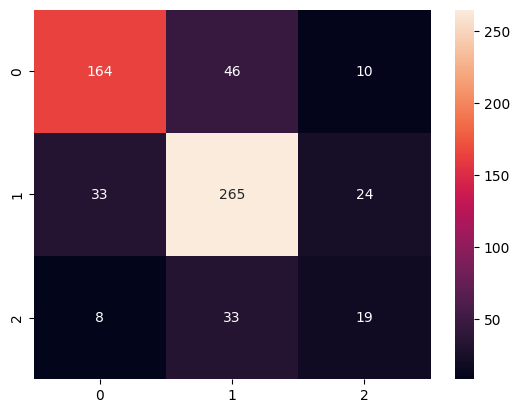

In [27]:
# Supondo que y_test e y_pred já estão definidos
cm = confusion_matrix(y_test, y_pred)

# Definir os rótulos desejados para os eixos
labels = ['ARG0', 'ARG1', 'ARG2', "ARG3", "ARG4"]

# Plotar o heatmap
ax = sns.heatmap(cm, annot=True, fmt='g')

# Definir os rótulos dos eixos
ax.set_xticklabels(labels, fontsize=12)
ax.set_yticklabels(labels, fontsize=12)

# Exibir o plot
plt.xlabel('Rótulo Previsto')
plt.ylabel('Rótulo Real')
plt.show()

###############################################
# corpus name: lp
###############################################
          
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       120
           1       0.78      0.86      0.82       151
           2       0.22      0.10      0.13        21
           3       0.00      0.00      0.00         5
           4       0.50      0.25      0.33         4

    accuracy                           0.78       301
   macro avg       0.47      0.41      0.43       301
weighted avg       0.75      0.78      0.76       301



/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

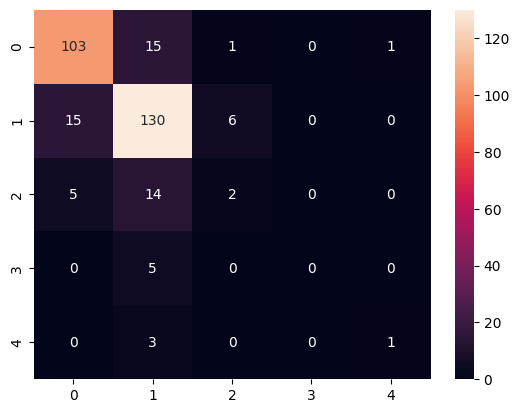

###############################################
# corpus name: news
###############################################
          
              precision    recall  f1-score   support

           0       0.76      0.63      0.69        60
           1       0.70      0.88      0.78       115
           2       0.67      0.26      0.37        31
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1

    accuracy                           0.71       208
   macro avg       0.42      0.35      0.37       208
weighted avg       0.70      0.71      0.68       208



/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

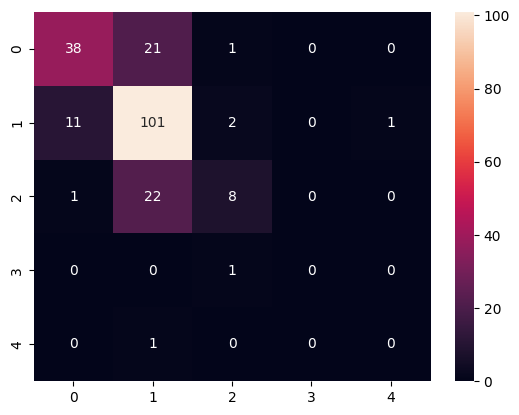

###############################################
# corpus name: opisums
###############################################
          
              precision    recall  f1-score   support

           0       0.81      0.62      0.70        34
           1       0.71      0.91      0.80        43
           2       0.50      0.29      0.36         7
           3       0.00      0.00      0.00         1

    accuracy                           0.73        85
   macro avg       0.50      0.45      0.46        85
weighted avg       0.72      0.73      0.71        85



/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

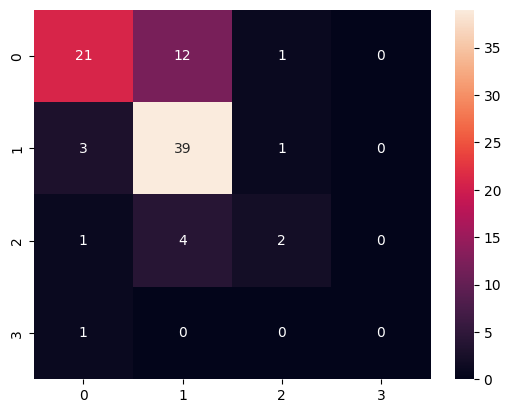

###############################################
# corpus name: sci
###############################################
          
              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       1.00      0.92      0.96        13
           2       1.00      1.00      1.00         1

    accuracy                           0.95        20
   macro avg       0.95      0.97      0.96        20
weighted avg       0.96      0.95      0.95        20



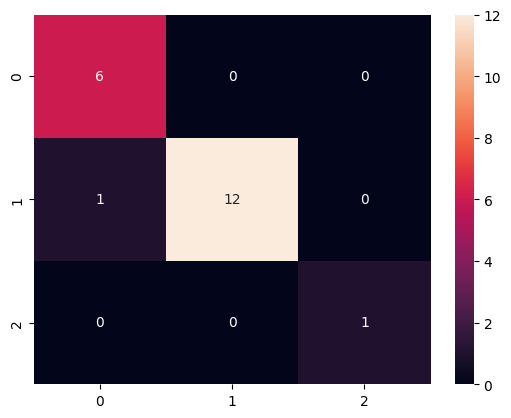

In [ ]:
df_features_test = df_features.loc[y_test.index.tolist(), :]

df_anl = pd.DataFrame({
    "y_test": y_test.tolist(),
    "y_pred": y_pred.tolist(),
    "corpus_name": df_features.loc[y_test.index.tolist(), :]['corpus_name'].tolist(),  
})

for cp_nm in df_anl.corpus_name.unique():
    
    print(f"""###############################################
# corpus name: {cp_nm}
###############################################
          """)
    
    df_anl_cp = df_anl[df_anl.corpus_name == cp_nm]
    
    print(classification_report(df_anl_cp.y_test, df_anl_cp.y_pred))
    
    cm=confusion_matrix(df_anl_cp.y_test, df_anl_cp.y_pred)
    sns.heatmap(cm, annot=True, fmt='g') # font size
    plt.show()

### Featue importance

In [ ]:
# # Acessar o objeto RFE na pipeline
# rfe = pipeline.named_steps['selecting']
# # Acessar o array que indica quais características foram selecionadas
# selected_features_mask = rfe.support_

selected_features_mask = model.named_steps['selecting'].get_support()

# Usar o array para filtrar os nomes das colunas do DataFrame original
selected_features = X_train.columns[selected_features_mask].tolist()

print("Características selecionadas pelo RFE:")
print(selected_features)


Características selecionadas pelo RFE:
['dep_ROOT', 'dep_advcl', 'dep_advmod', 'dep_ccomp', 'dep_conj', 'dep_iobj', 'dep_nao_tem_dep', 'dep_nsubj', 'dep_nsubj:pass', 'dep_obj', 'dep_obl', 'dep_parataxis', 'dep_xcomp', 'parent_text_,', 'parent_text_Chegamos', 'parent_text_Chegaram', 'parent_text_Confundem', 'parent_text_Da', 'parent_text_Entre', 'parent_text_Estamos', 'parent_text_Ficaram', 'parent_text_Iam', 'parent_text_Ir', 'parent_text_Li', 'parent_text_Retorna', 'parent_text_Sai', 'parent_text_Subiu', 'parent_text_Trabalhávamos', 'parent_text_Vamos', 'parent_text_Vim', 'parent_text_aberta', 'parent_text_aberto', 'parent_text_abertos', 'parent_text_aluga', 'parent_text_alugam', 'parent_text_ao', 'parent_text_apresentava', 'parent_text_assinando', 'parent_text_atuaram', 'parent_text_aumentando', 'parent_text_cair', 'parent_text_caiu', 'parent_text_caíram', 'parent_text_chega', 'parent_text_chegamos', 'parent_text_chegaram', 'parent_text_chegassem', 'parent_text_chego', 'parent_text_c

In [ ]:
# forma antiga de pegar a feature original
# # Função para remover a parte após o último underscore
# def remover_apos_ultimo_underscore(s):
#     return "_".join(s.split("_")[:-1])

# original_features = [remover_apos_ultimo_underscore(feat) for feat in selected_features]

In [ ]:
def get_original_feature(feature):
    
    # resolve as features embeddings
    if "emb" in feature:
        
        return re.sub(r'_\d+_', '_', feature)
    
    
    original_features = ['corpus_name', 'dep', 'parent_text',
        'parent_lemma', 'parent_pos', 'parent_tag', 'parent_ner', 'child_text',
        'child_lemma', 'child_pos', 'child_tag', 'child_ner', 'parent', 'child']
    
    for o_feat in original_features:
        
        if o_feat in feature:
            
            return o_feat
        
    return None
    

original_features = [get_original_feature(feat) for feat in selected_features]

# Extrair o modelo XGBClassifier da pipeline
xgb_model = model.named_steps['estimator']

# Obter as importâncias das características
feature_importances = xgb_model.feature_importances_

# Criar um DataFrame para facilitar a manipulação e visualização
feature_importance_df = pd.DataFrame({
    'feature': selected_features,
    "original_feature": original_features,
    'importance': feature_importances
})

In [ ]:
for idx, row in feature_importance_df.iterrows():
    
    print(row.feature,"|", row.original_feature)

dep_ROOT | dep
dep_advcl | dep
dep_advmod | dep
dep_ccomp | dep
dep_conj | dep
dep_iobj | dep
dep_nao_tem_dep | dep
dep_nsubj | dep
dep_nsubj:pass | dep
dep_obj | dep
dep_obl | dep
dep_parataxis | dep
dep_xcomp | dep
parent_text_, | parent_text
parent_text_Chegamos | parent_text
parent_text_Chegaram | parent_text
parent_text_Confundem | parent_text
parent_text_Da | parent_text
parent_text_Entre | parent_text
parent_text_Estamos | parent_text
parent_text_Ficaram | parent_text
parent_text_Iam | parent_text
parent_text_Ir | parent_text
parent_text_Li | parent_text
parent_text_Retorna | parent_text
parent_text_Sai | parent_text
parent_text_Subiu | parent_text
parent_text_Trabalhávamos | parent_text
parent_text_Vamos | parent_text
parent_text_Vim | parent_text
parent_text_aberta | parent_text
parent_text_aberto | parent_text
parent_text_abertos | parent_text
parent_text_aluga | parent_text
parent_text_alugam | parent_text
parent_text_ao | parent_text
parent_text_apresentava | parent_text
pa

In [ ]:
feature_importance_df.original_feature.value_counts()

original_feature
emb_lemma_child     300
emb_lemma_parent    300
parent_text         158
child_text           90
dep                  13
child_pos            10
child_tag            10
child_ner             5
parent_pos            3
parent_tag            3
Name: count, dtype: int64

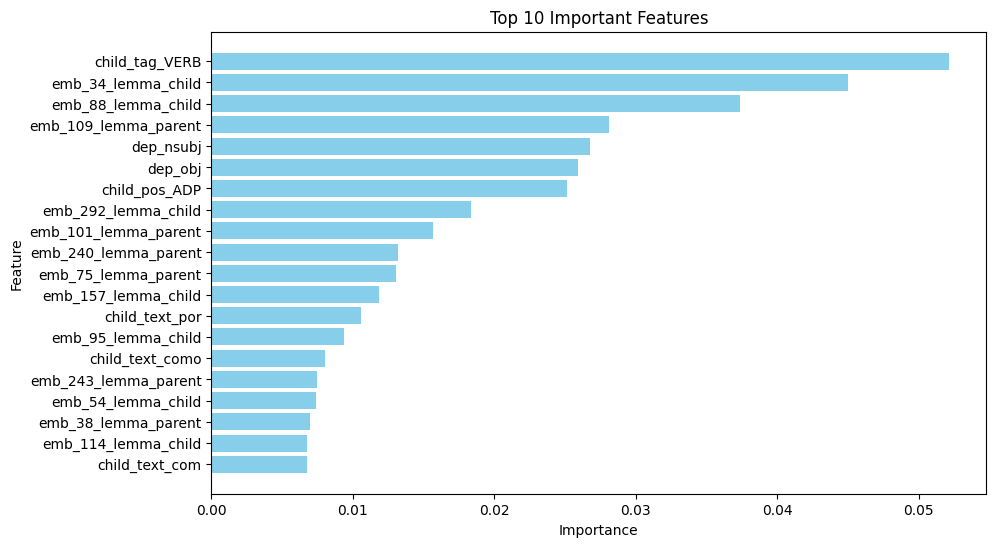

In [ ]:


# Ordenar o DataFrame pelo valor de importância
top_features = feature_importance_df.sort_values(by='importance', ascending=False).head(20)

# Plotar o gráfico de barras das principais características
plt.figure(figsize=(10, 6))
plt.barh(top_features['feature'], top_features['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Important Features')
plt.gca().invert_yaxis()  # Inverter o eixo y para mostrar a característica mais importante no topo
plt.show()


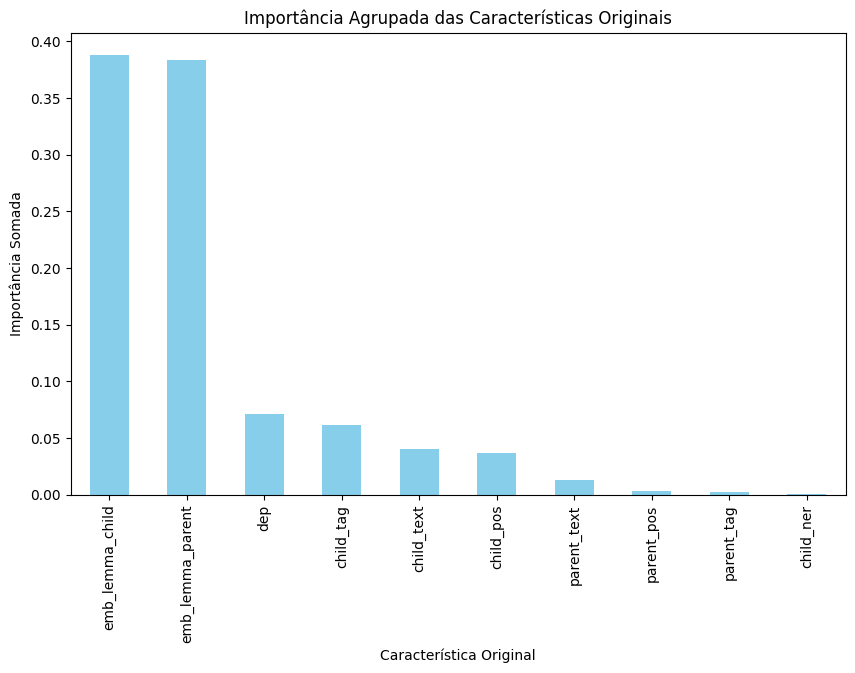

In [ ]:
grouped_importances = feature_importance_df.groupby('original_feature')['importance'].sum().sort_values(ascending=False)
# Plotar o gráfico das características originais mais importantes
plt.figure(figsize=(10, 6))
grouped_importances.head(10).plot(kind='bar', color='skyblue')
plt.title('Importância Agrupada das Características Originais')
plt.xlabel('Característica Original')
plt.ylabel('Importância Somada')
plt.show()

### SHAP

In [ ]:
# 1. Carregar o modelo treinado do pipeline
xgb_model = model.named_steps['estimator']

# 2. Criar o objeto Explainer para o modelo XGB
explainer = shap.TreeExplainer(xgb_model)

In [ ]:
for step in [step[0] for step in model.steps if step[0] != "estimator"]:
    
    print(step)
    
    if step == "sampling":
        pass
    else:
        X_test_processed = model[step].transform(X_test)
        X_train_processed = model[step].transform(X_train)

scaling
selecting


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectPercentile was fitted without feature names
  warnings.warn(
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectPercentile was fitted without feature names
  warnings.warn(


sampling


In [ ]:
df_X_test_anl = pd.DataFrame(X_test_processed, columns = selected_features)
df_X_train_anl = pd.DataFrame(X_train_processed, columns = selected_features)

In [ ]:
# 3. Calcular os SHAP values para o conjunto de teste
shap_values = explainer.shap_values(df_X_test_anl)

In [ ]:
explainer_2 = shap.Explainer(xgb_model, df_X_train_anl)
shap_values = explainer(df_X_train_anl)